In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from sklearn.datasets import load_iris
# import subprocess
import pyreadr
import math
import os

In [2]:
# # Date range
# file_name_date = '20211231'
start_date = pd.Timestamp('2020-01-22')
sev_start_date = pd.Timestamp("2020-10-01")
pre_date = pd.Timestamp('2021-08-20') # 예측 시작날짜
end_date = pd.Timestamp('2023-05-31') # 예측 끝 날짜
# # train_date = pd.date_range(start_date,pre_date-timedelta(days=1))
# train_date = pd.date_range(start_date,pre_date)

# predict_date = pd.date_range(pre_date,end_date) # 예측 날짜 범위
# date = pd.date_range(seir_start_date,end_date)

# Ground-Truth
###### (이유엔 데이터)

In [5]:
# 이유엔 데이터 경로
path_ = '../../../../01_data/국제/수집데이터_211013.xlsx'

In [6]:
### 확진자, 사망자
data_case= pd.read_excel(path_,engine = "openpyxl",sheet_name ='확진자,사망자수(US 제외)' )
data_case=data_case[data_case['Country'] =='South Korea']
data_case['tDate'] = pd.to_datetime(data_case['tDate'], format="%Y-%m-%d")
#df_= df_1_2.drop(['Province1','Province2','Unnamed: 6'], axis=1, inplace=True)
data_case.drop(['Province1','Province2'], axis=1, inplace=True)
data_case = data_case.fillna(0)
data_case.reset_index(drop=True, inplace=True)
# old_data= data_case[ data_case['tDate'].isin(train_date) ] #Confirmed, Deaths
# old_data = old_data.fillna(0)
# old_data

In [7]:
data_case

tDate      Country  Confirmed  Deaths
0   2020-01-22  South Korea          0       0
1   2020-01-23  South Korea          0       0
2   2020-01-24  South Korea          1       0
3   2020-01-25  South Korea          0       0
4   2020-01-26  South Korea          1       0
..         ...          ...        ...     ...
615 2021-10-08  South Korea       2172      10
616 2021-10-09  South Korea       1949       6
617 2021-10-10  South Korea       1594      15
618 2021-10-11  South Korea       1297       8
619 2021-10-12  South Korea       1347      11

[620 rows x 4 columns]

In [8]:
data_case.loc[[3],['Deaths']].values

array([[0]])

In [9]:
### 누적 확진자
data_case['Cum_Deaths']=0.0
for i in range(1,len(data_case)):
    data_case.loc[[i],['Cum_Deaths']] = float(data_case.loc[[i],['Deaths']].values)+float(data_case.loc[[i-1],['Cum_Deaths']].values)
data_case

tDate      Country  Confirmed  Deaths  Cum_Deaths
0   2020-01-22  South Korea          0       0         0.0
1   2020-01-23  South Korea          0       0         0.0
2   2020-01-24  South Korea          1       0         0.0
3   2020-01-25  South Korea          0       0         0.0
4   2020-01-26  South Korea          1       0         0.0
..         ...          ...        ...     ...         ...
615 2021-10-08  South Korea       2172      10      2560.0
616 2021-10-09  South Korea       1949       6      2566.0
617 2021-10-10  South Korea       1594      15      2581.0
618 2021-10-11  South Korea       1297       8      2589.0
619 2021-10-12  South Korea       1347      11      2600.0

[620 rows x 5 columns]

In [10]:
aug20_cum_deaths = float(data_case.loc[data_case['tDate']=='2021-08-20','Cum_Deaths'])
aug20_cum_deaths

2203.0

In [11]:
### 중증자
old_severity= pd.read_excel(path_, engine = "openpyxl",usecols='A,H',sheet_name ='확진자 관리현황')
old_severity.columns = ['tDate','Severity']
old_severity['tDate'] = pd.to_datetime(old_severity['tDate'], format="%Y-%m-%d")
old_severity = old_severity.fillna(0)
old_severity

tDate  Severity
0   2020-10-01       107
1   2020-10-02       107
2   2020-10-03       104
3   2020-10-04       105
4   2020-10-05       107
..         ...       ...
359 2021-09-25       339
360 2021-09-26       320
361 2021-09-27       319
362 2021-09-28       324
363 2021-09-29       331

[364 rows x 2 columns]

# Result csv

In [3]:
Rt = [2.5, 2.75, 3.0, 3.5, 4.5]

In [4]:
final_list = pd.read_csv('../../../../03_result/SEIR_V/211102/seir_v_211102.csv')
final_list = final_list.drop(['Unnamed: 0'],axis=1)
final_list['date'] = pd.to_datetime(final_list['date'], format="%Y-%m-%d")
final_list = final_list[final_list['date']>=pre_date] ##예측 시작날짜 이전 데이터 잘라냄.

final_list

V1          V2          V3          V4    t       date  \
18   209.978883  625.848154  584.600192  123.007997   18 2021-08-20   
19   213.298966  635.024650  589.577163  125.222154   19 2021-08-21   
20   216.373805  642.525372  593.086465  127.112995   20 2021-08-22   
21   219.244481  647.977880  595.689157  128.780412   21 2021-08-23   
22   221.589194  652.335856  596.614052  130.308877   22 2021-08-24   
..          ...         ...         ...         ...  ...        ...   
663    5.832478    9.578420    9.975349    5.230529  663 2023-05-27   
664    5.823617    9.561553    9.956989    5.222578  664 2023-05-28   
665    5.814768    9.544715    9.938660    5.214639  665 2023-05-29   
666    5.805932    9.527905    9.920364    5.206712  666 2023-05-30   
667    5.797109    9.511123    9.902099    5.198795  667 2023-05-31   

            case        V1.1        V2.1        V3.1  ...  min_death.12  \
18   1543.435226  209.978883  625.848154  584.600192  ...     74.475385   
19   1563.122933  213.298966  635.024650  589.577163  ...     80.106070   
20   1579.098637  216.373805  642.525372  593.086465  ...     85.718139   
21   1591.691931  219.244481  647.977880  595.689157  ...     91.305462   
22   1600.847979  221.589194  652.335856  596.614052  ...     96.863263   
..           ...         ...         ...         ...  ...           ...   
663    30.616776   26.088443   41.914583   44.093275  ...  64051.602453   
664    30.564737   26.013274   41.809117   43.979410  ...  64051.602457   
665    30.512783   25.938301   41.703885   43.856298  ...  64051.602460   
666    30.460913   25.863524   41.598887   43.728413  ...  64051.602463   
667    30.409127   25.783104   41.494122   43.600865  ...  64051.602466   

     max_death.12     date.88  t.88  min_death.13  max_death.13     date.89  \
18      75.419424  2021-08-20    18     74.475385     75.419424  2021-08-20   
19      81.226211  2021-08-21    19     80.106070     81.226211  2021-08-21   
20      87.032151  2021-08-22    20     85.718139     87.032151  2021-08-22   
21      92.831325  2021-08-23    21     91.305462     92.831325  2021-08-23   
22      98.619065  2021-08-24    22     96.863263     98.619065  2021-08-24   
..            ...         ...   ...           ...           ...         ...   
663  66572.922228  2023-05-27   663  63946.083531  66466.918603  2023-05-27   
664  66572.922231  2023-05-28   664  63946.083532  66466.918604  2023-05-28   
665  66572.922233  2023-05-29   665  63946.083532  66466.918604  2023-05-29   
666  66572.922236  2023-05-30   666  63946.083533  66466.918605  2023-05-30   
667  66572.922238  2023-05-31   667  63946.083534  66466.918606  2023-05-31   

     t.89  min_death.14  max_death.14  
18     18     74.475385     75.419424  
19     19     80.106070     81.226211  
20     20     85.718139     87.032151  
21     21     91.305462     92.831325  
22     22     96.863263     98.619065  
..    ...           ...           ...  
663   663  63832.048972  66351.887734  
664   664  63832.048973  66351.887735  
665   665  63832.048973  66351.887735  
666   666  63832.048973  66351.887735  
667   667  63832.048974  66351.887736  

[650 rows x 495 columns]

In [6]:
final_list.columns

Index(['V1', 'V2', 'V3', 'V4', 't', 'date', 'case', 'V1.1', 'V2.1', 'V3.1',
       ...
       'min_death.12', 'max_death.12', 'date.88', 't.88', 'min_death.13',
       'max_death.13', 'date.89', 't.89', 'min_death.14', 'max_death.14'],
      dtype='object', length=495)

## Rt 값에 따라 case, serve, death 데이터프레임 생성
### plot에 불필요한 columns 제거

In [15]:
cnt = 0

In [16]:
incidence = pd.DataFrame({'Date': final_list['date']})
severity = pd.DataFrame({'Date': final_list['date']})
deaths = pd.DataFrame({'Date': final_list['date']})

In [17]:
incidence['Date']

18    2021-08-20
19    2021-08-21
20    2021-08-22
21    2021-08-23
22    2021-08-24
         ...    
663   2023-05-27
664   2023-05-28
665   2023-05-29
666   2023-05-30
667   2023-05-31
Name: Date, Length: 650, dtype: datetime64[ns]

In [18]:
for rt in Rt:
    if rt == Rt[0]:
        rt_0_case = final_list.iloc[:,cnt:cnt+33]
        rt_0_case = rt_0_case.iloc[:,[5,6,13,20,23,24,27,28,31,32]]
        rt_0_case.columns = ['Date', str(rt)+'_h',str(rt)+'_b',str(rt)+'_l',str(rt)+'_h_min',str(rt)+'_h_max',str(rt)+'_b_min',str(rt)+'_b_max',str(rt)+'_l_min',str(rt)+'_l_max']
        rt_0_case['Date'] = pd.to_datetime(rt_0_case['Date'], format="%Y-%m-%d")
        ## incidence 에 추가
        incidence = pd.merge(incidence,rt_0_case, how='left', left_on='Date', right_on='Date')
        cnt += 33
        
        rt_0_serve = final_list.iloc[:,cnt:cnt+33]
        rt_0_serve = rt_0_serve.iloc[:,[5,6,13,20,23,24,27,28,31,32]]
        rt_0_serve.columns = ['Date', str(rt)+'_h',str(rt)+'_b',str(rt)+'_l',str(rt)+'_h_min',str(rt)+'_h_max',str(rt)+'_b_min',str(rt)+'_b_max',str(rt)+'_l_min',str(rt)+'_l_max']
        rt_0_serve['Date'] = pd.to_datetime(rt_0_serve['Date'], format="%Y-%m-%d")
        ## severity 에 추가
        severity = pd.merge(severity,rt_0_serve, how='left', left_on='Date', right_on='Date')
        cnt += 33
        
        rt_0_death = final_list.iloc[:,cnt:cnt+33]
        rt_0_death = rt_0_death.iloc[:,[5,6,13,20,23,24,27,28,31,32]]
        rt_0_death.columns = ['Date', str(rt)+'_h',str(rt)+'_b',str(rt)+'_l',str(rt)+'_h_min',str(rt)+'_h_max',str(rt)+'_b_min',str(rt)+'_b_max',str(rt)+'_l_min',str(rt)+'_l_max']
        rt_0_death['Date'] = pd.to_datetime(rt_0_death['Date'], format="%Y-%m-%d")
        ## deaths 에 추가
        deaths = pd.merge(deaths,rt_0_death, how='left', left_on='Date', right_on='Date')
        cnt += 33
        
    elif rt == Rt[1]:
        rt_1_case = final_list.iloc[:,cnt:cnt+33]
        rt_1_case = rt_1_case.iloc[:,[5,6,13,20,23,24,27,28,31,32]]
        rt_1_case.columns = ['Date', str(rt)+'_h',str(rt)+'_b',str(rt)+'_l',str(rt)+'_h_min',str(rt)+'_h_max',str(rt)+'_b_min',str(rt)+'_b_max',str(rt)+'_l_min',str(rt)+'_l_max']
        rt_1_case['Date'] = pd.to_datetime(rt_1_case['Date'], format="%Y-%m-%d")
        ## incidence 에 추가
        incidence = pd.merge(incidence,rt_1_case, how='left', left_on='Date', right_on='Date')
        cnt += 33
        
        rt_1_serve = final_list.iloc[:,cnt:cnt+33]
        rt_1_serve = rt_1_serve.iloc[:,[5,6,13,20,23,24,27,28,31,32]]
        rt_1_serve.columns = ['Date', str(rt)+'_h',str(rt)+'_b',str(rt)+'_l',str(rt)+'_h_min',str(rt)+'_h_max',str(rt)+'_b_min',str(rt)+'_b_max',str(rt)+'_l_min',str(rt)+'_l_max']
        rt_1_serve['Date'] = pd.to_datetime(rt_1_serve['Date'], format="%Y-%m-%d")
        ## severity 에 추가
        severity = pd.merge(severity,rt_1_serve, how='left', left_on='Date', right_on='Date')
        cnt += 33
        
        rt_1_death = final_list.iloc[:,cnt:cnt+33]
        rt_1_death = rt_1_death.iloc[:,[5,6,13,20,23,24,27,28,31,32]]
        rt_1_death.columns = ['Date', str(rt)+'_h',str(rt)+'_b',str(rt)+'_l',str(rt)+'_h_min',str(rt)+'_h_max',str(rt)+'_b_min',str(rt)+'_b_max',str(rt)+'_l_min',str(rt)+'_l_max']
        rt_1_death['Date'] = pd.to_datetime(rt_1_death['Date'], format="%Y-%m-%d")
        ## deaths 에 추가
        deaths = pd.merge(deaths,rt_1_death, how='left', left_on='Date', right_on='Date')
        cnt += 33
        
    elif rt == Rt[2]:
        rt_2_case = final_list.iloc[:,cnt:cnt+33]
        rt_2_case = rt_2_case.iloc[:,[5,6,13,20,23,24,27,28,31,32]]
        rt_2_case.columns = ['Date', str(rt)+'_h',str(rt)+'_b',str(rt)+'_l',str(rt)+'_h_min',str(rt)+'_h_max',str(rt)+'_b_min',str(rt)+'_b_max',str(rt)+'_l_min',str(rt)+'_l_max']
        rt_2_case['Date'] = pd.to_datetime(rt_2_case['Date'], format="%Y-%m-%d")
        ## incidence 에 추가
        incidence = pd.merge(incidence,rt_2_case, how='left', left_on='Date', right_on='Date')
        cnt += 33
        
        rt_2_serve = final_list.iloc[:,cnt:cnt+33]
        rt_2_serve = rt_2_serve.iloc[:,[5,6,13,20,23,24,27,28,31,32]]
        rt_2_serve.columns = ['Date', str(rt)+'_h',str(rt)+'_b',str(rt)+'_l',str(rt)+'_h_min',str(rt)+'_h_max',str(rt)+'_b_min',str(rt)+'_b_max',str(rt)+'_l_min',str(rt)+'_l_max']
        rt_2_serve['Date'] = pd.to_datetime(rt_2_serve['Date'], format="%Y-%m-%d")
        ## severity 에 추가
        severity = pd.merge(severity,rt_2_serve, how='left', left_on='Date', right_on='Date')
        cnt += 33
        
        rt_2_death = final_list.iloc[:,cnt:cnt+33]
        rt_2_death = rt_2_death.iloc[:,[5,6,13,20,23,24,27,28,31,32]]
        rt_2_death.columns = ['Date', str(rt)+'_h',str(rt)+'_b',str(rt)+'_l',str(rt)+'_h_min',str(rt)+'_h_max',str(rt)+'_b_min',str(rt)+'_b_max',str(rt)+'_l_min',str(rt)+'_l_max']
        rt_2_death['Date'] = pd.to_datetime(rt_2_death['Date'], format="%Y-%m-%d")
        ## deaths 에 추가
        deaths = pd.merge(deaths,rt_2_death, how='left', left_on='Date', right_on='Date')
        cnt += 33
        
    elif rt == Rt[3]:
        rt_3_case = final_list.iloc[:,cnt:cnt+33]
        rt_3_case = rt_3_case.iloc[:,[5,6,13,20,23,24,27,28,31,32]]
        rt_3_case.columns = ['Date', str(rt)+'_h',str(rt)+'_b',str(rt)+'_l',str(rt)+'_h_min',str(rt)+'_h_max',str(rt)+'_b_min',str(rt)+'_b_max',str(rt)+'_l_min',str(rt)+'_l_max']
        rt_3_case['Date'] = pd.to_datetime(rt_3_case['Date'], format="%Y-%m-%d")
        ## incidence 에 추가
        incidence = pd.merge(incidence,rt_3_case, how='left', left_on='Date', right_on='Date')
        cnt += 33
        
        rt_3_serve = final_list.iloc[:,cnt:cnt+33]
        rt_3_serve = rt_3_serve.iloc[:,[5,6,13,20,23,24,27,28,31,32]]
        rt_3_serve.columns = ['Date', str(rt)+'_h',str(rt)+'_b',str(rt)+'_l',str(rt)+'_h_min',str(rt)+'_h_max',str(rt)+'_b_min',str(rt)+'_b_max',str(rt)+'_l_min',str(rt)+'_l_max']
        rt_3_serve['Date'] = pd.to_datetime(rt_3_serve['Date'], format="%Y-%m-%d")
        ## severity 에 추가
        severity = pd.merge(severity,rt_3_serve, how='left', left_on='Date', right_on='Date')
        cnt += 33
        
        rt_3_death = final_list.iloc[:,cnt:cnt+33]
        rt_3_death = rt_3_death.iloc[:,[5,6,13,20,23,24,27,28,31,32]]
        rt_3_death.columns = ['Date', str(rt)+'_h',str(rt)+'_b',str(rt)+'_l',str(rt)+'_h_min',str(rt)+'_h_max',str(rt)+'_b_min',str(rt)+'_b_max',str(rt)+'_l_min',str(rt)+'_l_max']
        rt_3_death['Date'] = pd.to_datetime(rt_3_death['Date'], format="%Y-%m-%d")
        ## deaths 에 추가
        deaths = pd.merge(deaths,rt_3_death, how='left', left_on='Date', right_on='Date')
        cnt += 33
    else:
        rt_4_case = final_list.iloc[:,cnt:cnt+33]
        rt_4_case = rt_4_case.iloc[:,[5,6,13,20,23,24,27,28,31,32]]
        rt_4_case.columns = ['Date', str(rt)+'_h',str(rt)+'_b',str(rt)+'_l',str(rt)+'_h_min',str(rt)+'_h_max',str(rt)+'_b_min',str(rt)+'_b_max',str(rt)+'_l_min',str(rt)+'_l_max']
        rt_4_case['Date'] = pd.to_datetime(rt_4_case['Date'], format="%Y-%m-%d")
        ## incidence 에 추가
        incidence = pd.merge(incidence,rt_4_case, how='left', left_on='Date', right_on='Date')
        cnt += 33
        
        rt_4_serve = final_list.iloc[:,cnt:cnt+33]
        rt_4_serve = rt_4_serve.iloc[:,[5,6,13,20,23,24,27,28,31,32]]
        rt_4_serve.columns = ['Date', str(rt)+'_h',str(rt)+'_b',str(rt)+'_l',str(rt)+'_h_min',str(rt)+'_h_max',str(rt)+'_b_min',str(rt)+'_b_max',str(rt)+'_l_min',str(rt)+'_l_max']
        rt_4_serve['Date'] = pd.to_datetime(rt_4_serve['Date'], format="%Y-%m-%d")
        ## severity 에 추가
        severity = pd.merge(severity,rt_4_serve, how='left', left_on='Date', right_on='Date')
        cnt += 33
        
        rt_4_death = final_list.iloc[:,cnt:cnt+33]
        rt_4_death = rt_4_death.iloc[:,[5,6,13,20,23,24,27,28,31,32]]
        rt_4_death.columns = ['Date', str(rt)+'_h',str(rt)+'_b',str(rt)+'_l',str(rt)+'_h_min',str(rt)+'_h_max',str(rt)+'_b_min',str(rt)+'_b_max',str(rt)+'_l_min',str(rt)+'_l_max']
        rt_4_death['Date'] = pd.to_datetime(rt_4_death['Date'], format="%Y-%m-%d")
        ## deaths 에 추가
        deaths = pd.merge(deaths,rt_4_death, how='left', left_on='Date', right_on='Date')
        cnt += 33

In [19]:
rt_0_case

Date        2.5_h        2.5_b        2.5_l    2.5_h_min  \
18  2021-08-20  1543.435226  1543.435226  1543.435226  1474.295410   
19  2021-08-21  1563.122933  1563.122933  1563.122933  1490.354135   
20  2021-08-22  1579.098637  1579.098637  1579.098637  1502.433672   
21  2021-08-23  1591.691931  1591.691931  1591.691931  1511.053041   
22  2021-08-24  1600.847979  1600.847979  1600.847979  1516.746720   
..         ...          ...          ...          ...          ...   
663 2023-05-27    30.616776   135.232070   196.037660    14.340799   
664 2023-05-28    30.564737   134.877879   195.173021    14.304688   
665 2023-05-29    30.512783   134.515009   194.340220    14.268668   
666 2023-05-30    30.460913   134.147931   193.524100    14.232737   
667 2023-05-31    30.409127   133.775919   192.711213    14.196897   

       2.5_h_max    2.5_b_min    2.5_b_max    2.5_l_min    2.5_l_max  
18   1624.920005  1474.295410  1624.920005  1474.295410  1624.920005  
19   1649.273319  1490.354135  1649.273319  1490.354135  1649.273319  
20   1669.530761  1502.433672  1669.530761  1502.433672  1669.530761  
21   1686.250123  1511.053041  1686.250123  1511.053041  1686.250123  
22   1700.100459  1516.746720  1700.100459  1516.746720  1700.100459  
..           ...          ...          ...          ...          ...  
663    55.318139    70.201317   228.711321   116.021911   310.518851  
664    55.264506    69.966049   228.237819   115.450445   309.498681  
665    55.210907    69.731547   227.764995   114.881735   308.481315  
666    55.157342    69.497807   227.292851   114.315768   307.466747  
667    55.103811    69.264828   226.821386   113.750492   306.454974  

[650 rows x 10 columns]

In [20]:
incidence

Date        2.5_h        2.5_b        2.5_l    2.5_h_min  \
0   2021-08-20  1543.435226  1543.435226  1543.435226  1474.295410   
1   2021-08-21  1563.122933  1563.122933  1563.122933  1490.354135   
2   2021-08-22  1579.098637  1579.098637  1579.098637  1502.433672   
3   2021-08-23  1591.691931  1591.691931  1591.691931  1511.053041   
4   2021-08-24  1600.847979  1600.847979  1600.847979  1516.746720   
..         ...          ...          ...          ...          ...   
645 2023-05-27    30.616776   135.232070   196.037660    14.340799   
646 2023-05-28    30.564737   134.877879   195.173021    14.304688   
647 2023-05-29    30.512783   134.515009   194.340220    14.268668   
648 2023-05-30    30.460913   134.147931   193.524100    14.232737   
649 2023-05-31    30.409127   133.775919   192.711213    14.196897   

       2.5_h_max    2.5_b_min    2.5_b_max    2.5_l_min    2.5_l_max  ...  \
0    1624.920005  1474.295410  1624.920005  1474.295410  1624.920005  ...   
1    1649.273319  1490.354135  1649.273319  1490.354135  1649.273319  ...   
2    1669.530761  1502.433672  1669.530761  1502.433672  1669.530761  ...   
3    1686.250123  1511.053041  1686.250123  1511.053041  1686.250123  ...   
4    1700.100459  1516.746720  1700.100459  1516.746720  1700.100459  ...   
..           ...          ...          ...          ...          ...  ...   
645    55.318139    70.201317   228.711321   116.021911   310.518851  ...   
646    55.264506    69.966049   228.237819   115.450445   309.498681  ...   
647    55.210907    69.731547   227.764995   114.881735   308.481315  ...   
648    55.157342    69.497807   227.292851   114.315768   307.466747  ...   
649    55.103811    69.264828   226.821386   113.750492   306.454974  ...   

       3.5_l_max        4.5_h         4.5_b         4.5_l    4.5_h_min  \
0    1624.920005  1543.435226  1.543435e+03  1.543435e+03  1474.295410   
1    1649.273319  1563.122933  1.563123e+03  1.563123e+03  1490.354135   
2    1669.530761  1579.098637  1.579099e+03  1.579099e+03  1502.433672   
3    1686.250123  1591.691931  1.591692e+03  1.591692e+03  1511.053041   
4    1700.100459  1600.847979  1.600848e+03  1.600848e+03  1516.746720   
..           ...          ...           ...           ...          ...   
645     0.490840     0.000003  6.928428e-07  3.043108e-07     0.000002   
646     0.474135     0.000003  6.508238e-07  2.861358e-07     0.000002   
647     0.457998     0.000003  6.113860e-07  2.690668e-07     0.000001   
648     0.442411     0.000003  5.743702e-07  2.530343e-07     0.000001   
649     0.427354     0.000003  5.396276e-07  2.379762e-07     0.000001   

       4.5_h_max     4.5_b_min    4.5_b_max     4.5_l_min     4.5_l_max  
0    1624.920005  1.474295e+03  1624.920005  1.474295e+03  1.624920e+03  
1    1649.273319  1.490354e+03  1649.273319  1.490354e+03  1.649273e+03  
2    1669.530761  1.502434e+03  1669.530761  1.502434e+03  1.669531e+03  
3    1686.250123  1.511053e+03  1686.250123  1.511053e+03  1.686250e+03  
4    1700.100459  1.516747e+03  1700.100459  1.516747e+03  1.700100e+03  
..           ...           ...          ...           ...           ...  
645     0.000007  3.403313e-07     0.000002  1.531598e-07  6.684015e-07  
646     0.000007  3.198082e-07     0.000001  1.441476e-07  6.285910e-07  
647     0.000007  3.005520e-07     0.000001  1.356837e-07  5.911757e-07  
648     0.000006  2.824824e-07     0.000001  1.277328e-07  5.560102e-07  
649     0.000006  2.655268e-07     0.000001  1.202628e-07  5.229591e-07  

[650 rows x 46 columns]

In [21]:
severity

Date       2.5_h       2.5_b       2.5_l   2.5_h_min   2.5_h_max  \
0   2021-08-20  178.311178  178.311178  178.311178  174.956875  181.931595   
1   2021-08-21  180.510915  180.510915  180.510915  176.827745  184.533145   
2   2021-08-22  182.454478  182.454478  182.454478  178.443165  186.892732   
3   2021-08-23  184.166794  184.166794  184.166794  179.830682  189.033874   
4   2021-08-24  185.670642  185.670642  185.670642  181.011918  190.975694   
..         ...         ...         ...         ...         ...         ...   
645 2023-05-27    4.069767   18.381310   27.738789    1.992271    7.291751   
646 2023-05-28    4.062862   18.328981   27.616799    1.987373    7.284745   
647 2023-05-29    4.055967   18.276786   27.496103    1.982488    7.277742   
648 2023-05-30    4.049084   18.224724   27.375946    1.977615    7.270744   
649 2023-05-31    4.042212   18.172794   27.260024    1.972753    7.263750   

      2.5_b_min   2.5_b_max   2.5_l_min   2.5_l_max  ...   3.5_l_max  \
0    174.956875  181.931595  174.956875  181.931595  ...  181.931595   
1    176.827745  184.533145  176.827745  184.533145  ...  184.533145   
2    178.443165  186.892732  178.443165  186.892732  ...  186.892732   
3    179.830682  189.033874  179.830682  189.033874  ...  189.033874   
4    181.011918  190.975694  181.011918  190.975694  ...  190.975694   
..          ...         ...         ...         ...  ...         ...   
645    9.905088   30.939866   16.740847   42.400137  ...    0.176815   
646    9.871228   30.876391   16.658998   42.266756  ...    0.170855   
647    9.837479   30.813004   16.577539   42.133708  ...    0.165095   
648    9.803842   30.749704   16.496468   42.000994  ...    0.159529   
649    9.770316   30.686492   16.415784   41.868612  ...    0.154152   

          4.5_h       4.5_b       4.5_l   4.5_h_min   4.5_h_max   4.5_b_min  \
0    178.311178  178.311178  178.311178  174.956875  181.931595  174.956875   
1    180.510915  180.510915  180.510915  176.827745  184.533145  176.827745   
2    182.454478  182.454478  182.454478  178.443165  186.892732  178.443165   
3    184.166794  184.166794  184.166794  179.830682  189.033874  179.830682   
4    185.670642  185.670642  185.670642  181.011918  190.975694  181.011918   
..          ...         ...         ...         ...         ...         ...   
645    0.000084    0.000020    0.000009    0.000058    0.000124    0.000014   
646    0.000079    0.000019    0.000009    0.000054    0.000118    0.000013   
647    0.000075    0.000018    0.000008    0.000051    0.000111    0.000012   
648    0.000071    0.000017    0.000008    0.000049    0.000105    0.000012   
649    0.000067    0.000016    0.000007    0.000046    0.000100    0.000011   

      4.5_b_max   4.5_l_min   4.5_l_max  
0    181.931595  174.956875  181.931595  
1    184.533145  176.827745  184.533145  
2    186.892732  178.443165  186.892732  
3    189.033874  179.830682  189.033874  
4    190.975694  181.011918  190.975694  
..          ...         ...         ...  
645    0.000029    0.000006    0.000013  
646    0.000028    0.000006    0.000013  
647    0.000026    0.000006    0.000012  
648    0.000025    0.000005    0.000011  
649    0.000024    0.000005    0.000011  

[650 rows x 46 columns]

In [22]:
deaths

Date       2.5_h        2.5_b        2.5_l   2.5_h_min   2.5_h_max  \
0   2021-08-20   74.941860    74.941860    74.941860   74.475385   75.419424   
1   2021-08-21   80.655132    80.655132    80.655132   80.106070   81.226211   
2   2021-08-22   86.355133    86.355133    86.355133   85.718139   87.032151   
3   2021-08-23   92.044911    92.044911    92.044911   91.305462   92.831325   
4   2021-08-24   97.719949    97.719949    97.719949   96.863263   98.619065   
..         ...         ...          ...          ...         ...         ...   
645 2023-05-27  521.176074  1206.925952  2283.068936  465.105857  603.287538   
646 2023-05-28  521.306780  1207.435021  2284.296509  465.186232  603.503251   
647 2023-05-29  521.437270  1207.942508  2285.519682  465.266444  603.720455   
648 2023-05-30  521.567544  1208.448418  2286.738469  465.346495  603.937374   
649 2023-05-31  521.697604  1208.952756  2287.952885  465.426383  604.154010   

      2.5_b_min    2.5_b_max    2.5_l_min    2.5_l_max  ...     3.5_l_max  \
0     74.475385    75.419424    74.475385    75.419424  ...     75.419424   
1     80.106070    81.226211    80.106070    81.226211  ...     81.226211   
2     85.718139    87.032151    85.718139    87.032151  ...     87.032151   
3     91.305462    92.831325    91.305462    92.831325  ...     92.831325   
4     96.863263    98.619065    96.863263    98.619065  ...     98.619065   
..          ...          ...          ...          ...  ...           ...   
645  960.907560  1575.991005  1770.732704  3012.095676  ...  44193.802758   
646  961.250217  1577.048845  1771.338643  3013.459220  ...  44193.805400   
647  961.591767  1578.104160  1771.941896  3014.816686  ...  44193.807949   
648  961.932215  1579.156956  1772.542474  3016.168097  ...  44193.810406   
649  962.271563  1580.207237  1773.140387  3017.513478  ...  44193.812776   

            4.5_h         4.5_b         4.5_l     4.5_h_min     4.5_h_max  \
0       74.941860     74.941860     74.941860     74.475385     75.419424   
1       80.655132     80.655132     80.655132     80.106070     81.226211   
2       86.355133     86.355133     86.355133     85.718139     87.032151   
3       92.044911     92.044911     92.044911     91.305462     92.831325   
4       97.719949     97.719949     97.719949     96.863263     98.619065   
..            ...           ...           ...           ...           ...   
645  65404.541451  65296.869676  65171.706711  64051.602453  66572.922228   
646  65404.541454  65296.869677  65171.706711  64051.602457  66572.922231   
647  65404.541457  65296.869677  65171.706711  64051.602460  66572.922233   
648  65404.541460  65296.869678  65171.706712  64051.602463  66572.922236   
649  65404.541463  65296.869679  65171.706712  64051.602466  66572.922238   

        4.5_b_min     4.5_b_max     4.5_l_min     4.5_l_max  
0       74.475385     75.419424     74.475385     75.419424  
1       80.106070     81.226211     80.106070     81.226211  
2       85.718139     87.032151     85.718139     87.032151  
3       91.305462     92.831325     91.305462     92.831325  
4       96.863263     98.619065     96.863263     98.619065  
..            ...           ...           ...           ...  
645  63946.083531  66466.918603  63832.048972  66351.887734  
646  63946.083532  66466.918604  63832.048973  66351.887735  
647  63946.083532  66466.918604  63832.048973  66351.887735  
648  63946.083533  66466.918605  63832.048973  66351.887735  
649  63946.083534  66466.918606  63832.048974  66351.887736  

[650 rows x 46 columns]

# original plot

In [23]:
## original plot

def Original_Plot(x,y,rt):
    file_name = 'rt '+str(rt)+' - '+x
    if x == 'incidence':
        ground_truth = data_case
        column = 'Confirmed'
        plt_start_date = start_date
        offset = 0
        if rt == Rt[0]:
            y_lim = [-100,3500]
        if rt == Rt[1]:
            y_lim = [-100,12000]
        if rt == Rt[2]:
            y_lim = [-100,35000]
        if rt == Rt[3]:
            y_lim = [-100,100000]
        if rt == Rt[4]:
            y_lim = [-100,250000]
        
    elif x == 'deaths':
        ground_truth = data_case
        column = 'Cum_Deaths'
        plt_start_date = start_date
        offset = aug20_cum_deaths
        if rt == Rt[0]:
            y_lim = [-100,6800]
        if rt == Rt[1]:
            y_lim = [-100,21000]
        if rt == Rt[2]:
            y_lim = [-100,38000]
        if rt == Rt[3]:
            y_lim = [-100,63000]
        if rt == Rt[4]:
            y_lim = [-100,93000]

    else:
        ground_truth = old_severity
        column = 'Severity'
        plt_start_date = sev_start_date
        offset = 0
        if rt == Rt[0]:
            y_lim = [-100,500]
        if rt == Rt[1]:
            y_lim = [-100,1500]
        if rt == Rt[2]:
            y_lim = [-100,5000]
        if rt == Rt[3]:
            y_lim = [-100,13000]
        if rt == Rt[4]:
            y_lim = [-100,30000]

        


    ################스타일#######################################
    fig = plt.figure(figsize=(40,15)) ## 캔버스 생성
    fig.patch.set_facecolor('#050636') 
    plt.rcParams['text.color'] = 'w'
    plt.rcParams['xtick.color'] = 'w'
    plt.rcParams['ytick.color'] = 'w'
    plt.rcParams['axes.spines.left'] = True
    plt.rcParams['axes.facecolor']='#050636'
    plt.grid(color='w', linestyle='-', linewidth=3,alpha = 0.5)
    plt.gca().spines['bottom'].set_visible(True) #위 테두리
    plt.gca().spines['left'].set_visible(True) #왼쪽 테두리
    plt.ylim(y_lim)
    #############################################################
   

    ################ Ground Truth #######################################
    plt.plot(ground_truth['tDate'], ground_truth[column],color = '#2dcafd',  linewidth = 6)

    ################ npi low Data #######################################
    plt.plot(y['Date'], y[str(rt)+'_l']+offset, color ='#f68960', linewidth = 8)
    plt.fill_between(y['Date'], y[str(rt)+'_l_min']+offset,y[str(rt)+'_l_max']+offset, color = '#f68960',alpha=0.2)
    
    
    ################ npi Base Data #######################################
    plt.plot(y['Date'], y[str(rt)+'_b']+offset, color ='#f56be4', linewidth = 8)
    plt.fill_between(y['Date'], y[str(rt)+'_b_min']+offset,y[str(rt)+'_b_max']+offset, color = '#f56be4',alpha=0.2)
    
    
    ################ npi high Data #######################################
    plt.plot(y['Date'], y[str(rt)+'_h']+offset, color ='#09d0a2', linewidth = 8)
    plt.fill_between(y['Date'], y[str(rt)+'_h_min']+offset,y[str(rt)+'_h_max']+offset, color = '#09d0a2',alpha=0.2)

    
    
    
    ################ Legend #######################################
    plt.legend(['Ground-Truth','Rt Counter 10%','Rt counter 20%','Rt counter 30%'],fontsize = 30,loc = 'upper left', edgecolor = 'w')


    plt.axvline(x = pre_date,linestyle = ':',color='w',linewidth=8, alpha = 0.7)
    
    plt.title('Rt '+str(rt)+x,fontsize=50)
#     plt.suptitle(file_name, y=1, fontsize=30)
    plt.xticks([plt_start_date,pre_date,end_date],[str(plt_start_date)[:10],str(pre_date)[:10],str(end_date)[:10]],fontsize=30)
    plt.yticks(fontsize = 30)
    plt.tight_layout()
#     plt.savefig("../figures/I/"+file_name+".png",dpi=300)
    plt.show()

In [24]:
data_case = data_case[data_case['tDate']<=pre_date]
old_severity = old_severity[old_severity['tDate']<=pre_date]

### 확진자

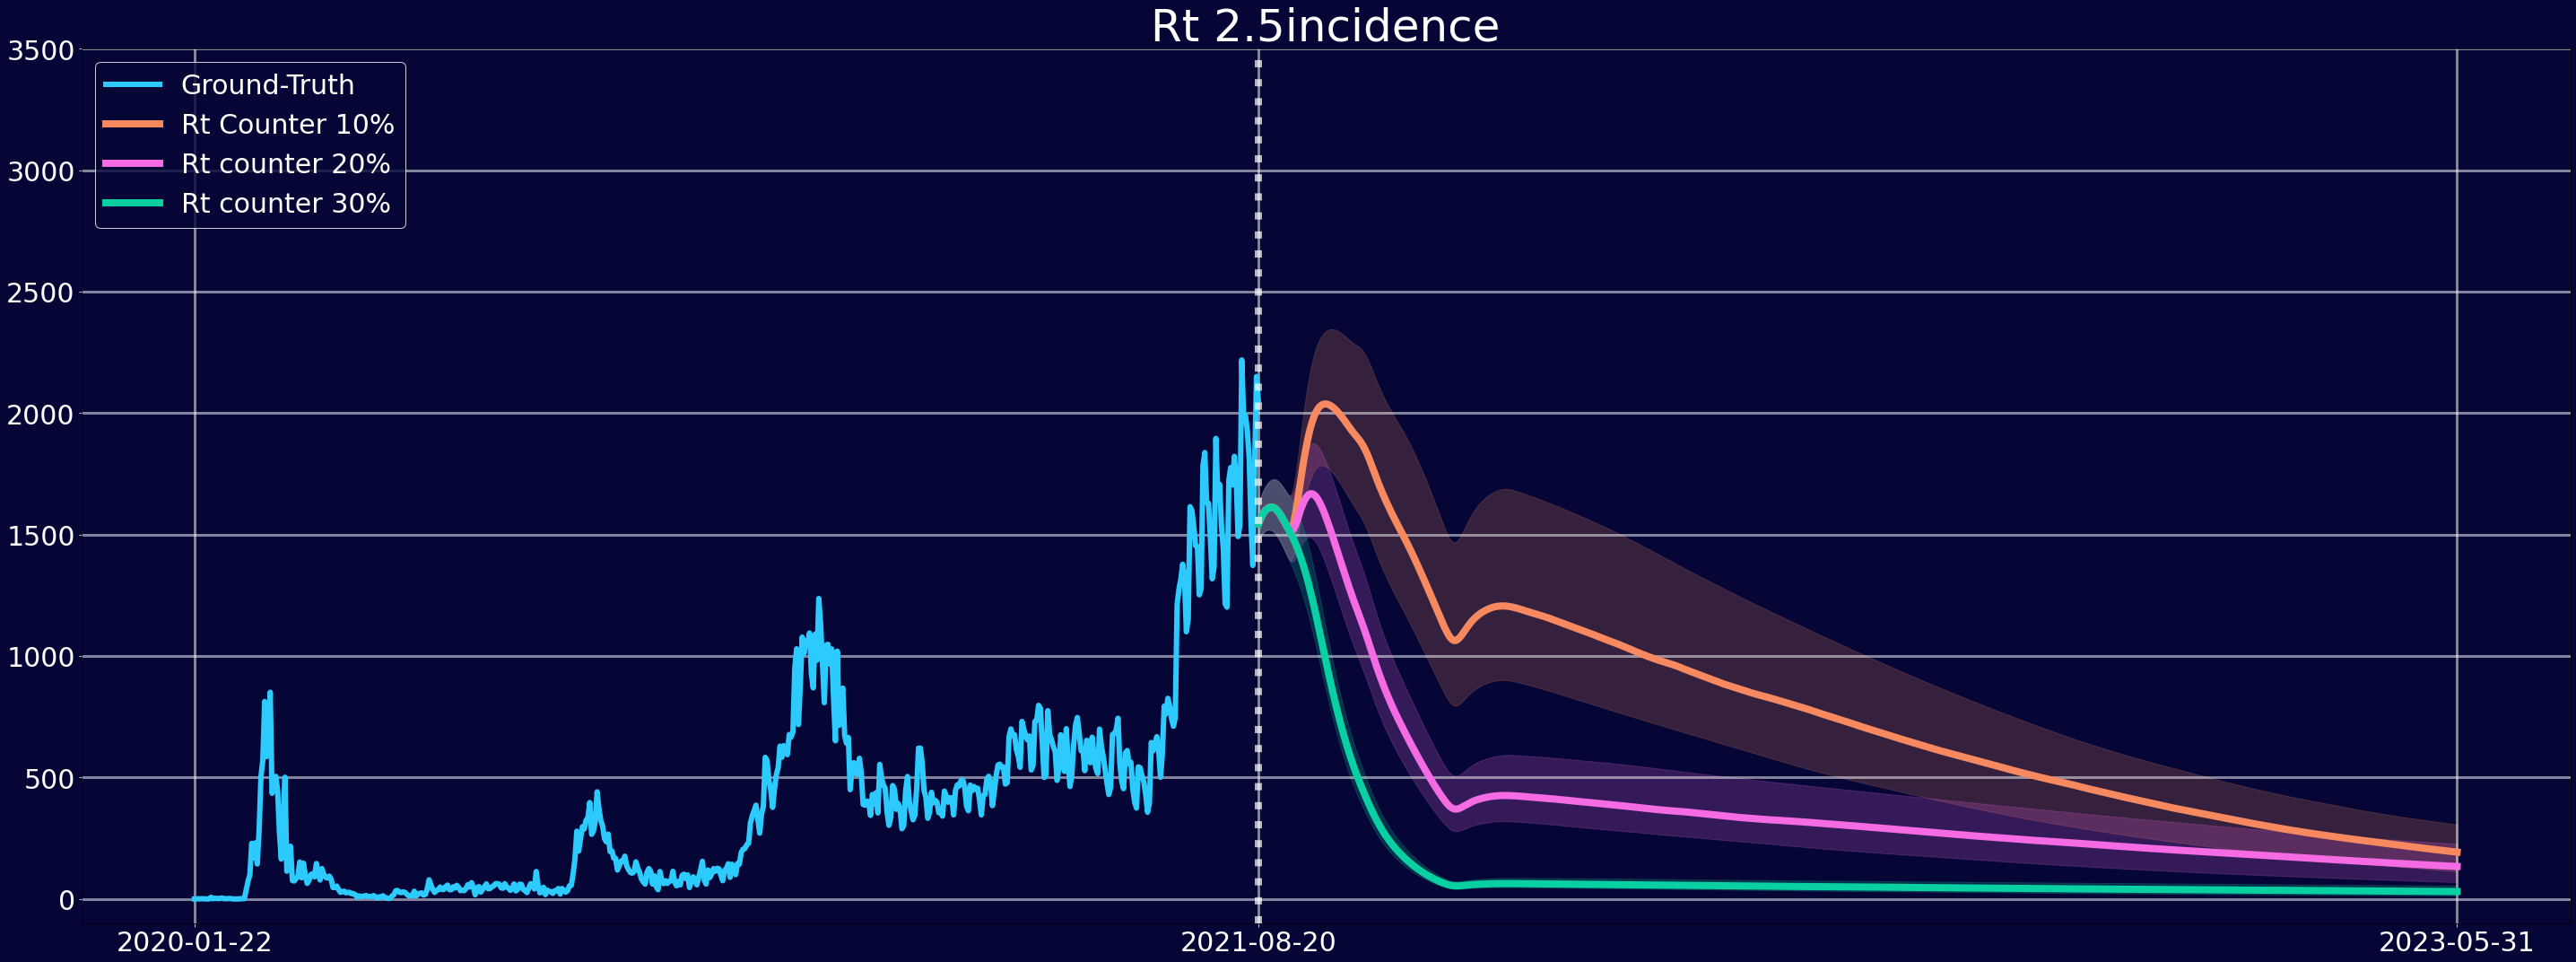

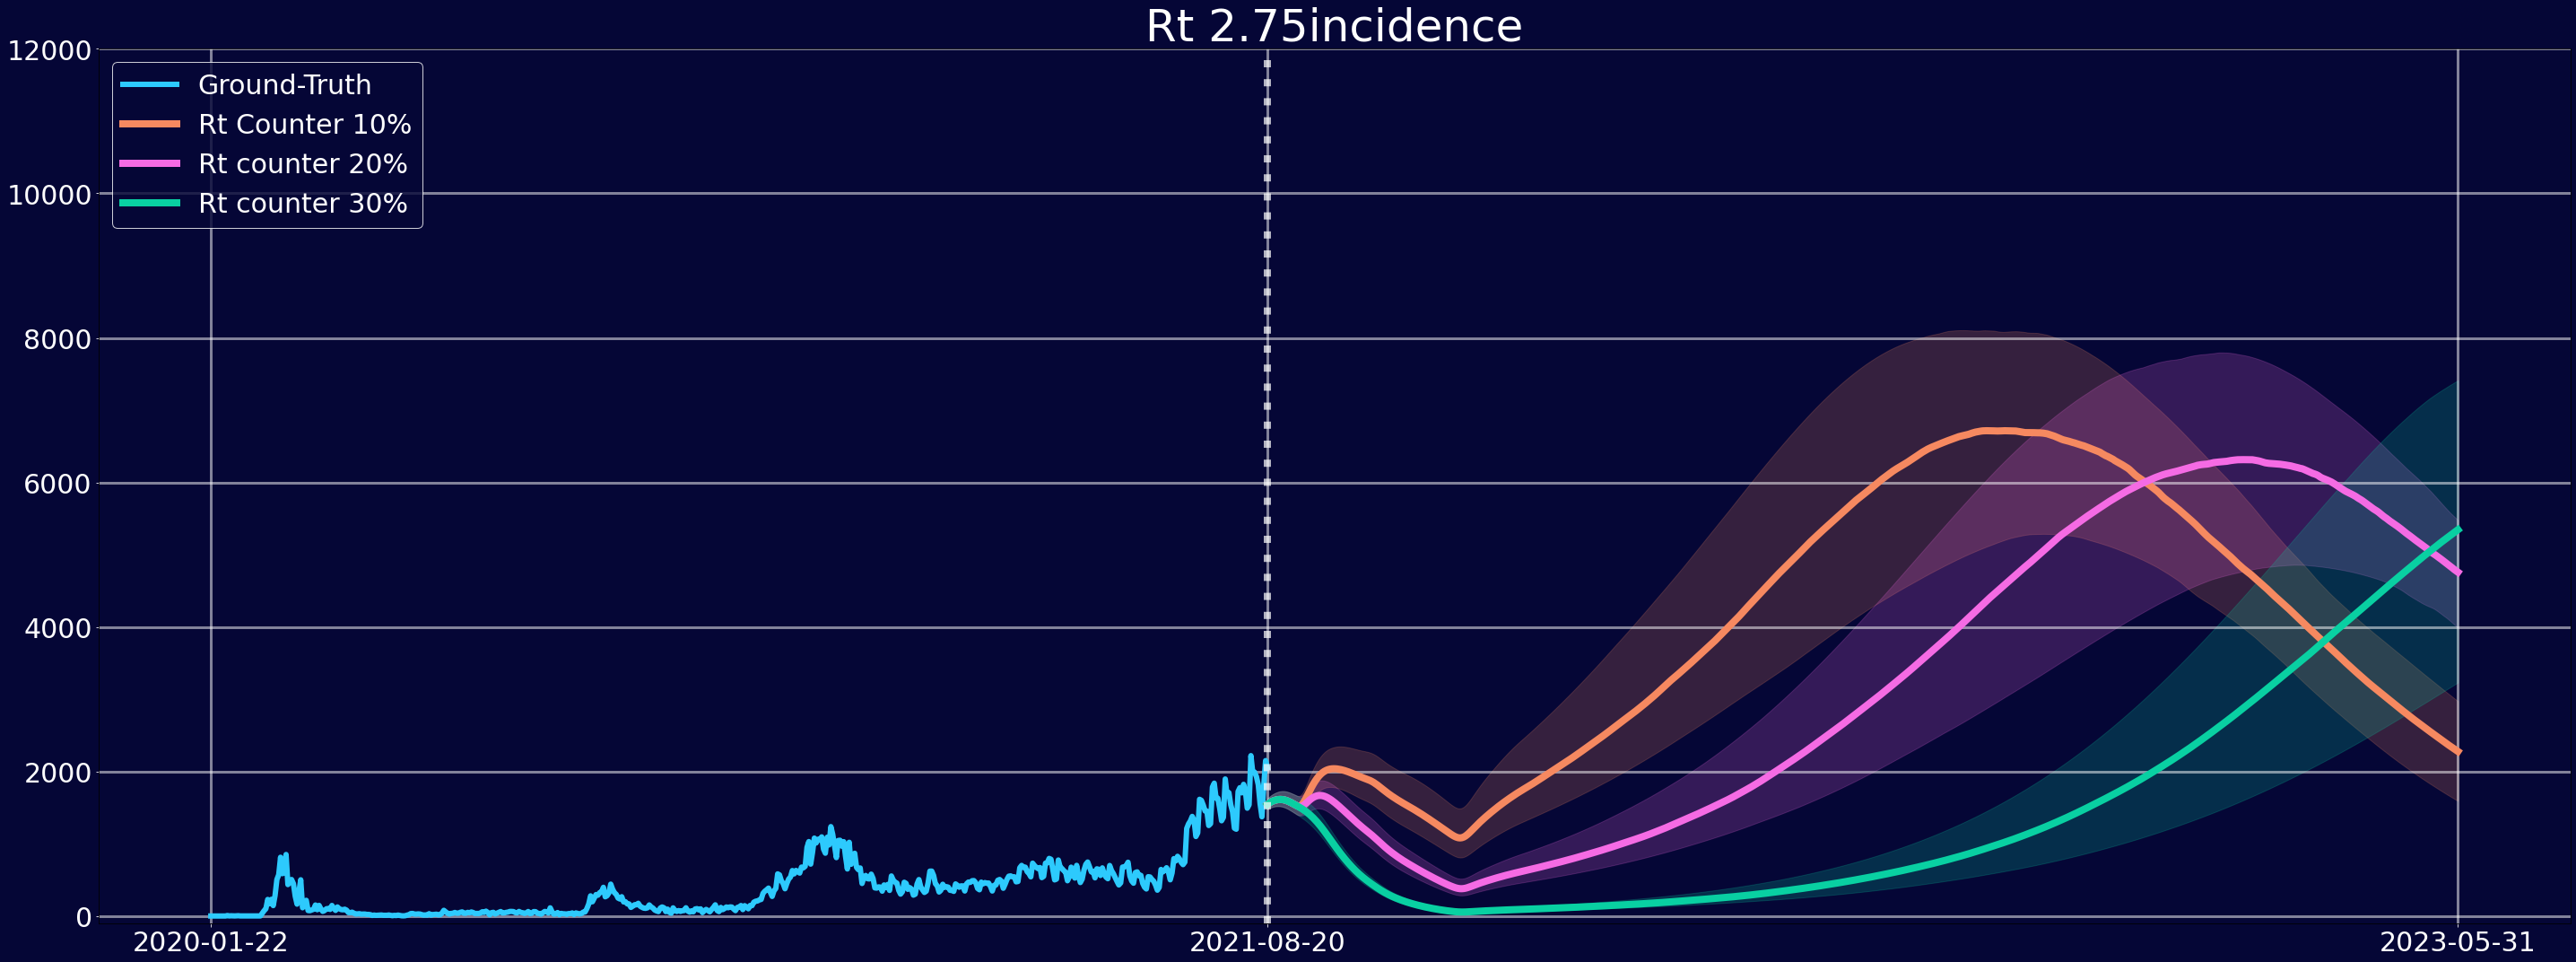

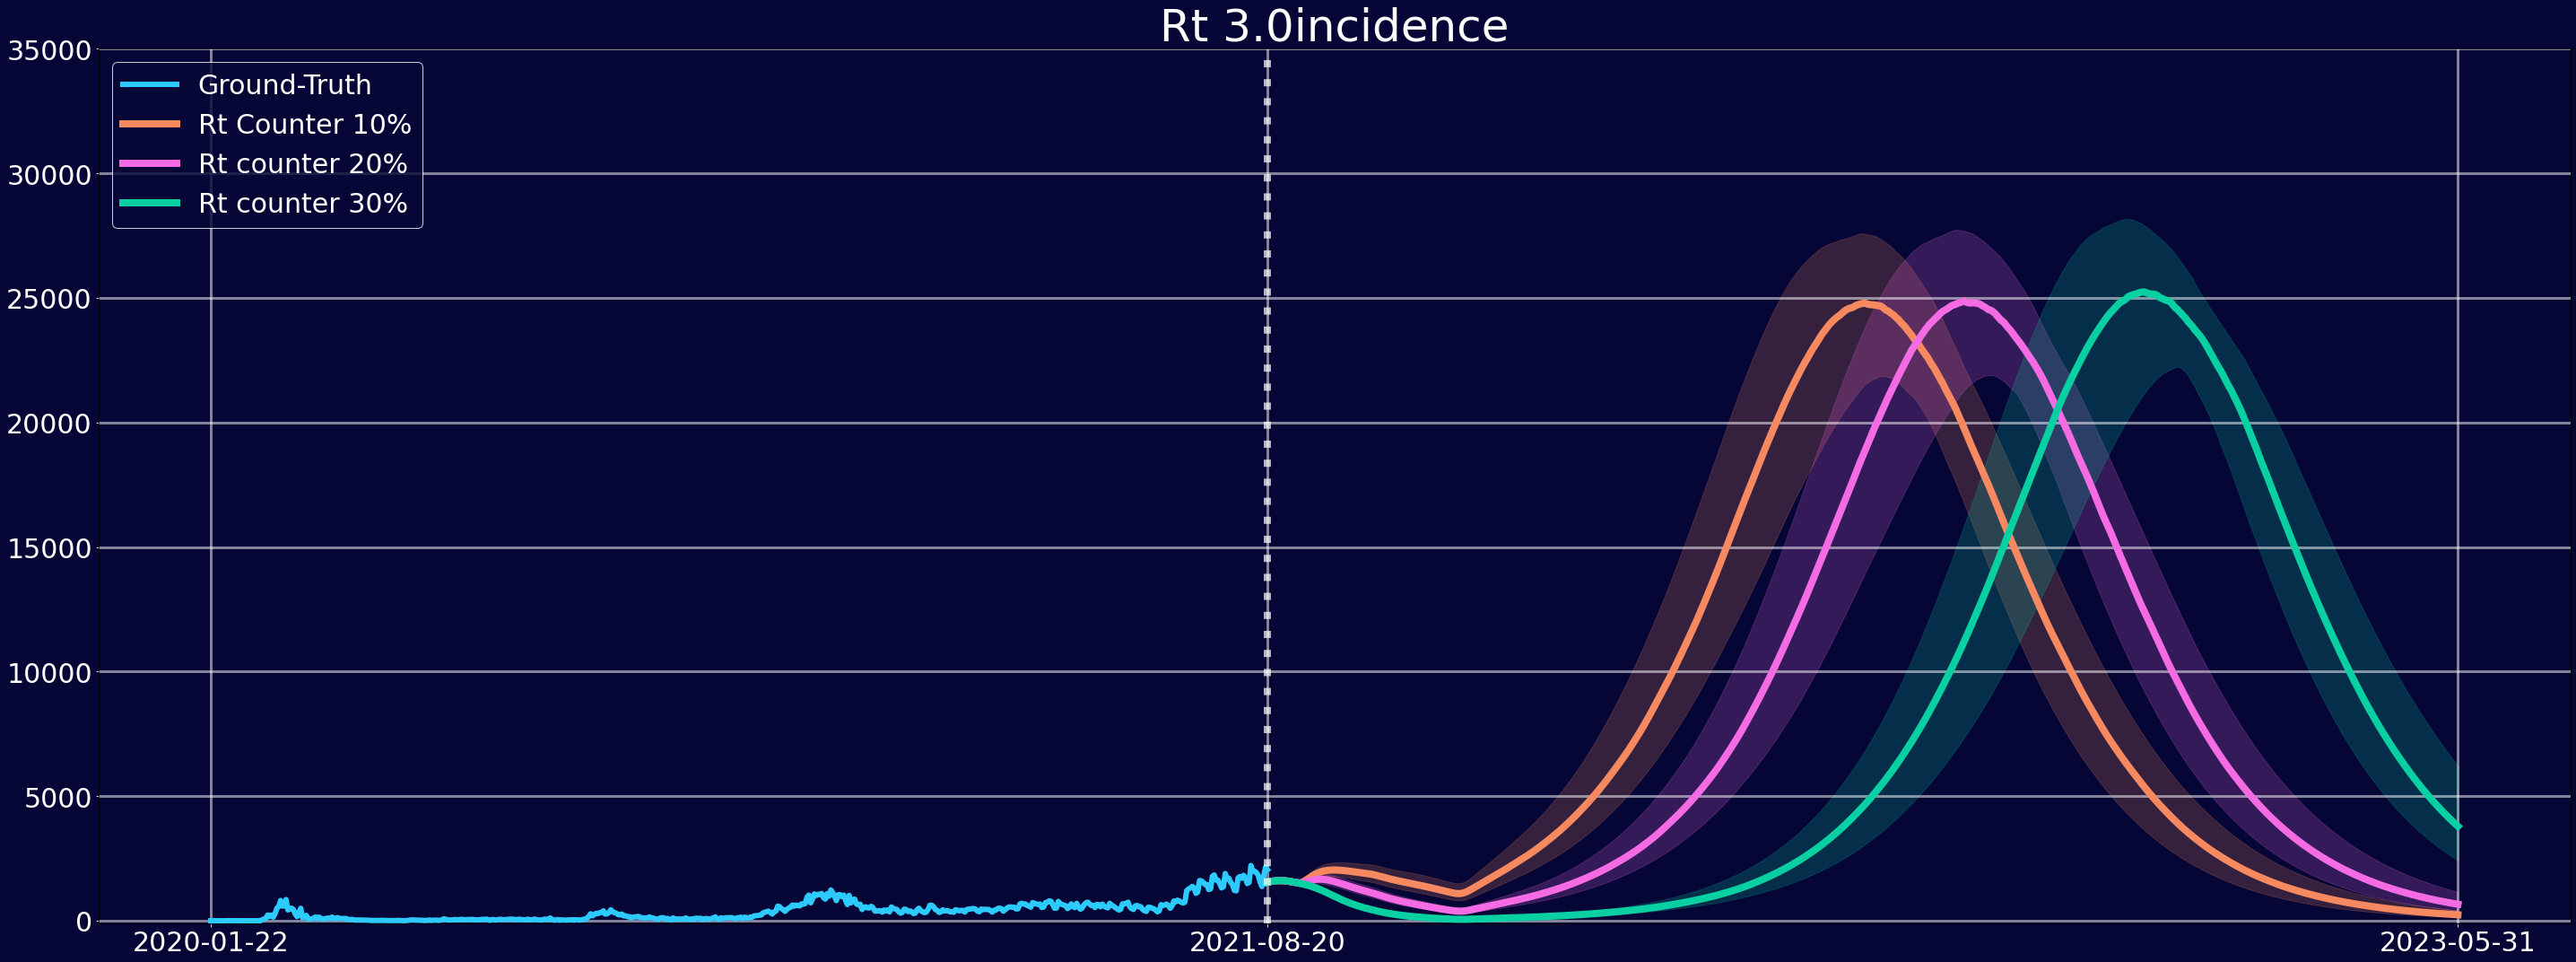

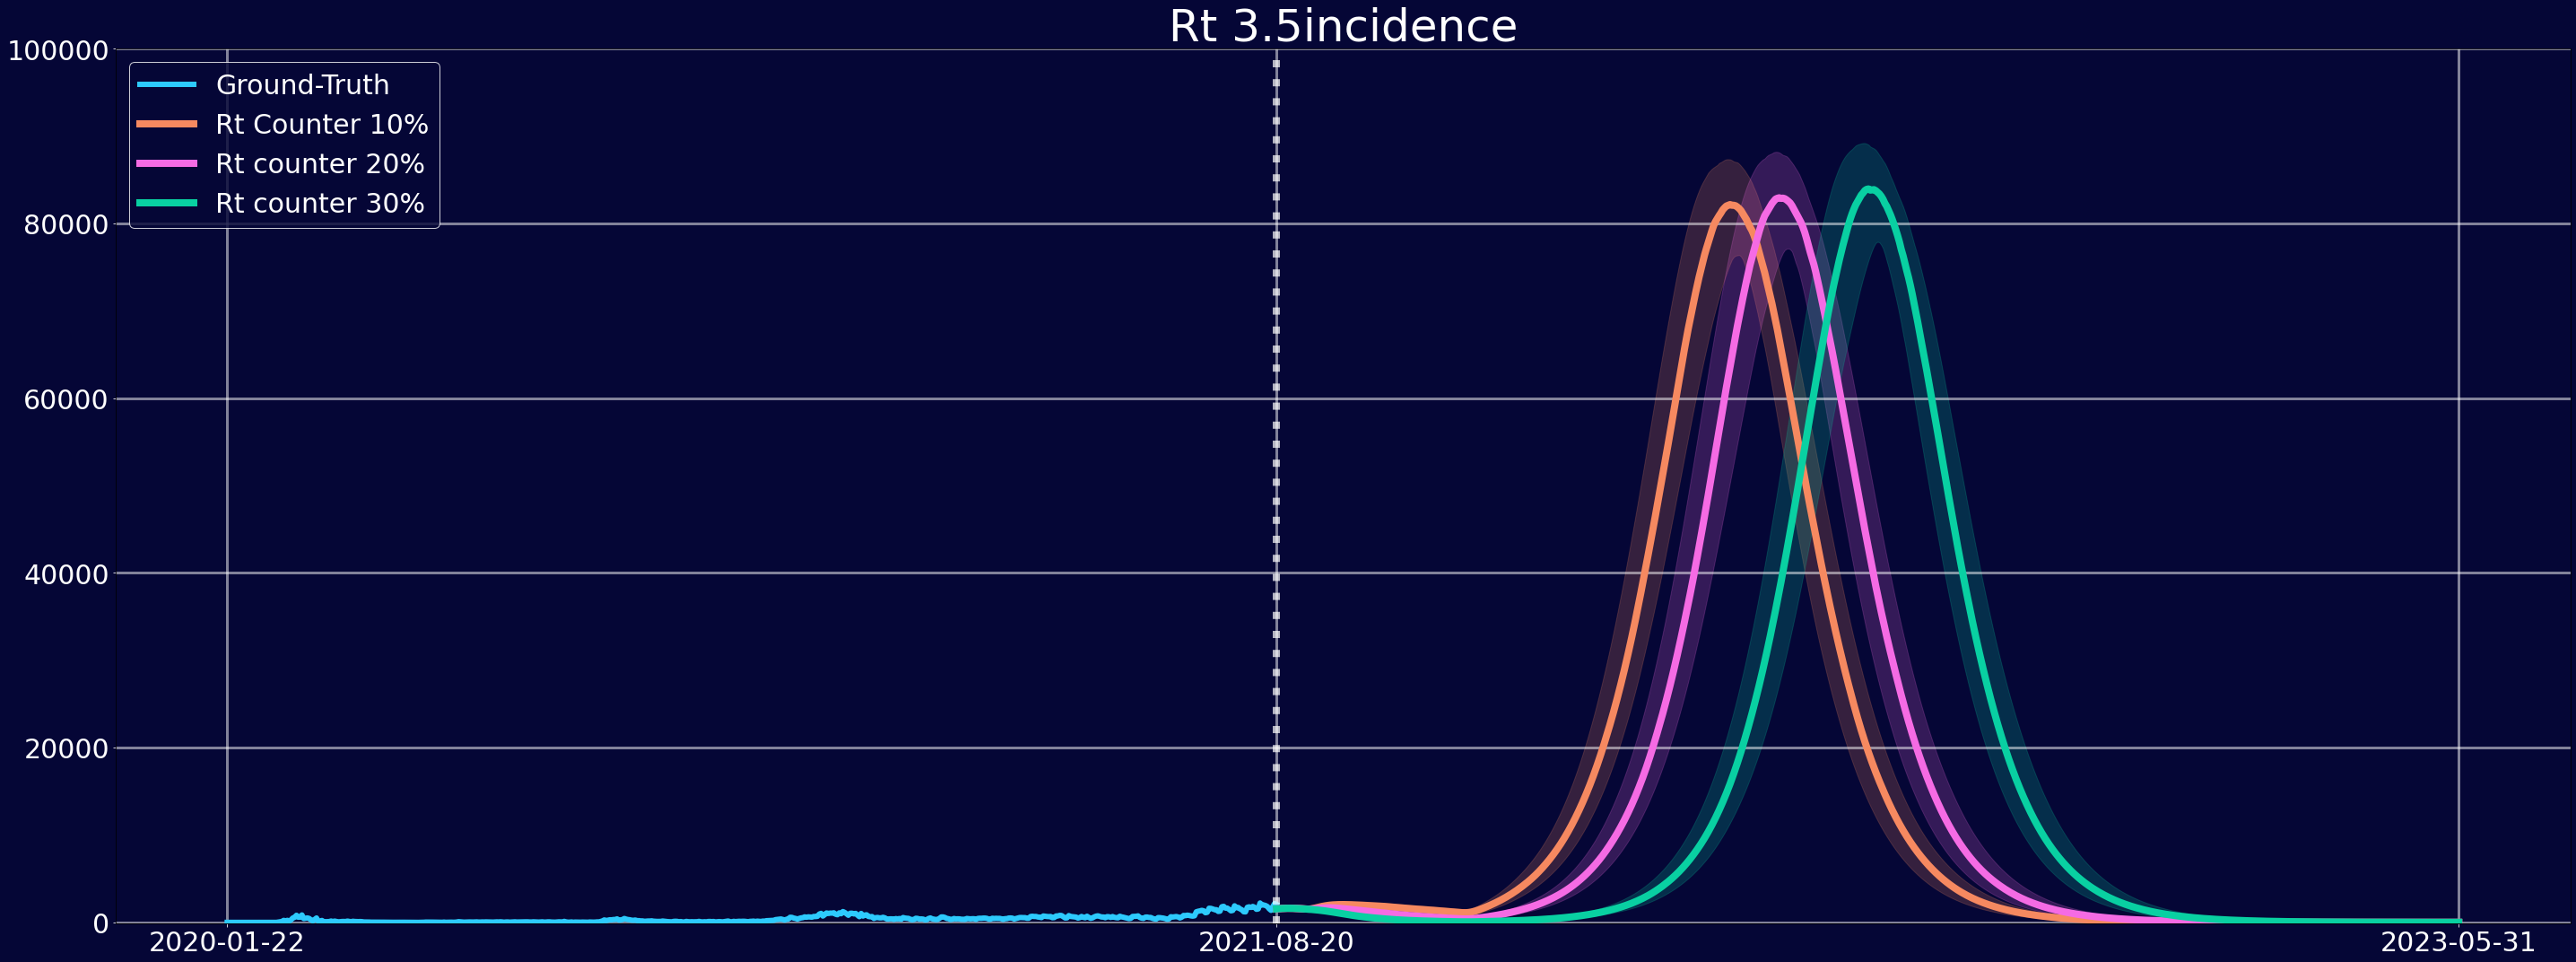

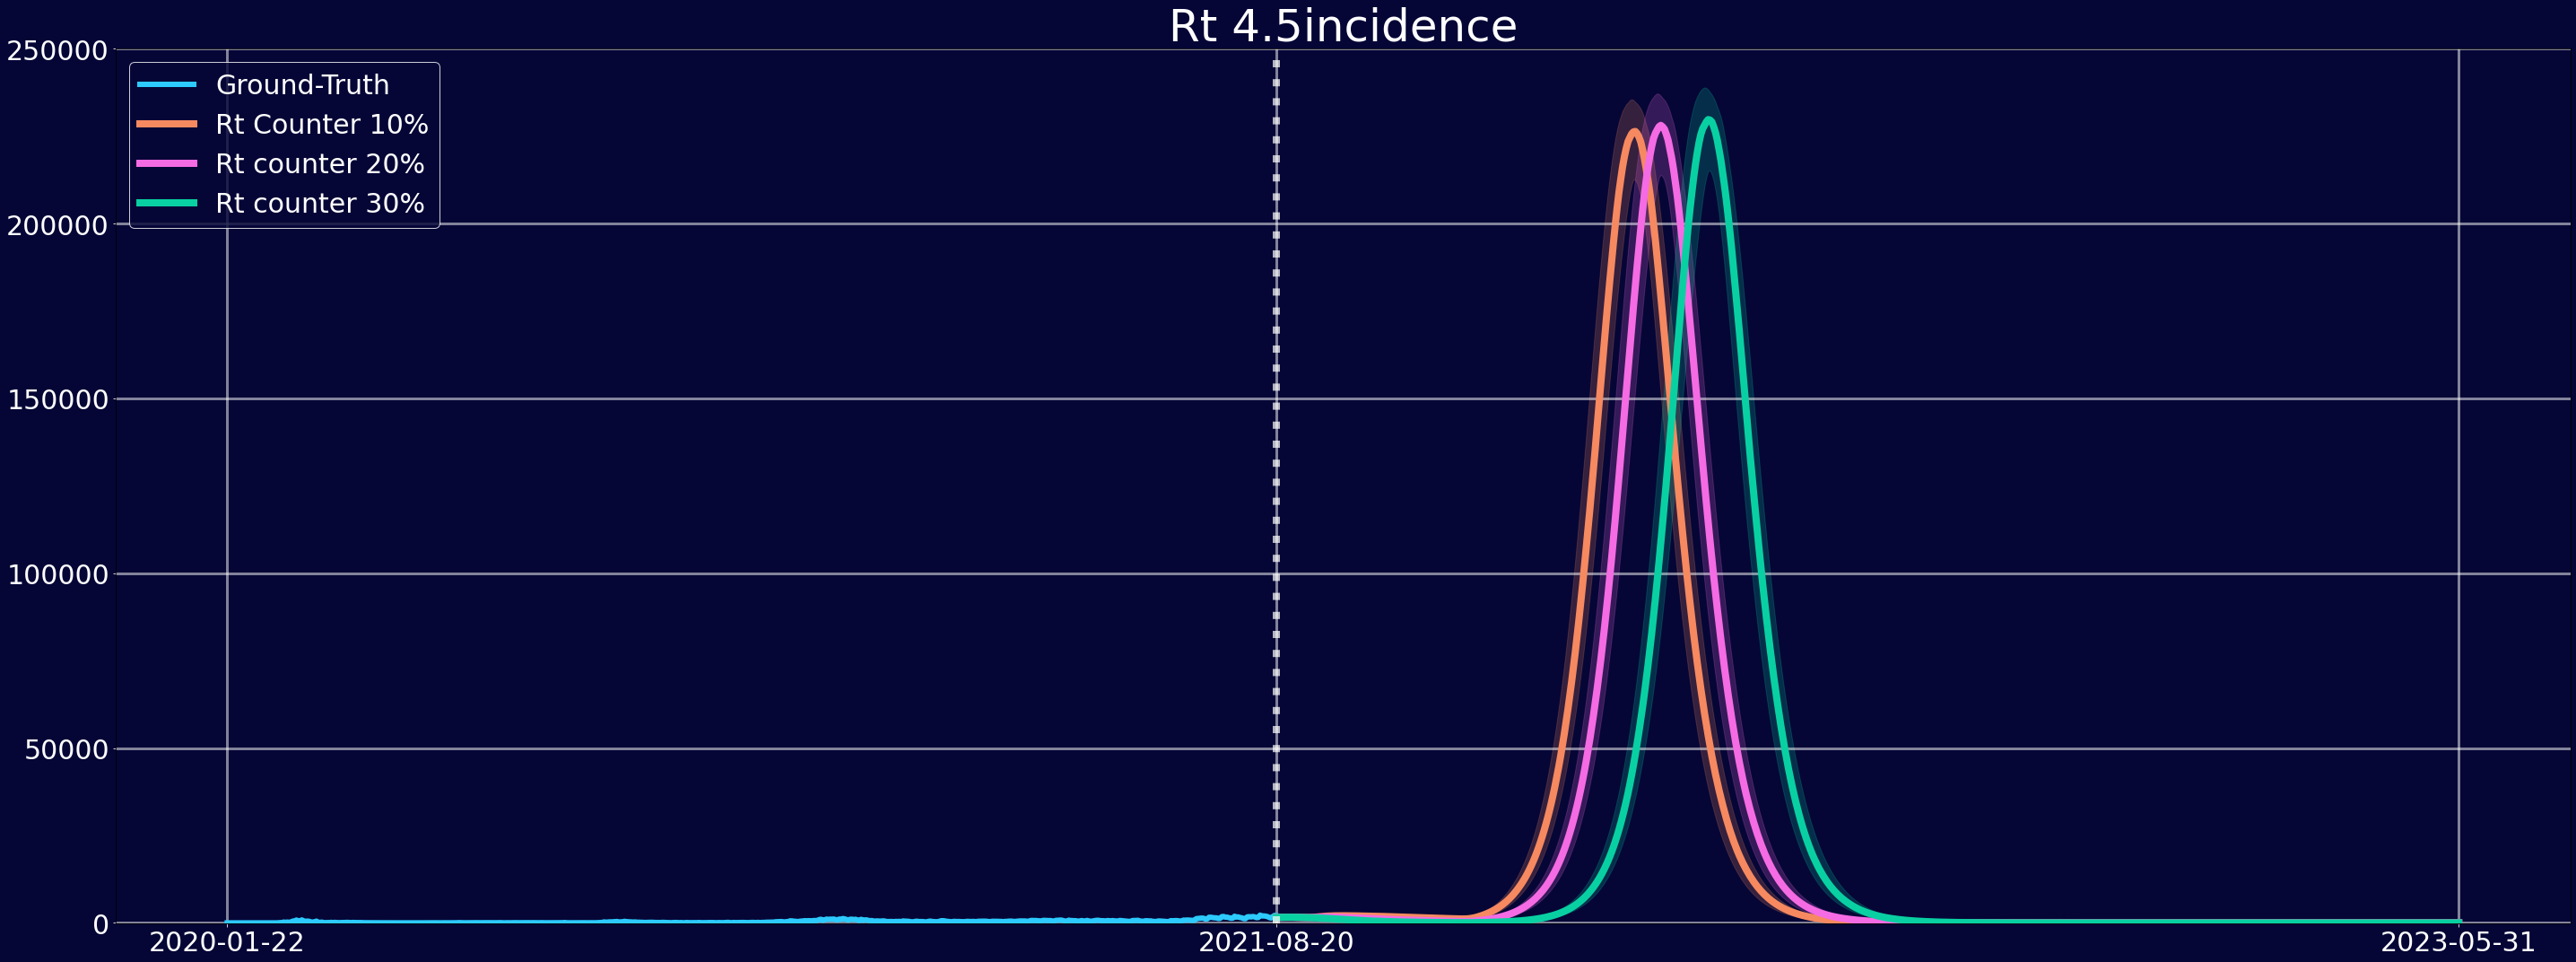

In [25]:
# rt_0_case = rt_0_case[rt_0_case['Date']>=pre_date]
# rt_1_case = rt_1_case[rt_1_case['Date']>=pre_date]
# rt_2_case = rt_2_case[rt_2_case['Date']>=pre_date]
# rt_3_case = rt_3_case[rt_3_case['Date']>=pre_date]
# rt_4_case = rt_4_case[rt_4_case['Date']>=pre_date]
Original_Plot('incidence',rt_0_case,Rt[0])
Original_Plot('incidence',rt_1_case,Rt[1])
Original_Plot('incidence',rt_2_case,Rt[2])
Original_Plot('incidence',rt_3_case,Rt[3])
Original_Plot('incidence',rt_4_case,Rt[4])

### 중증자

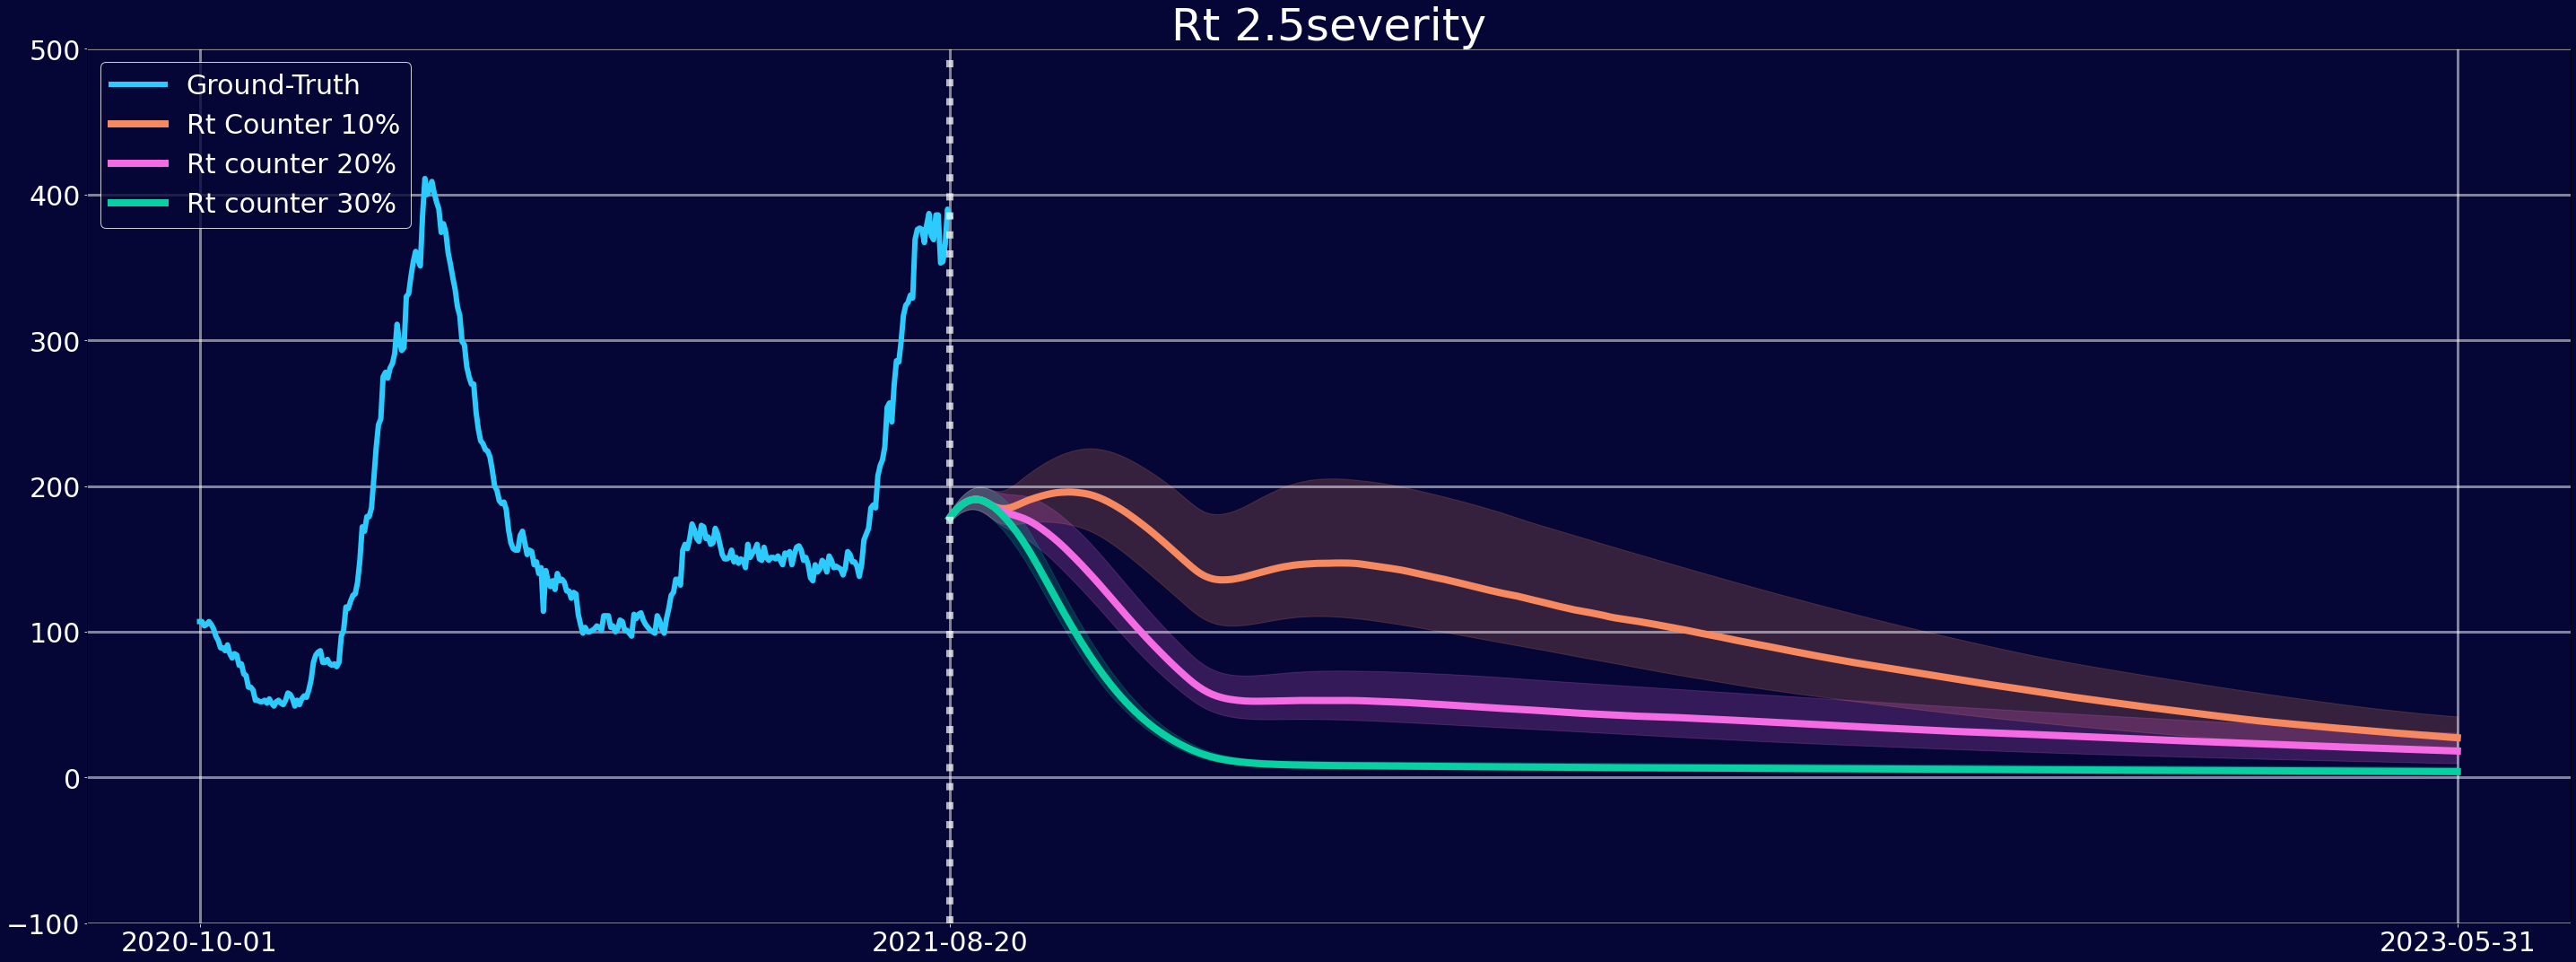

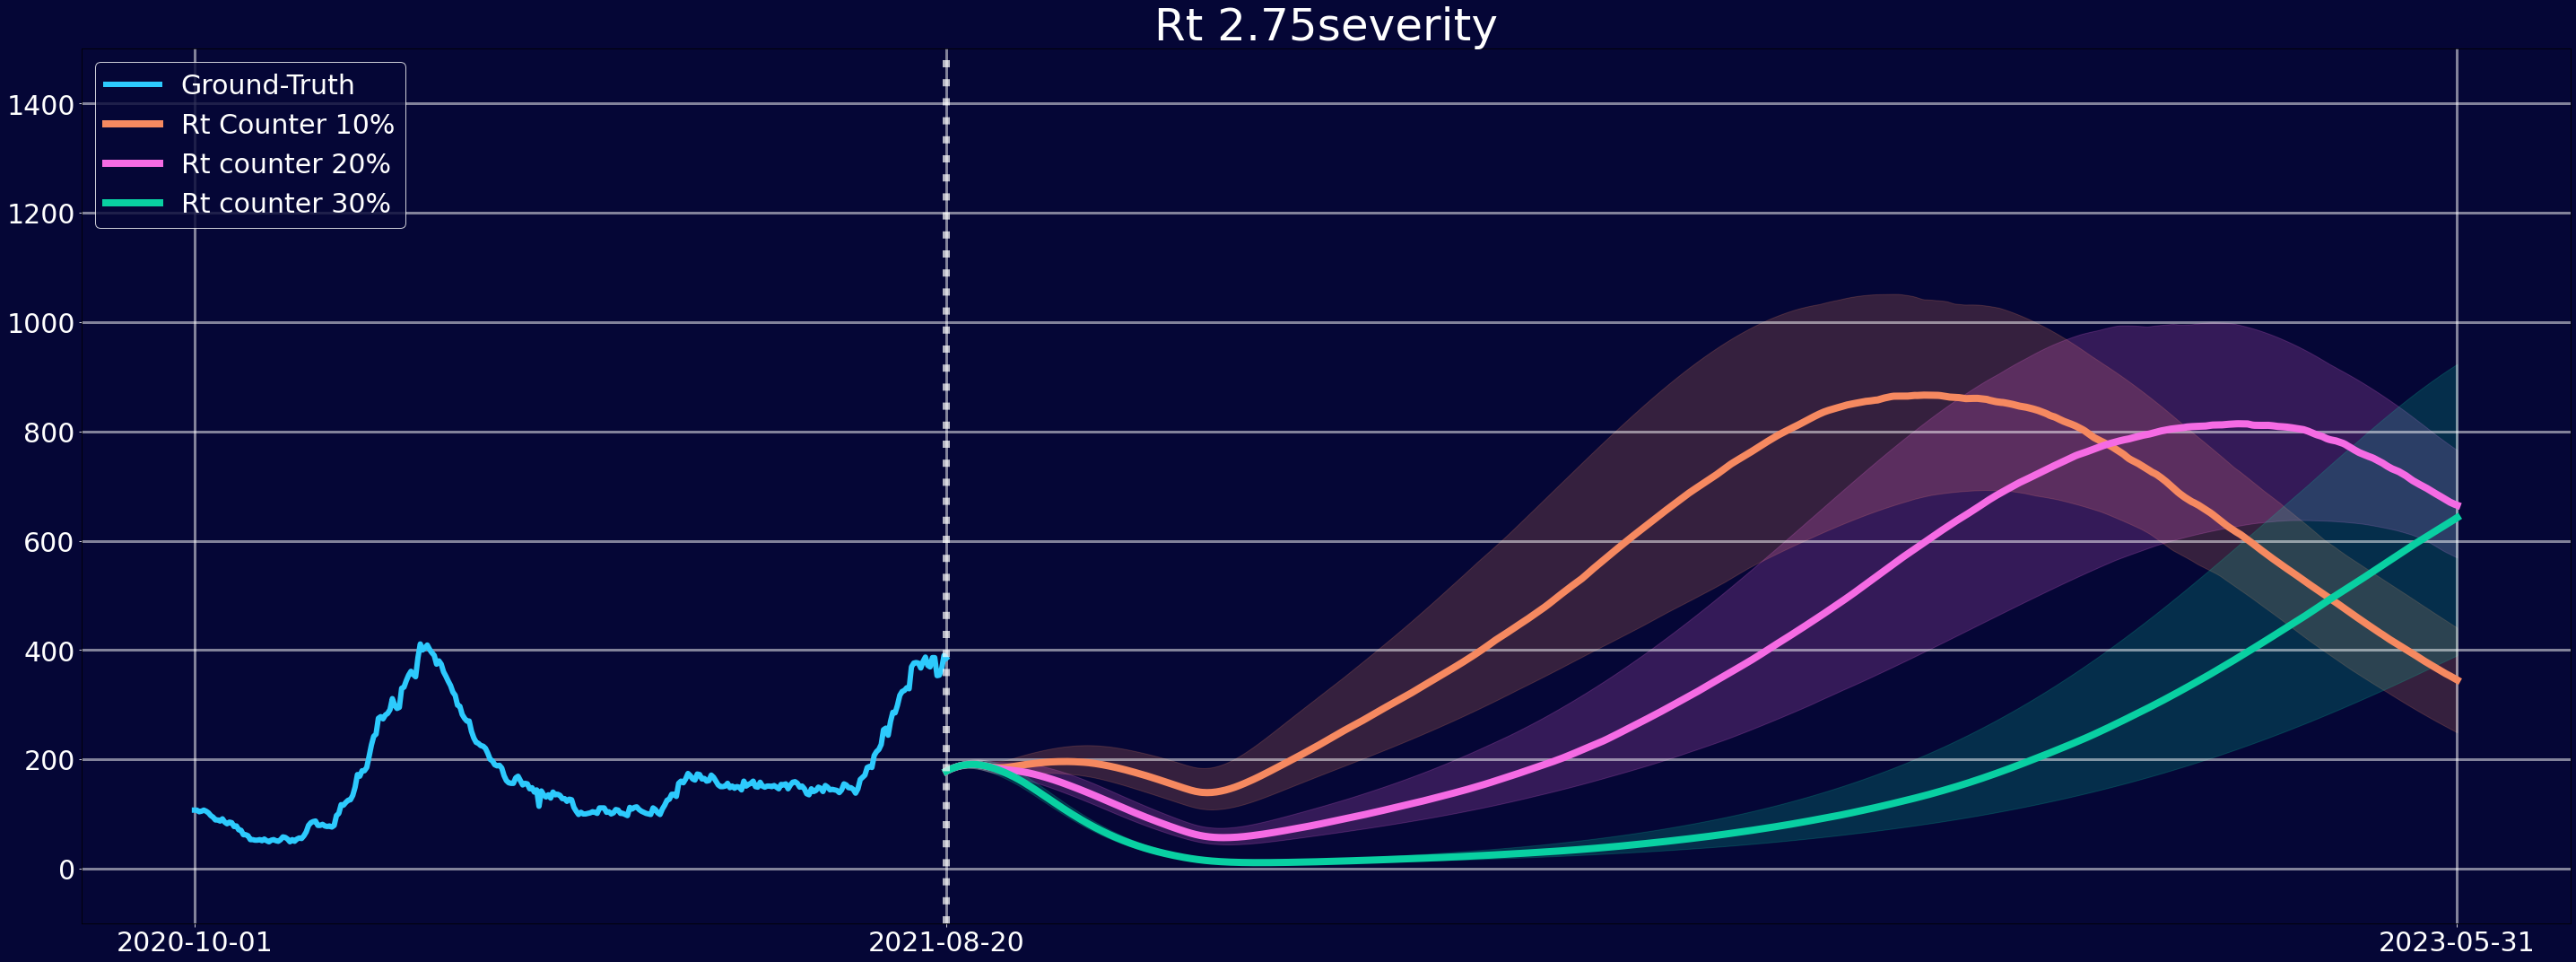

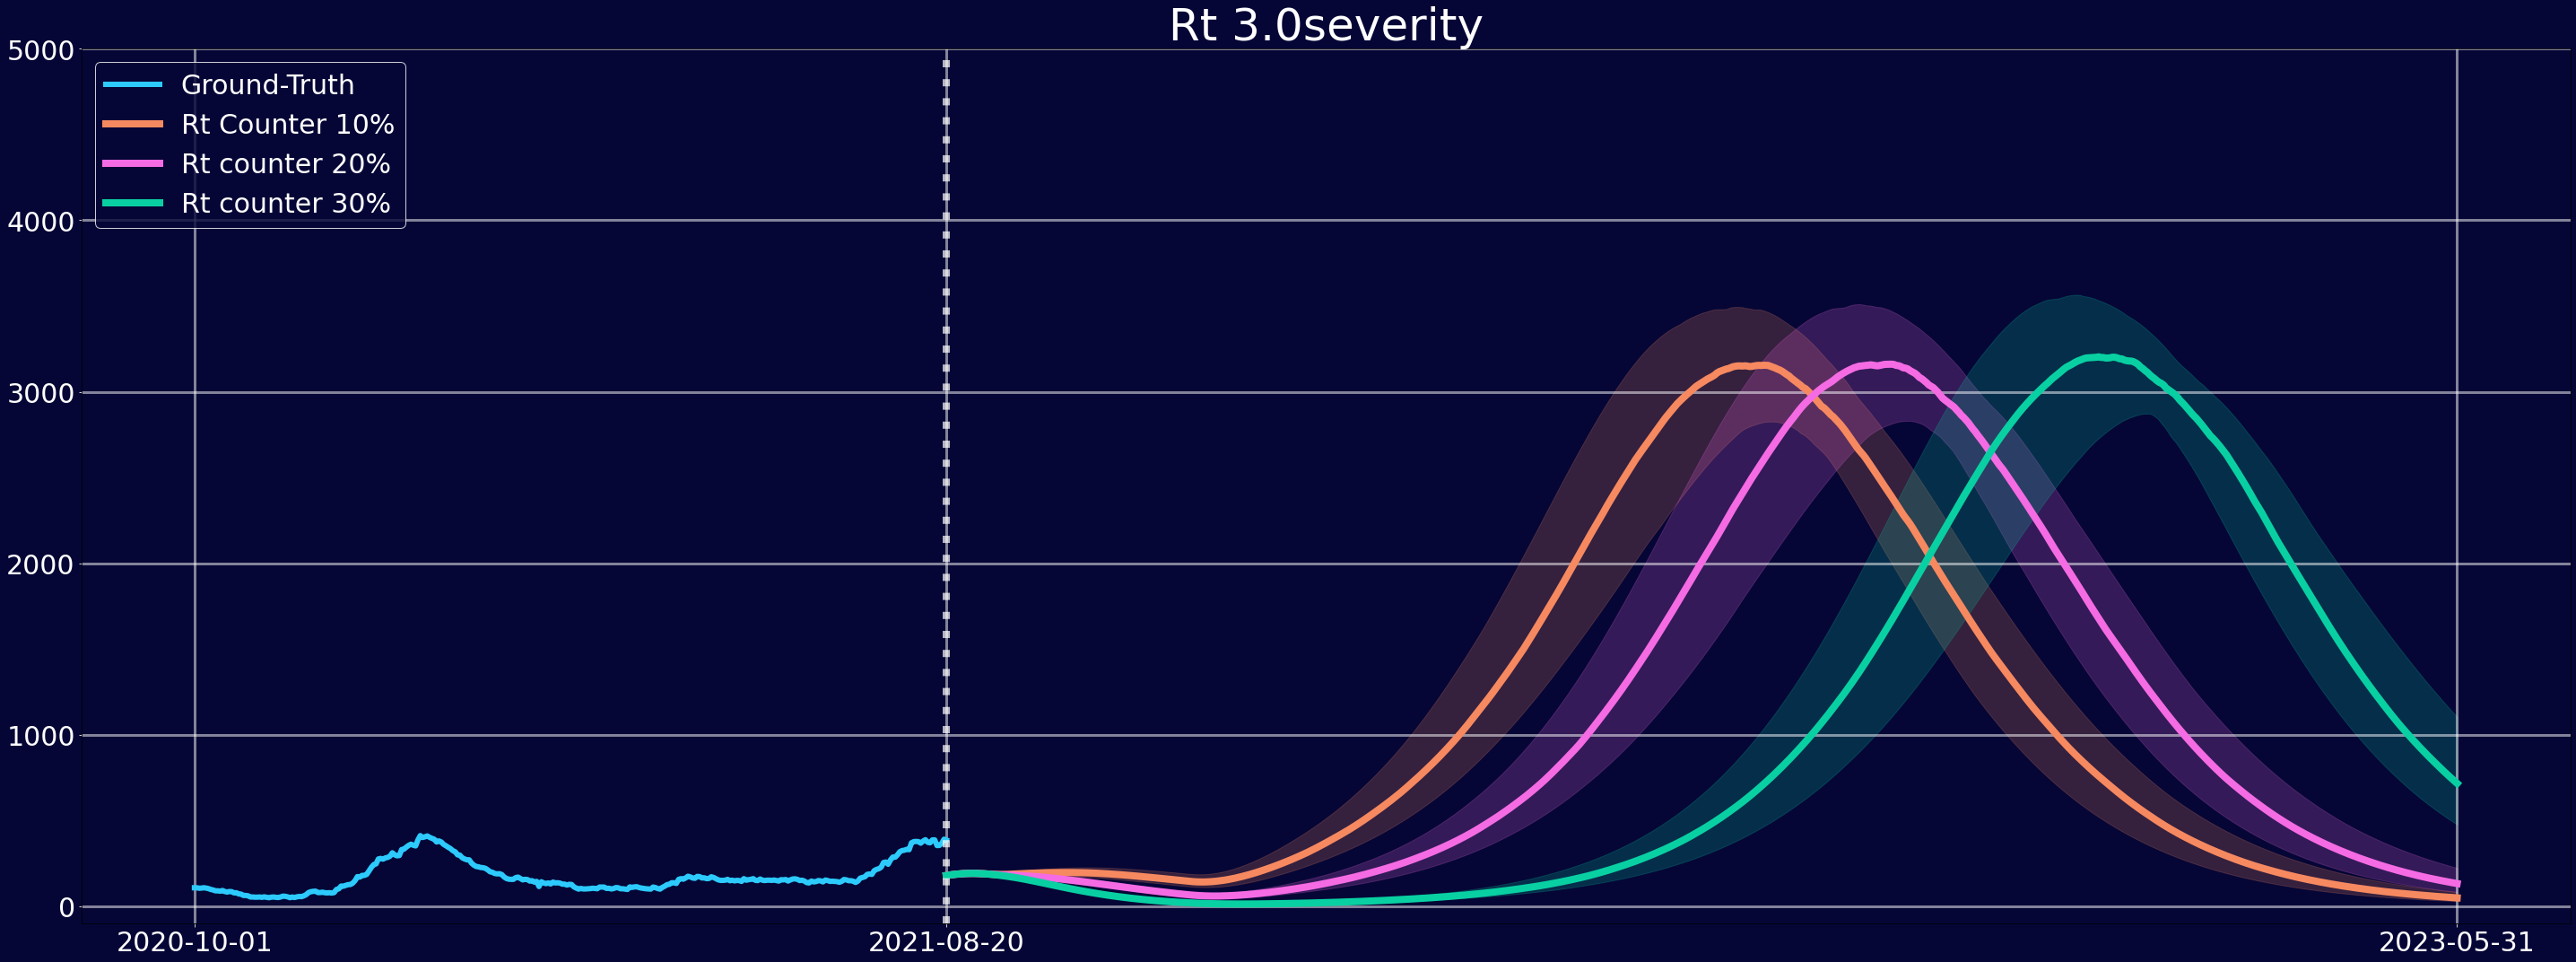

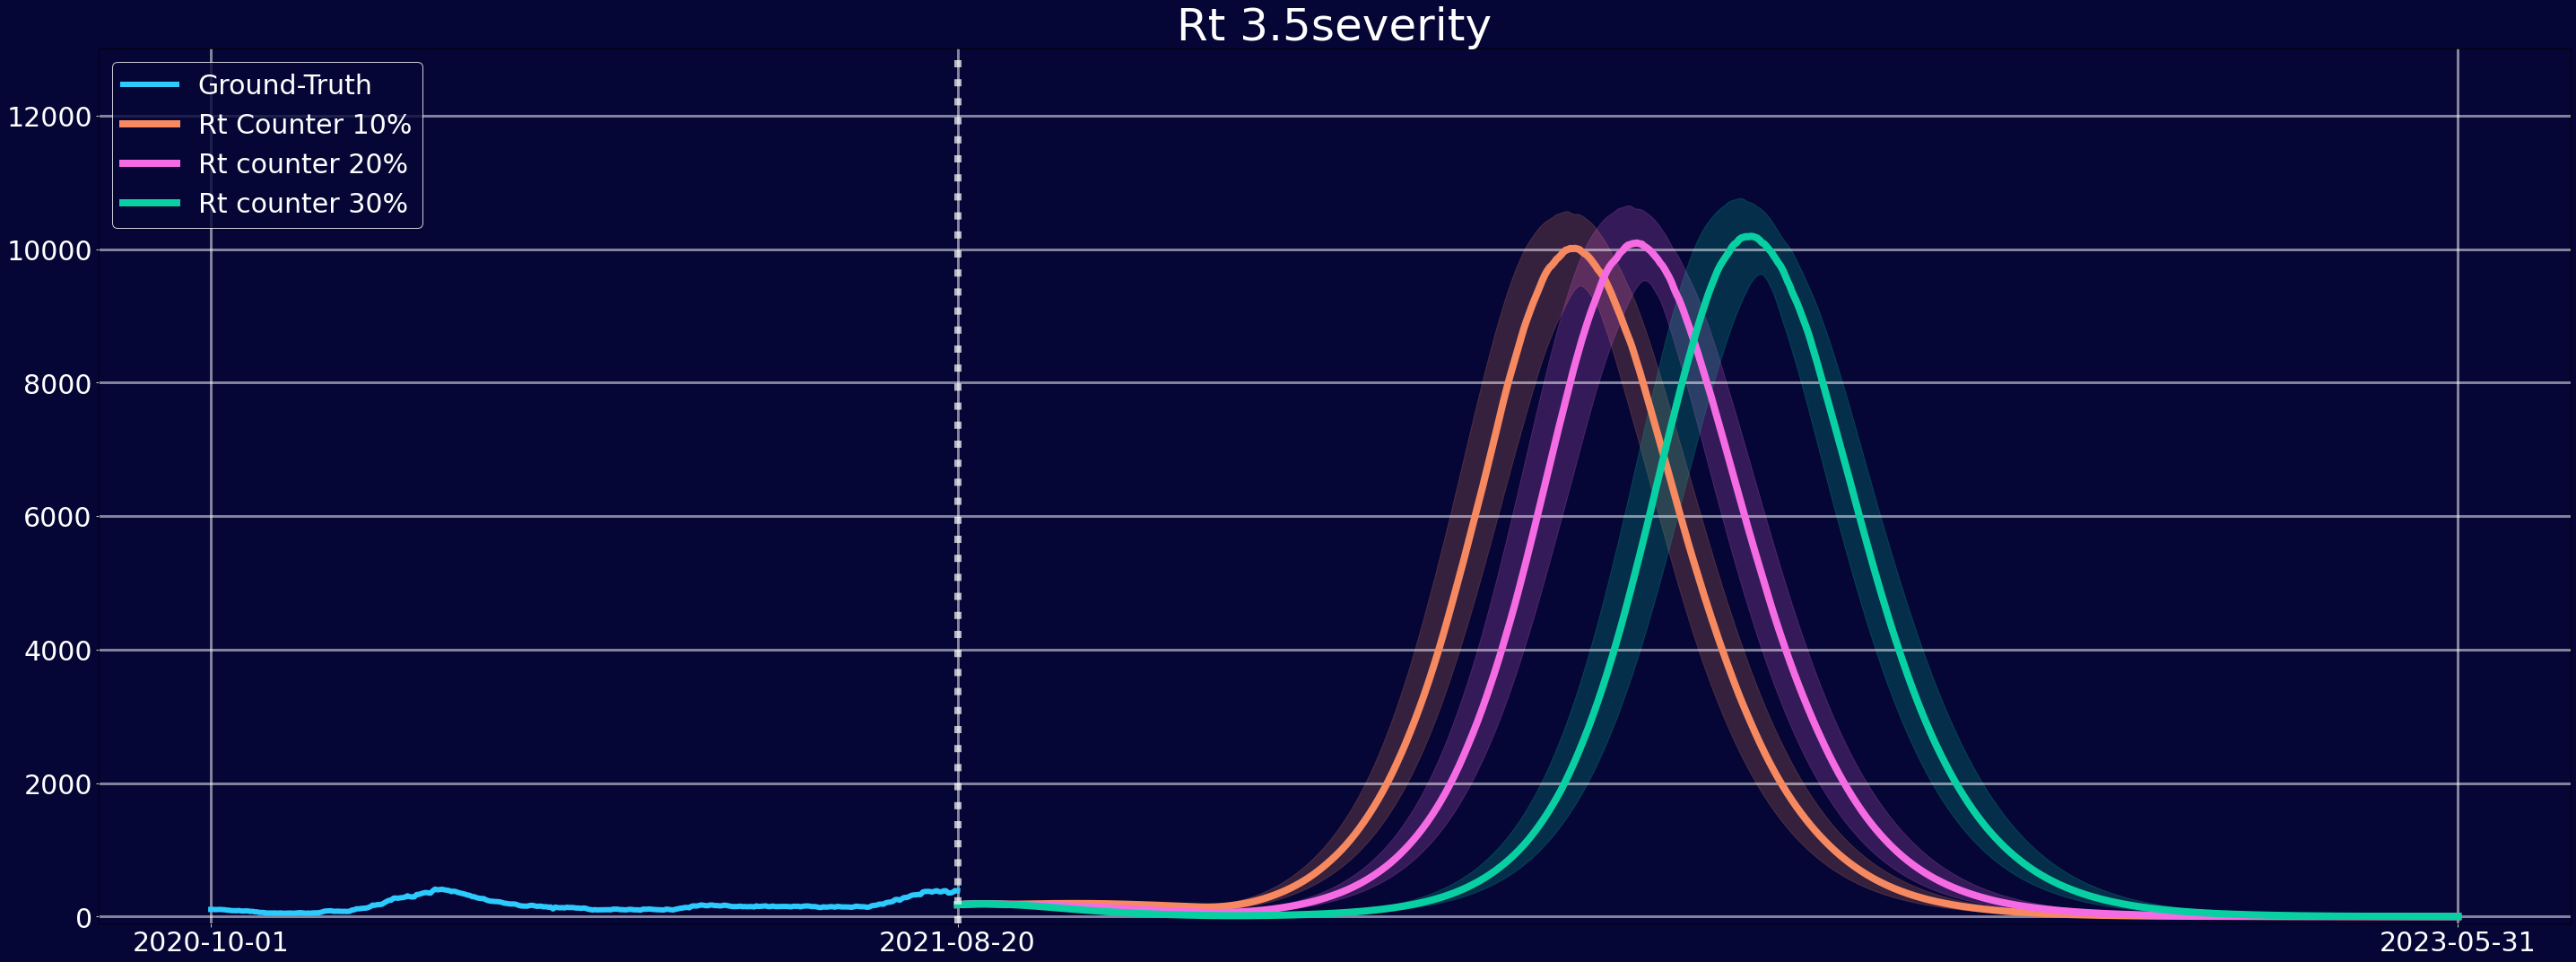

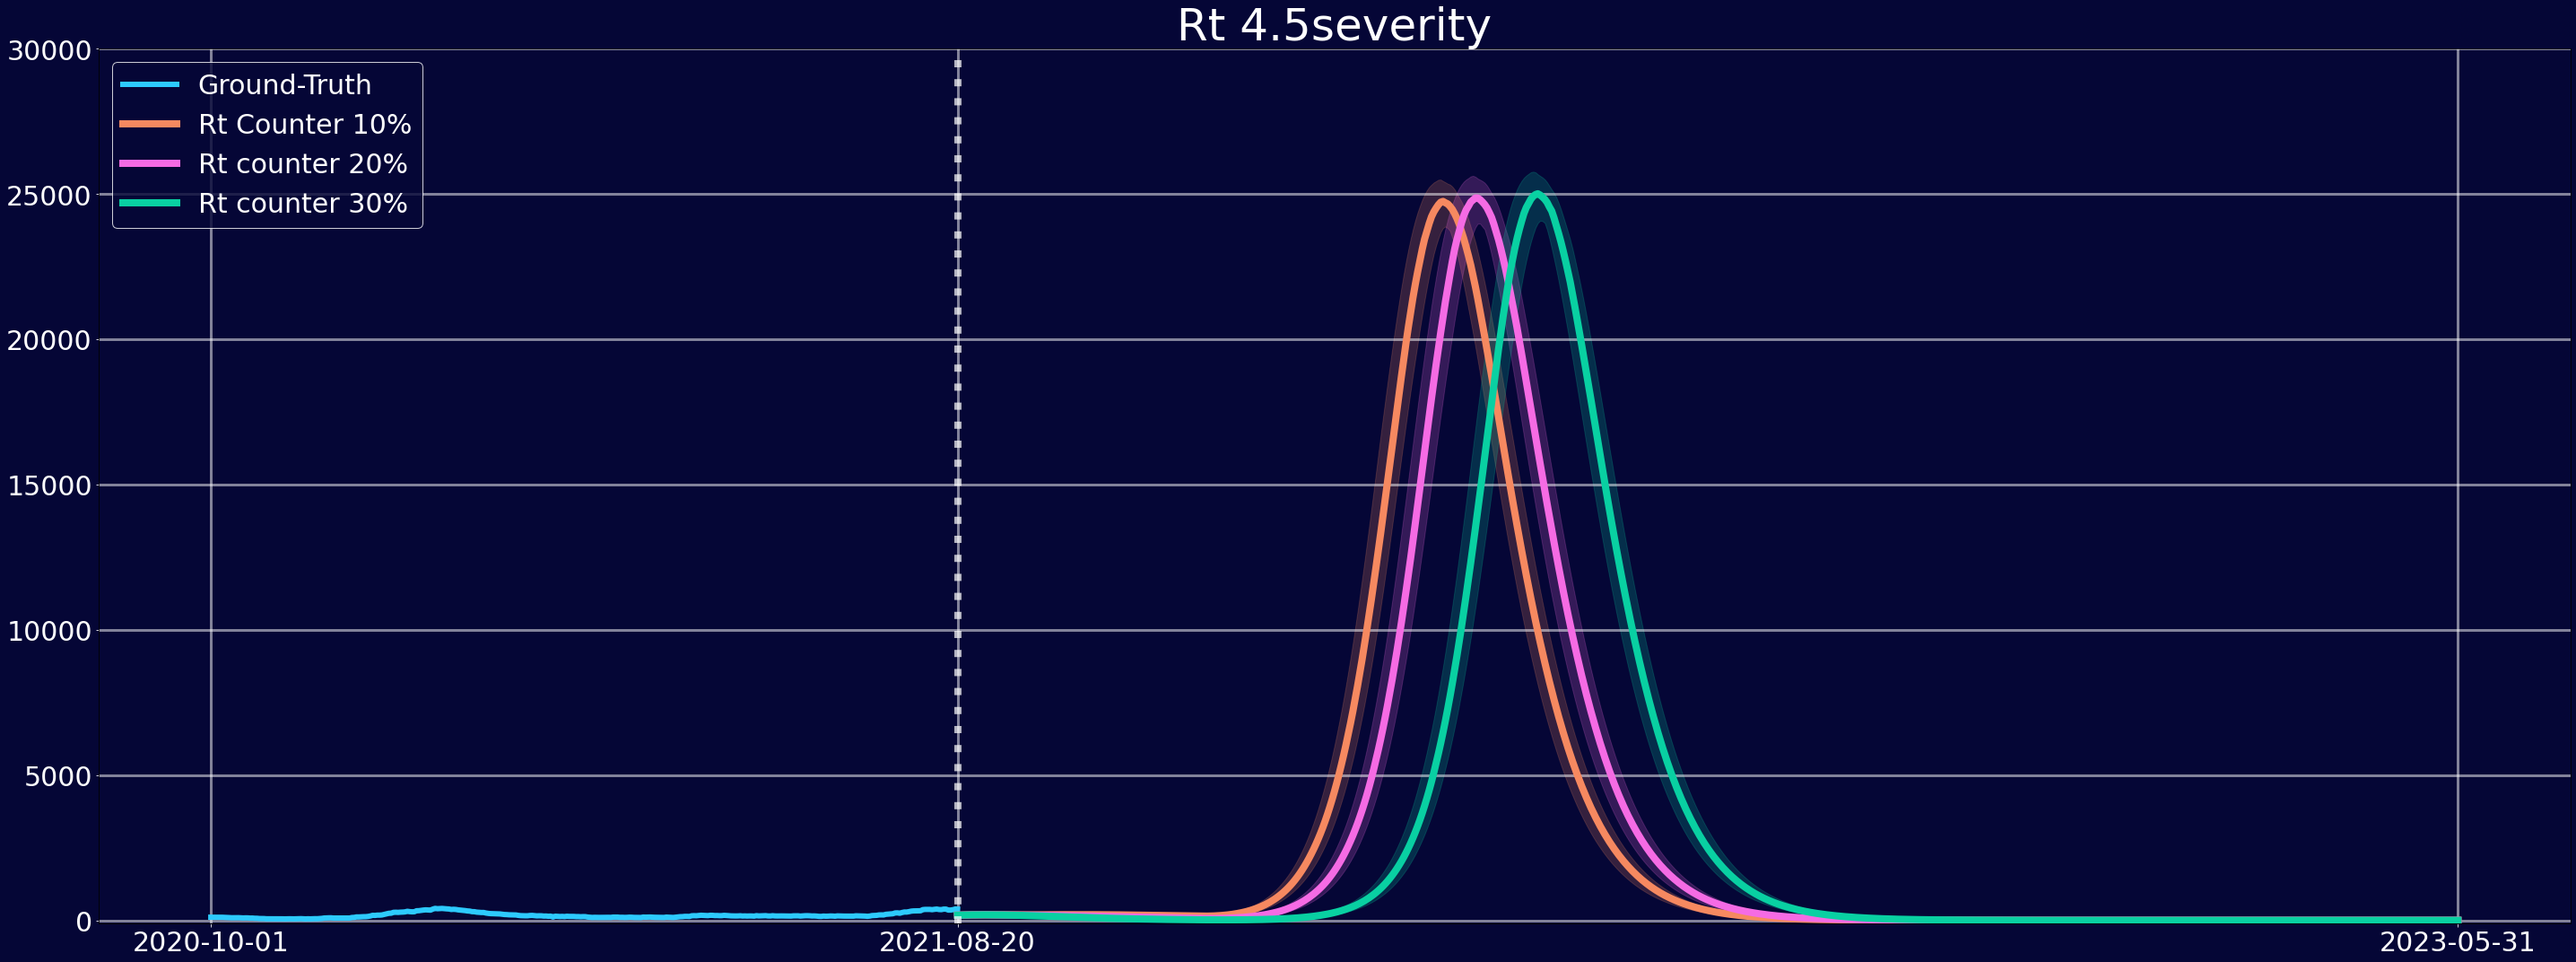

In [26]:
# rt_0_serve = rt_0_serve[rt_0_serve['Date']>=pre_date]
# rt_1_serve = rt_1_serve[rt_1_serve['Date']>=pre_date]
# rt_2_serve = rt_2_serve[rt_2_serve['Date']>=pre_date]
# rt_3_serve = rt_3_serve[rt_3_serve['Date']>=pre_date]
# rt_4_serve = rt_4_serve[rt_4_serve['Date']>=pre_date]
Original_Plot('severity',rt_0_serve,Rt[0])
Original_Plot('severity',rt_1_serve,Rt[1])
Original_Plot('severity',rt_2_serve,Rt[2])
Original_Plot('severity',rt_3_serve,Rt[3])
Original_Plot('severity',rt_4_serve,Rt[4])

### 사망자

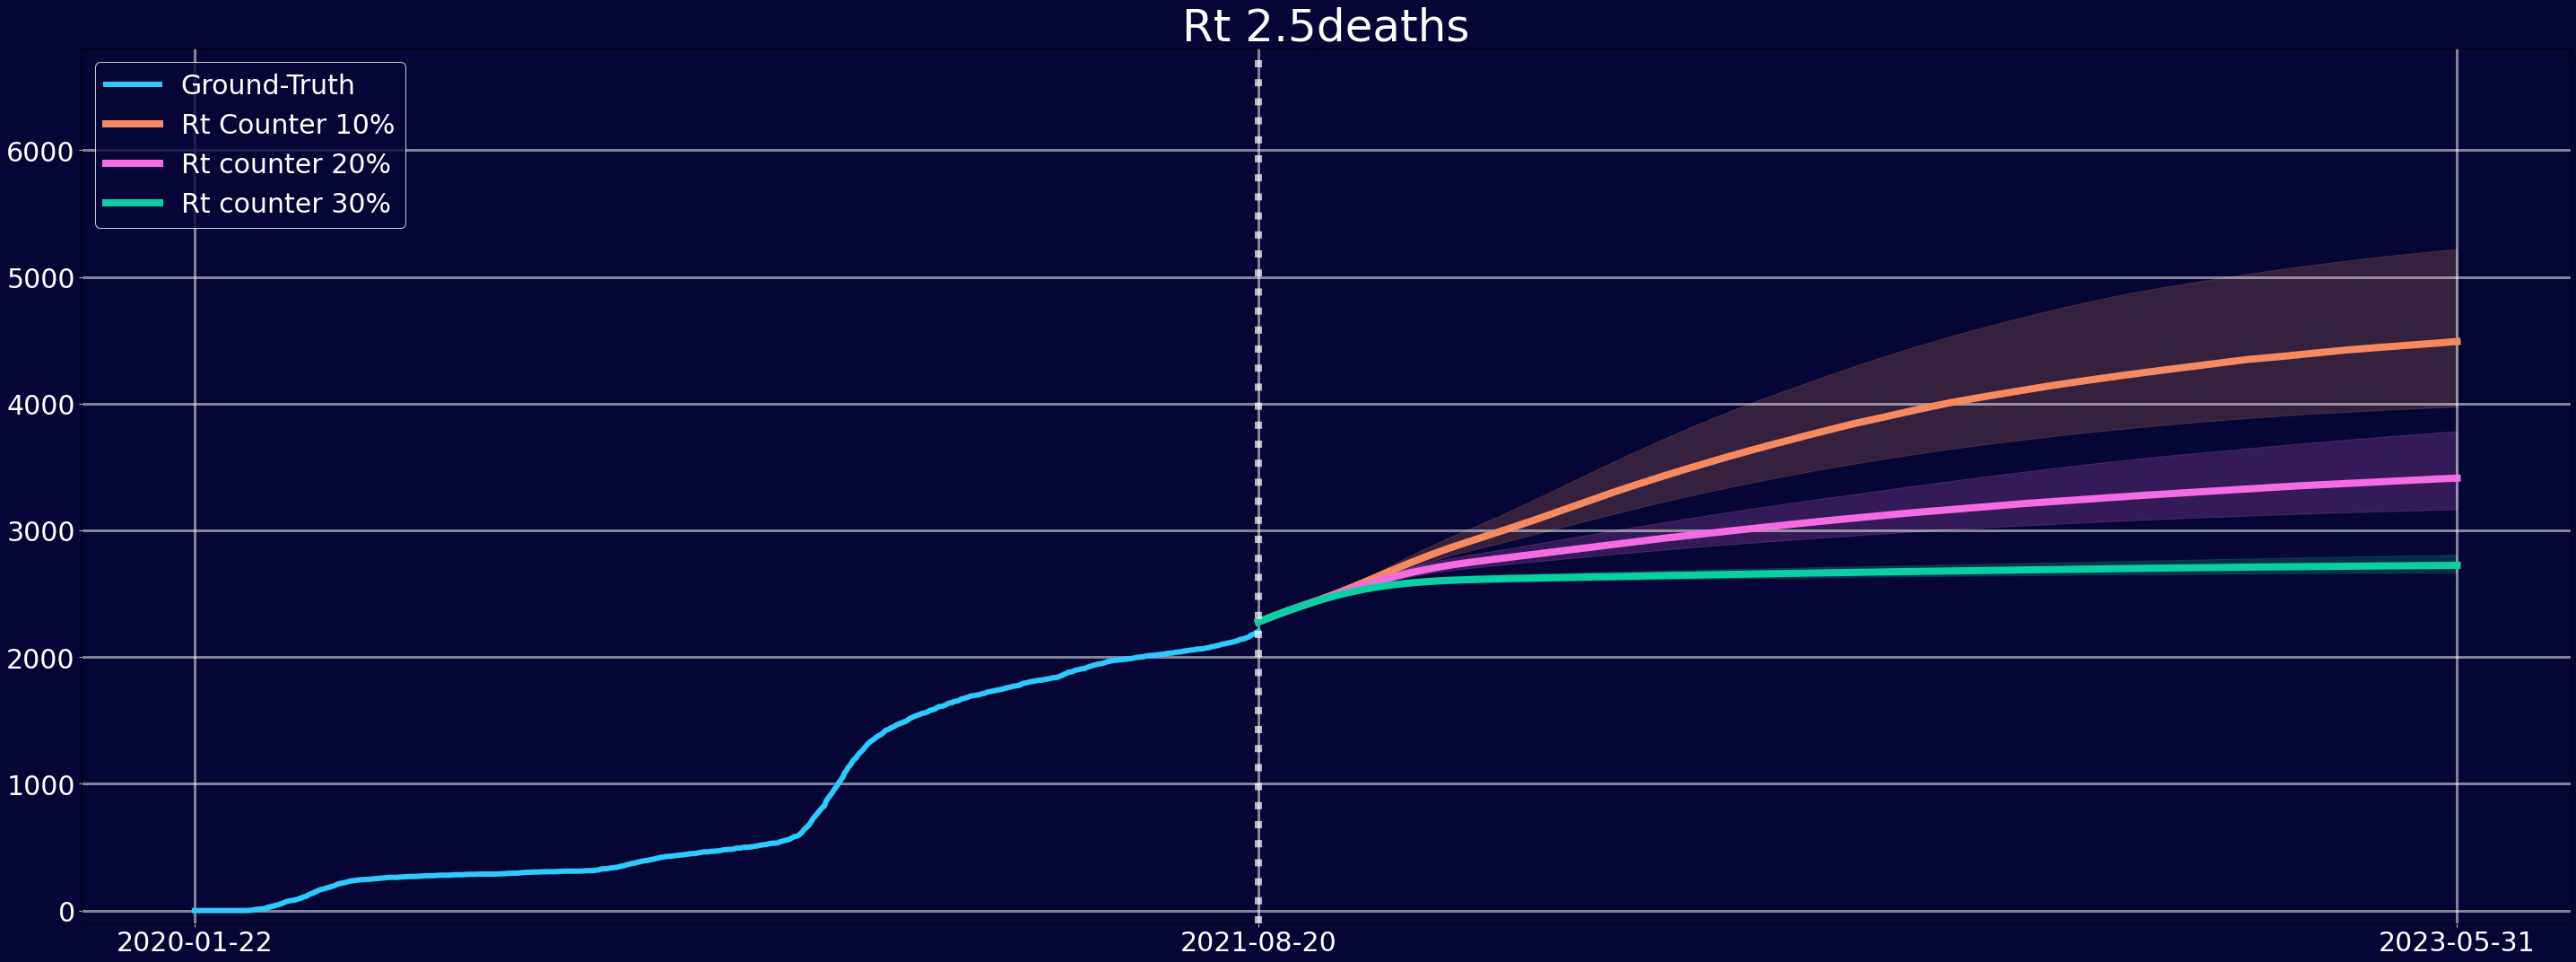

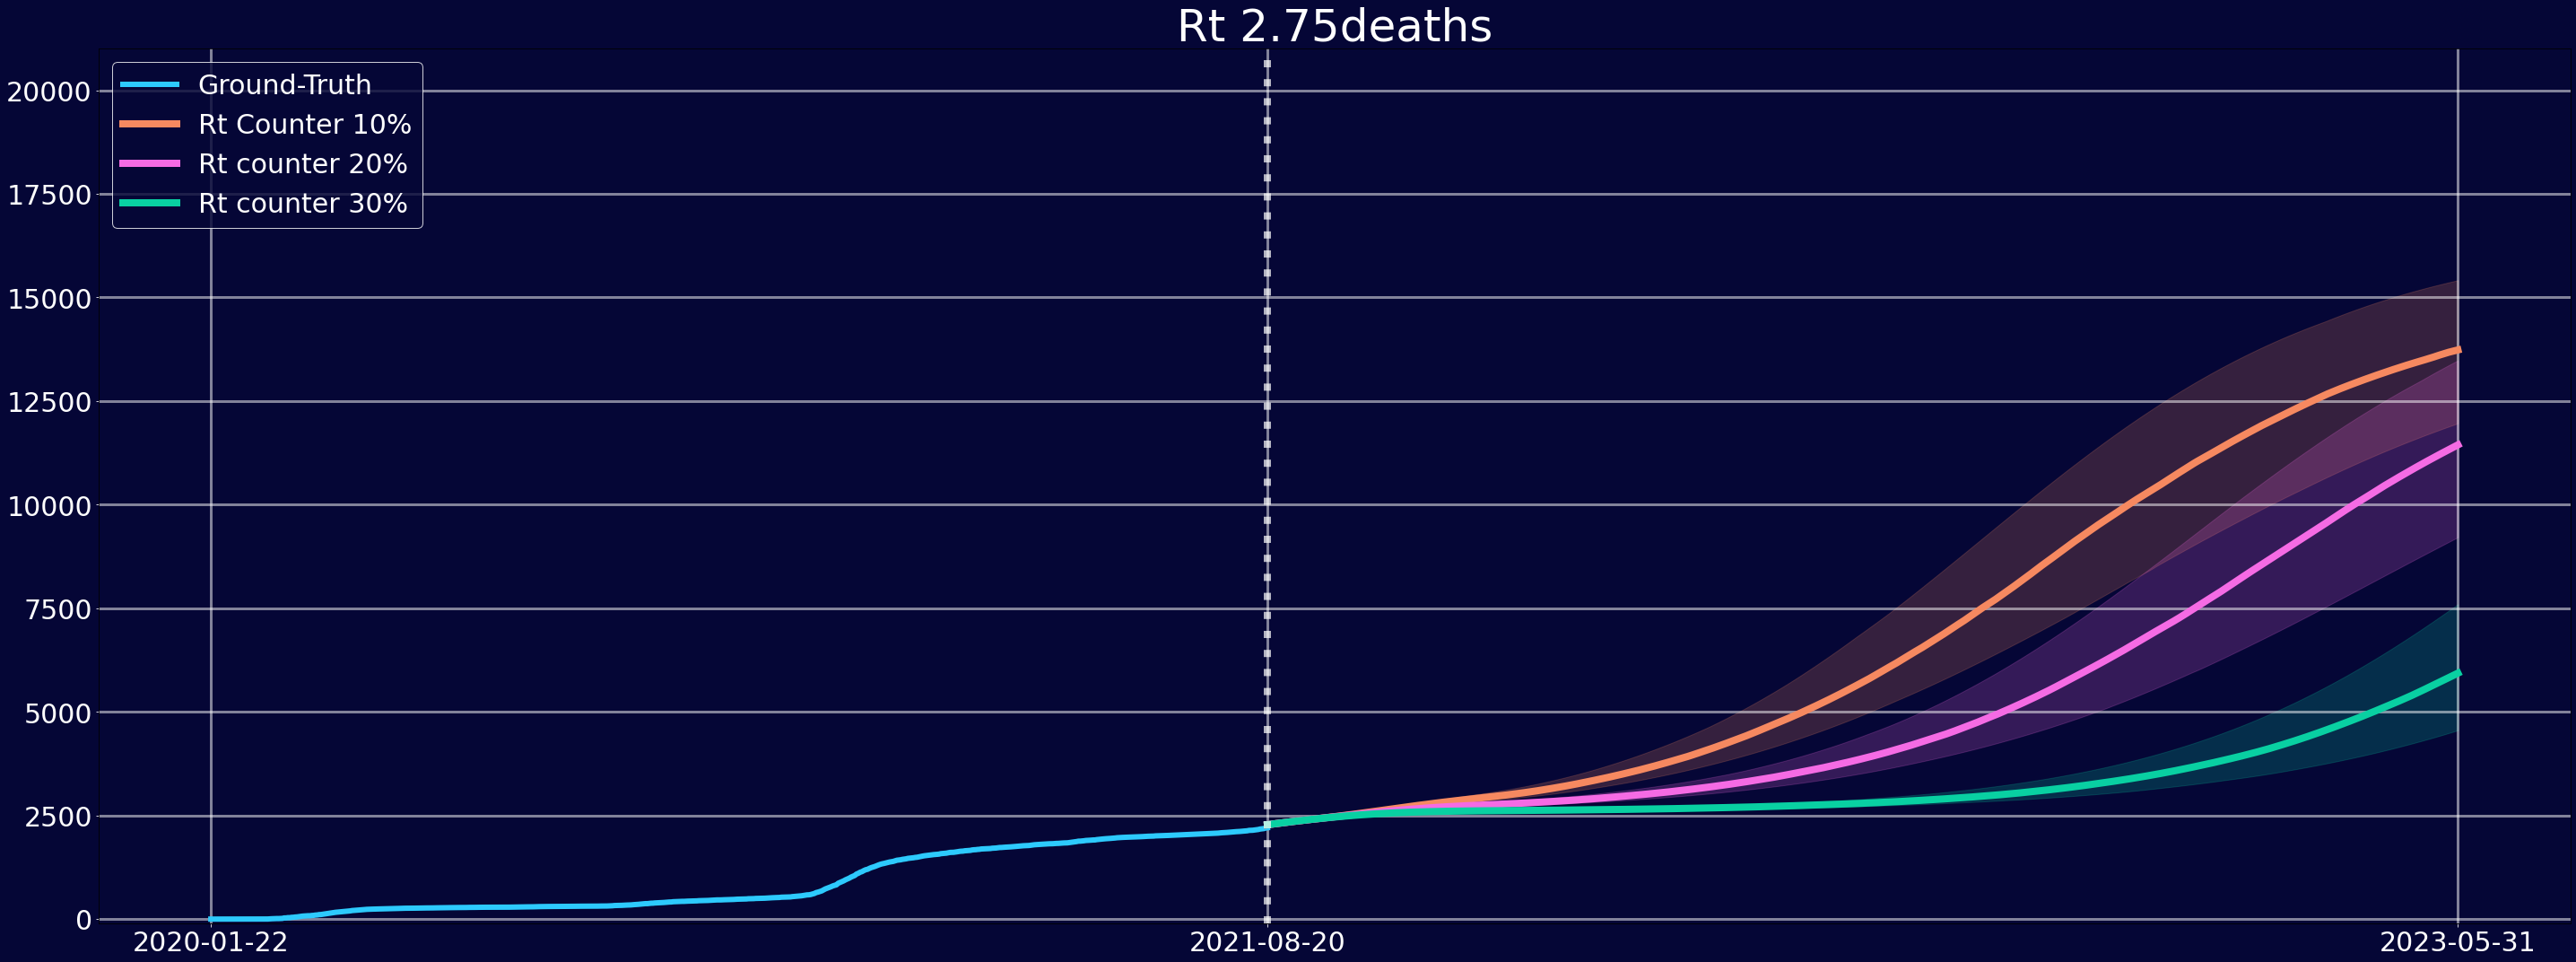

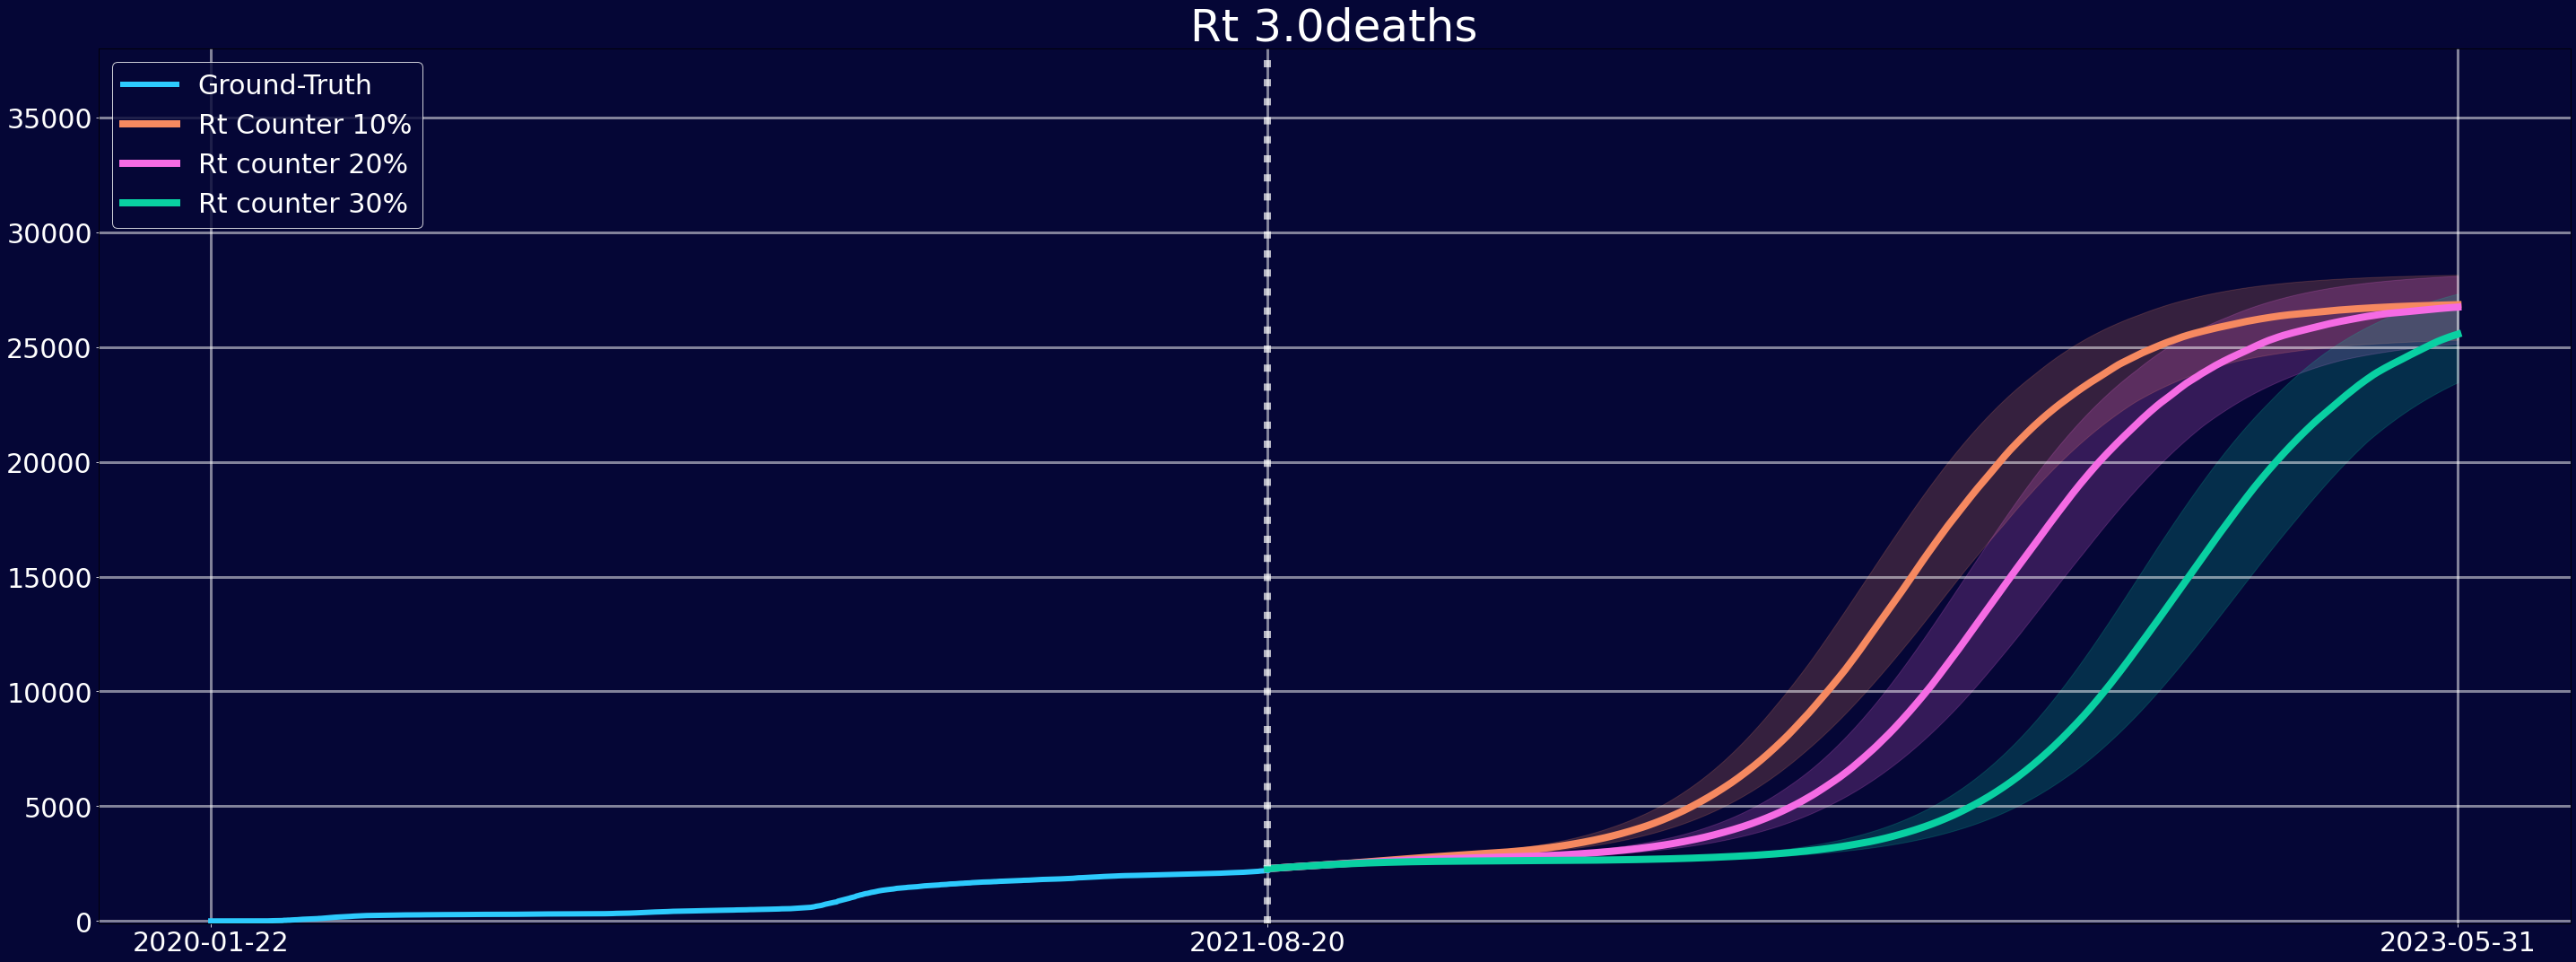

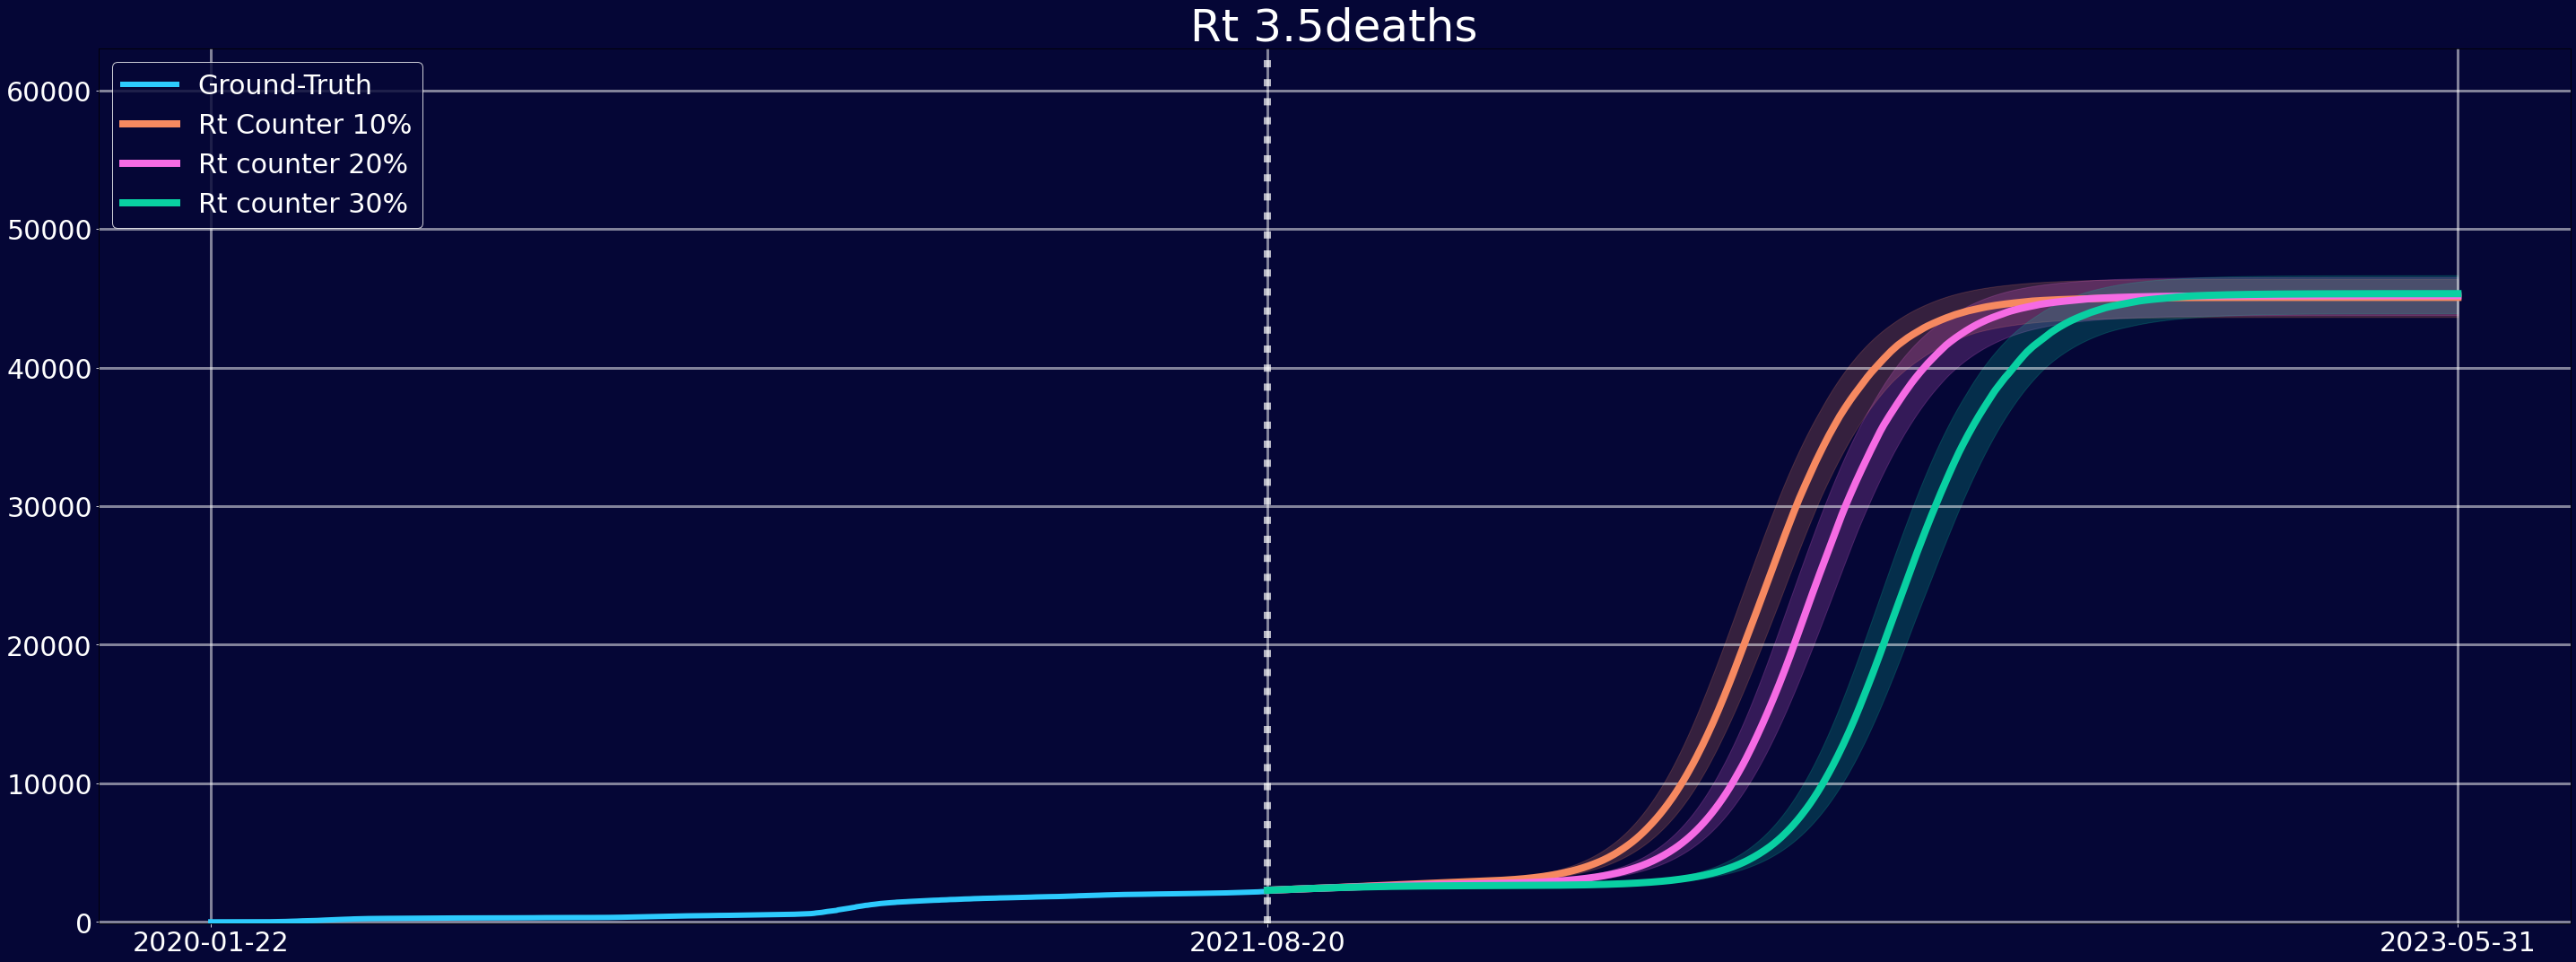

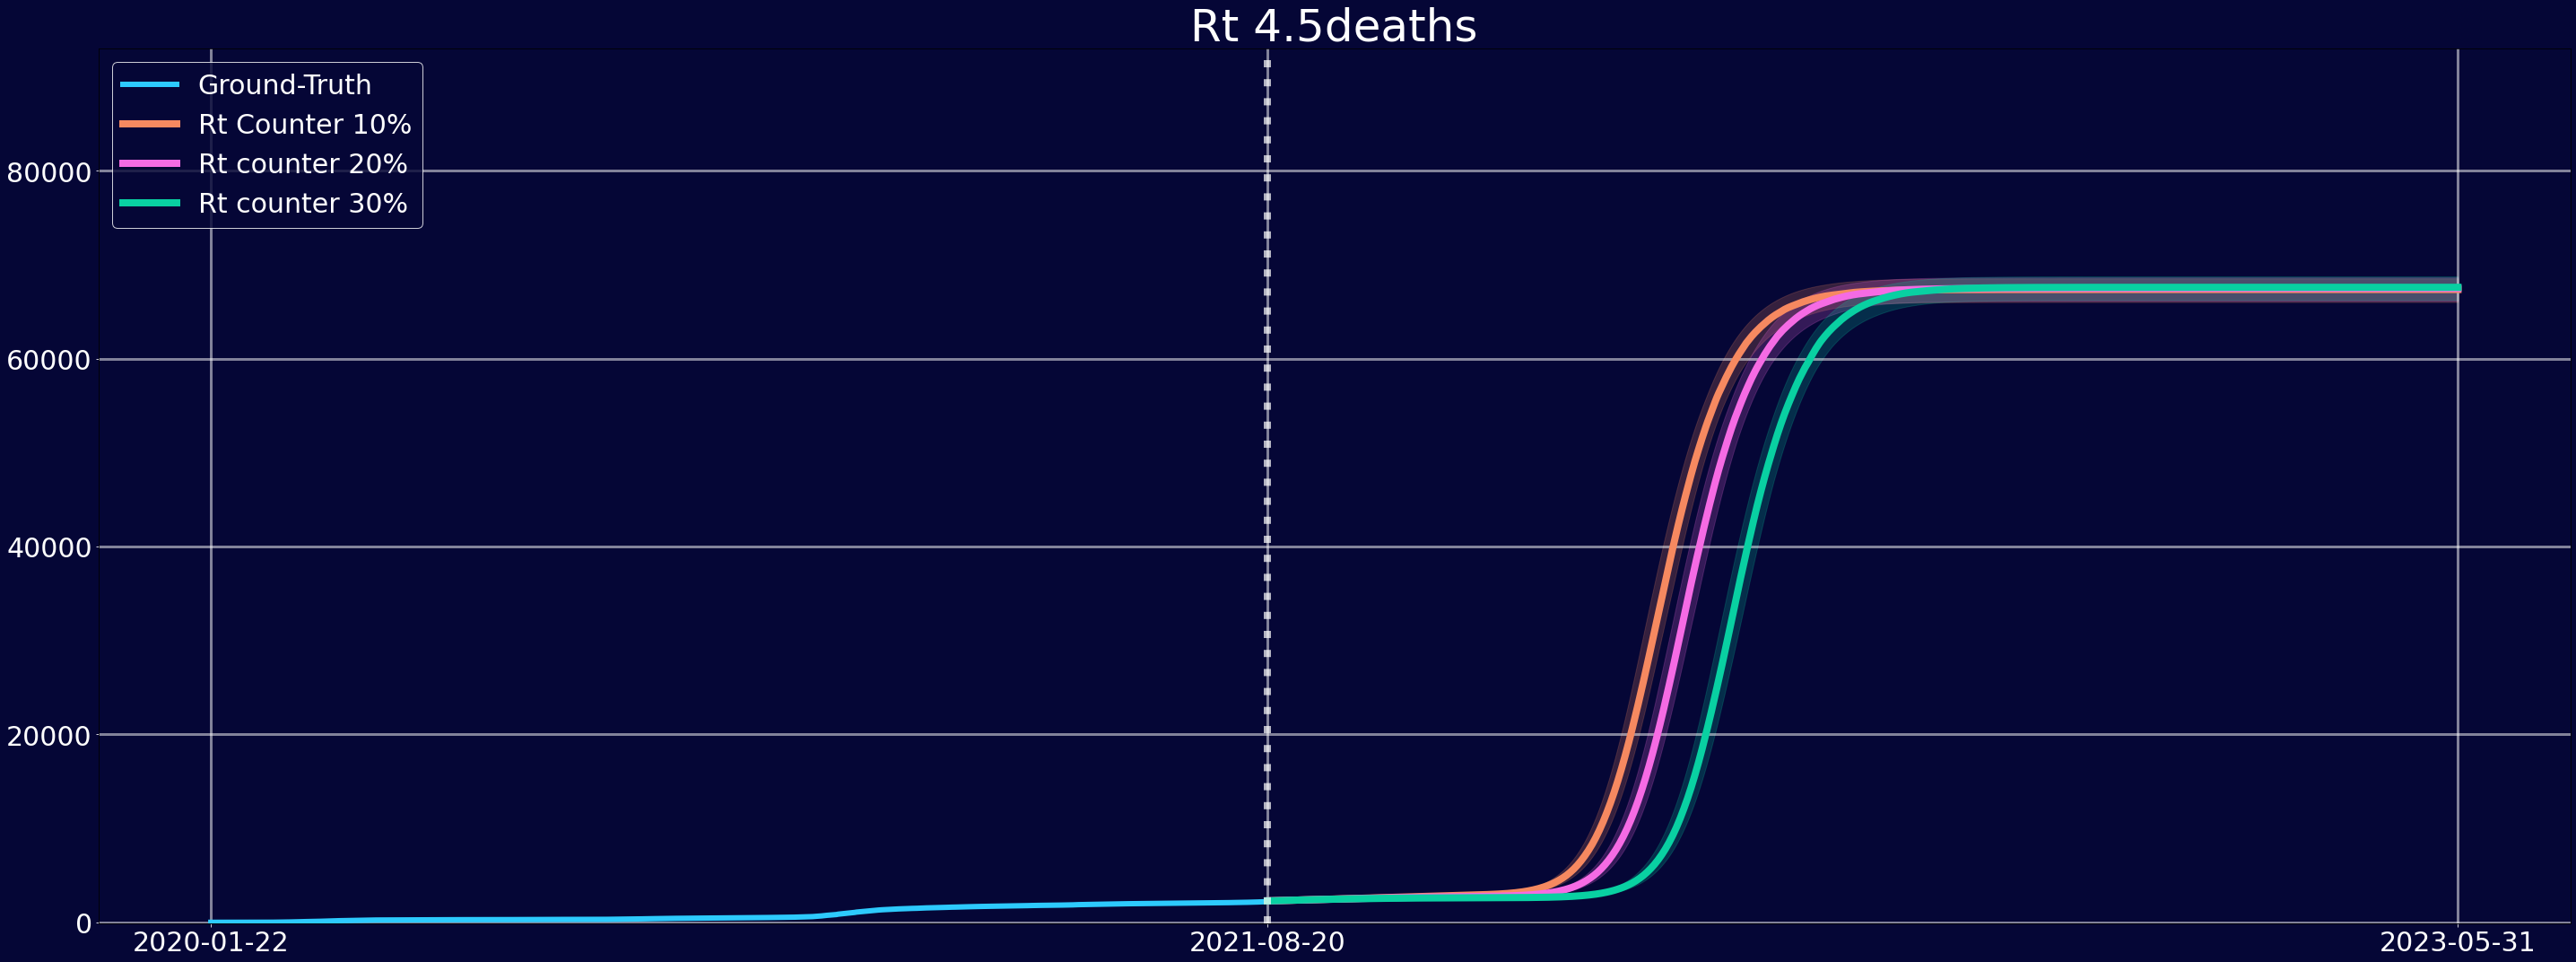

In [27]:
# rt_0_death = rt_0_death[rt_0_death['Date']>=pre_date]
# rt_1_death = rt_1_death[rt_1_death['Date']>=pre_date]
# rt_2_death = rt_2_death[rt_2_death['Date']>=pre_date]
# rt_3_death = rt_3_death[rt_3_death['Date']>=pre_date]
# rt_4_death = rt_4_death[rt_4_death['Date']>=pre_date]
Original_Plot('deaths',rt_0_death,Rt[0])
Original_Plot('deaths',rt_1_death,Rt[1])
Original_Plot('deaths',rt_2_death,Rt[2])
Original_Plot('deaths',rt_3_death,Rt[3])
Original_Plot('deaths',rt_4_death,Rt[4])

# 모든 Rt plot (new)

In [59]:
## Rt plot
def Rt_Plot(x,y,value):
    ################스타일#######################################
    fig = plt.figure(figsize=(40,15)) ## 캔버스 생성
    fig.patch.set_facecolor('#050636') 
    plt.rcParams['text.color'] = 'w'
    plt.rcParams['xtick.color'] = 'w'
    plt.rcParams['ytick.color'] = 'w'
    plt.rcParams['axes.spines.left'] = True
    plt.rcParams['axes.facecolor']='#050636'
    plt.grid(color='w', linestyle='-', linewidth=3,alpha = 0.5)
    plt.gca().spines['bottom'].set_visible(True) #위 테두리
    plt.gca().spines['left'].set_visible(True) #왼쪽 테두리
#     plt.ylim(y_lim)
    #############################################################
    
    
    
    v = ''
    if value =='Low':
        v = 'l'
    elif value == 'Base':
        v = 'b'
    else:
        v = 'h'
    
    if x == 'incidence':
        ground_truth = data_case
        column = 'Confirmed'
        plt_start_date = start_date
        offset = 0
        folder = 'I'
        plt.xticks([plt_start_date,'2020-05-01','2020-08-01','2020-11-01','2021-02-01','2021-05-01',pre_date,'2021-12-01','2022-03-01','2022-06-01','2022-09-01','2022-12-01','2023-03-01',end_date],[str(plt_start_date)[:10],'2020-05','2020-08','2020-11','2021-02','2021-05',str(pre_date)[:10],'2021-12','2022-03','2022-06','2022-09','2022-12','2023-03',str(end_date)[:10]],fontsize=30)

        
    elif x == 'deaths':
        ground_truth = data_case
        column = 'Cum_Deaths'
        plt_start_date = start_date
        offset = aug20_cum_deaths
        folder = 'D'
        plt.xticks([plt_start_date,'2020-05-01','2020-08-01','2020-11-01','2021-02-01','2021-05-01',pre_date,'2021-12-01','2022-03-01','2022-06-01','2022-09-01','2022-12-01','2023-03-01',end_date],[str(plt_start_date)[:10],'2020-05','2020-08','2020-11','2021-02','2021-05',str(pre_date)[:10],'2021-12','2022-03','2022-06','2022-09','2022-12','2023-03',str(end_date)[:10]],fontsize=30)

    else:
        ground_truth = old_severity
        column = 'Severity'
        plt_start_date = sev_start_date
        offset = 0
        folder = 'S'
        plt.xticks([plt_start_date,'2021-02-01','2021-05-01',pre_date,'2021-12-01','2022-03-01','2022-06-01','2022-09-01','2022-12-01','2023-03-01',end_date],[str(plt_start_date)[:10],'2021-02-01','2021-05-01',str(pre_date)[:10],'2021-12','2022-03','2022-06','2022-09','2022-12','2023-03',str(end_date)[:10]],fontsize=30)


   
    
    ################ Ground Truth #######################################
    plt.plot(ground_truth['tDate'], ground_truth[column],color = '#2dcafd',  linewidth = 6)
   
    
    ################ Rt[4] Data #######################################
    plt.plot(y['Date'], y[str(Rt[4])+'_'+v]+offset, color ='#7d72cf', linewidth = 8)
    plt.fill_between(y['Date'], y[str(Rt[4])+'_'+v+'_min']+offset,y[str(Rt[4])+'_'+v+'_max']+offset, color = '#7d72cf',alpha=0.3)

    
    ################ Rt[3] Data #######################################
    plt.plot(y['Date'], y[str(Rt[3])+'_'+v]+offset, color ='#3d77b6', linewidth = 8)
    plt.fill_between(y['Date'], y[str(Rt[3])+'_'+v+'_min']+offset,y[str(Rt[3])+'_'+v+'_max']+offset, color = '#3d77b6',alpha=0.3)
    
    
    ################ Rt[2] Data #######################################
    plt.plot(y['Date'], y[str(Rt[2])+'_'+v]+offset, color ='#09d0a2', linewidth = 8)
    plt.fill_between(y['Date'], y[str(Rt[2])+'_'+v+'_min']+offset,y[str(Rt[2])+'_'+v+'_max']+offset, color = '#09d0a2',alpha=0.3)
    
    
    ################ Rt[1] Data #######################################
    plt.plot(y['Date'], y[str(Rt[1])+'_'+v]+offset, color ='#f68960', linewidth = 8)
    plt.fill_between(y['Date'], y[str(Rt[1])+'_'+v+'_min']+offset,y[str(Rt[1])+'_'+v+'_max']+offset, color = '#f68960',alpha=0.3)
    
    
    ################ Rt[0] Data #######################################
    plt.plot(y['Date'], y[str(Rt[0])+'_'+v]+offset, color ='#f56be4', linewidth = 8)
    plt.fill_between(y['Date'], y[str(Rt[0])+'_'+v+'_min']+offset,y[str(Rt[0])+'_'+v+'_max']+offset, color = '#f56be4',alpha=0.3)
    
    
    ################ Legend #######################################
    plt.legend(['Ground-Truth','Rt '+str(Rt[4]),'Rt '+str(Rt[3]),'Rt '+str(Rt[2]),'Rt '+str(Rt[1]),'Rt '+str(Rt[0])],fontsize = 30,loc = 'upper left', edgecolor = 'w')


    plt.axvline(x = pre_date,linestyle = ':',color='w',linewidth=8, alpha = 0.7)
    file_name = 'R counter '+value+' - '+column
#     plt.title(file_name,fontsize=50)
#     plt.suptitle(file_name, y=1, fontsize=30)
#     plt.xticks(fontsize = 30)
    plt.yticks(fontsize = 30)
    plt.tight_layout()
#     plt.savefig("../figures/211029/"+folder+"/"+file_name+".png",dpi=300)
    plt.show()

### 확진자

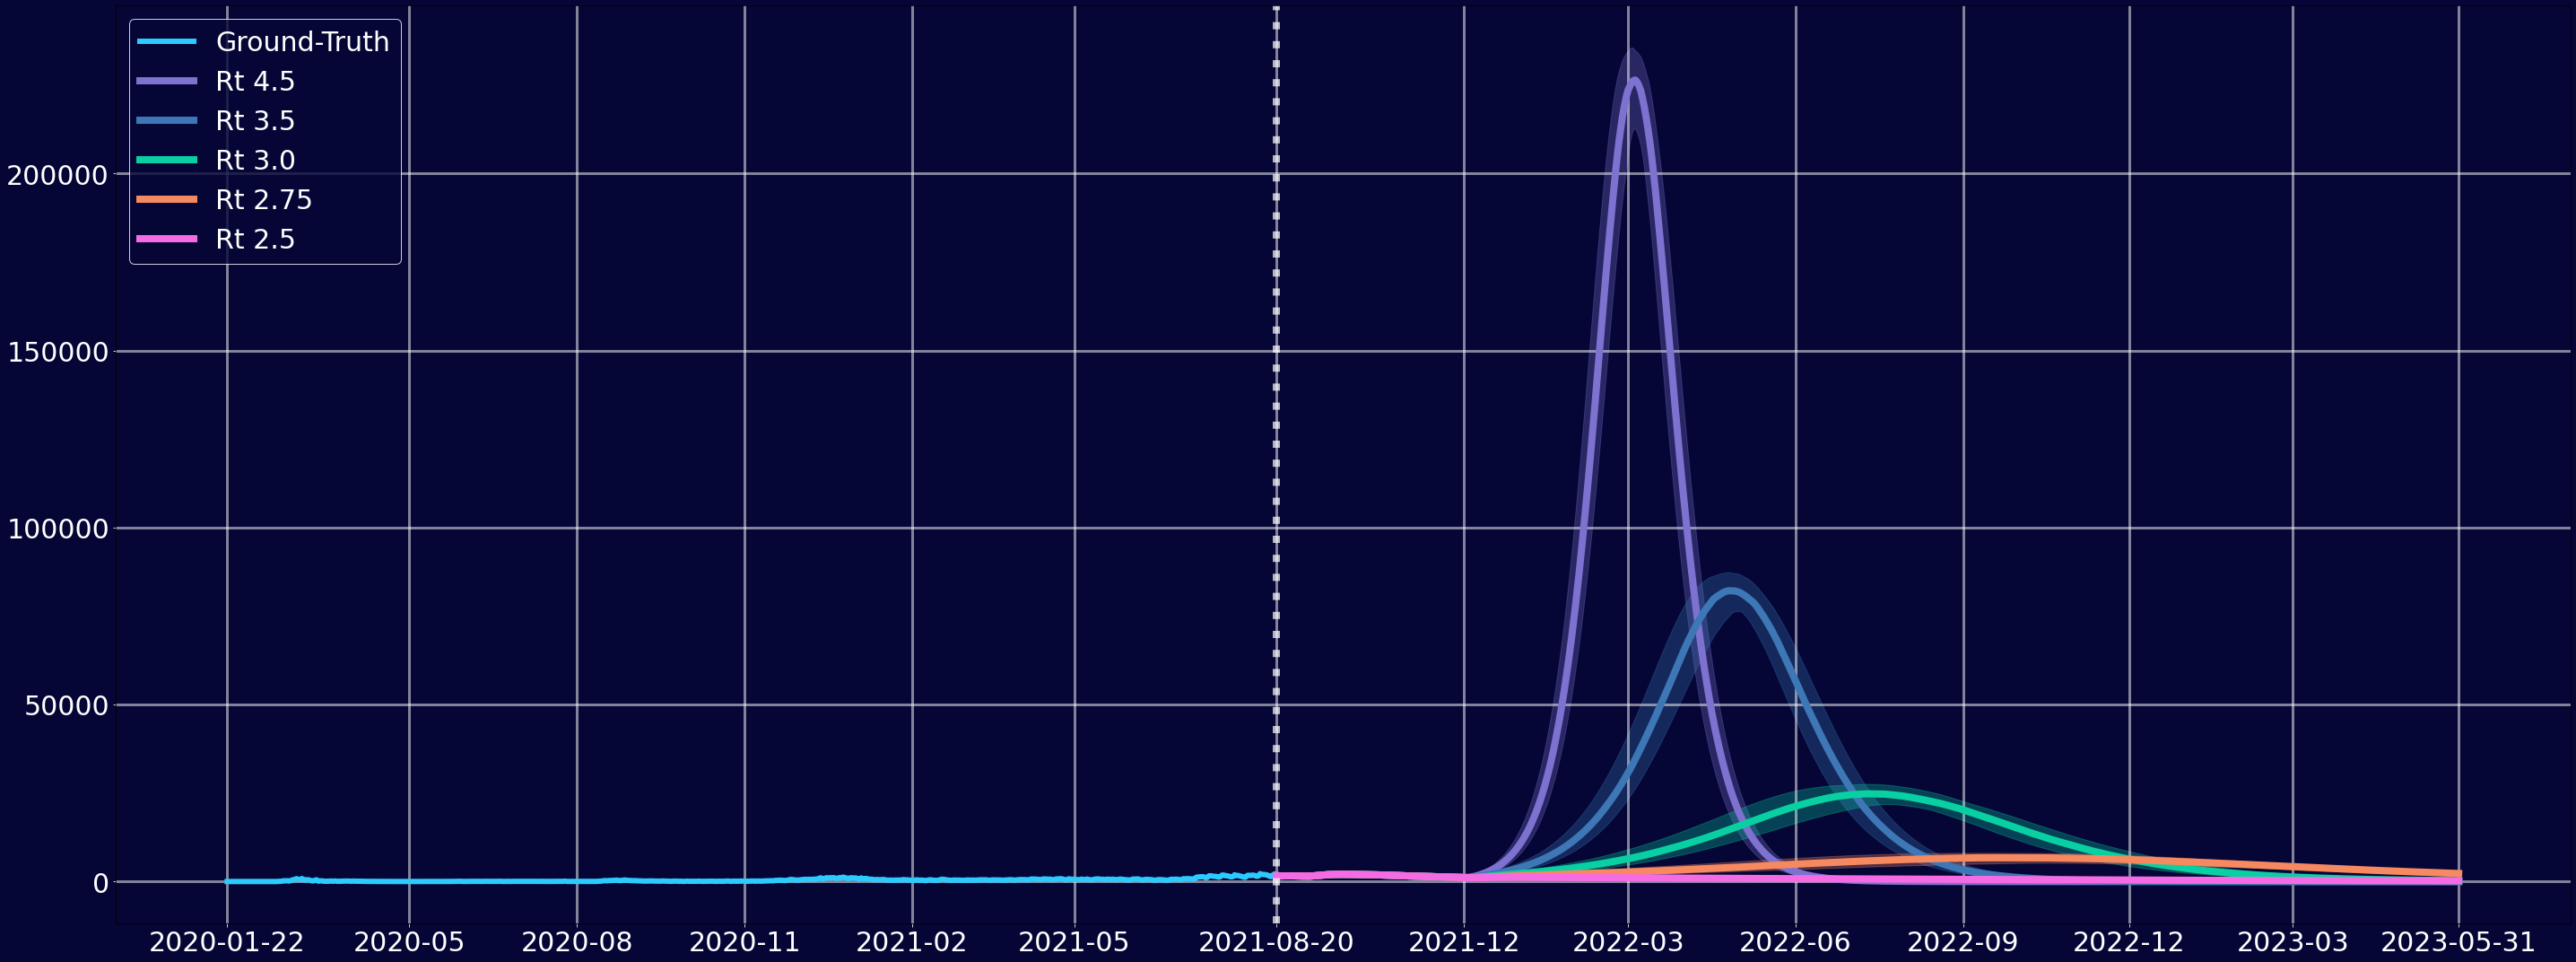

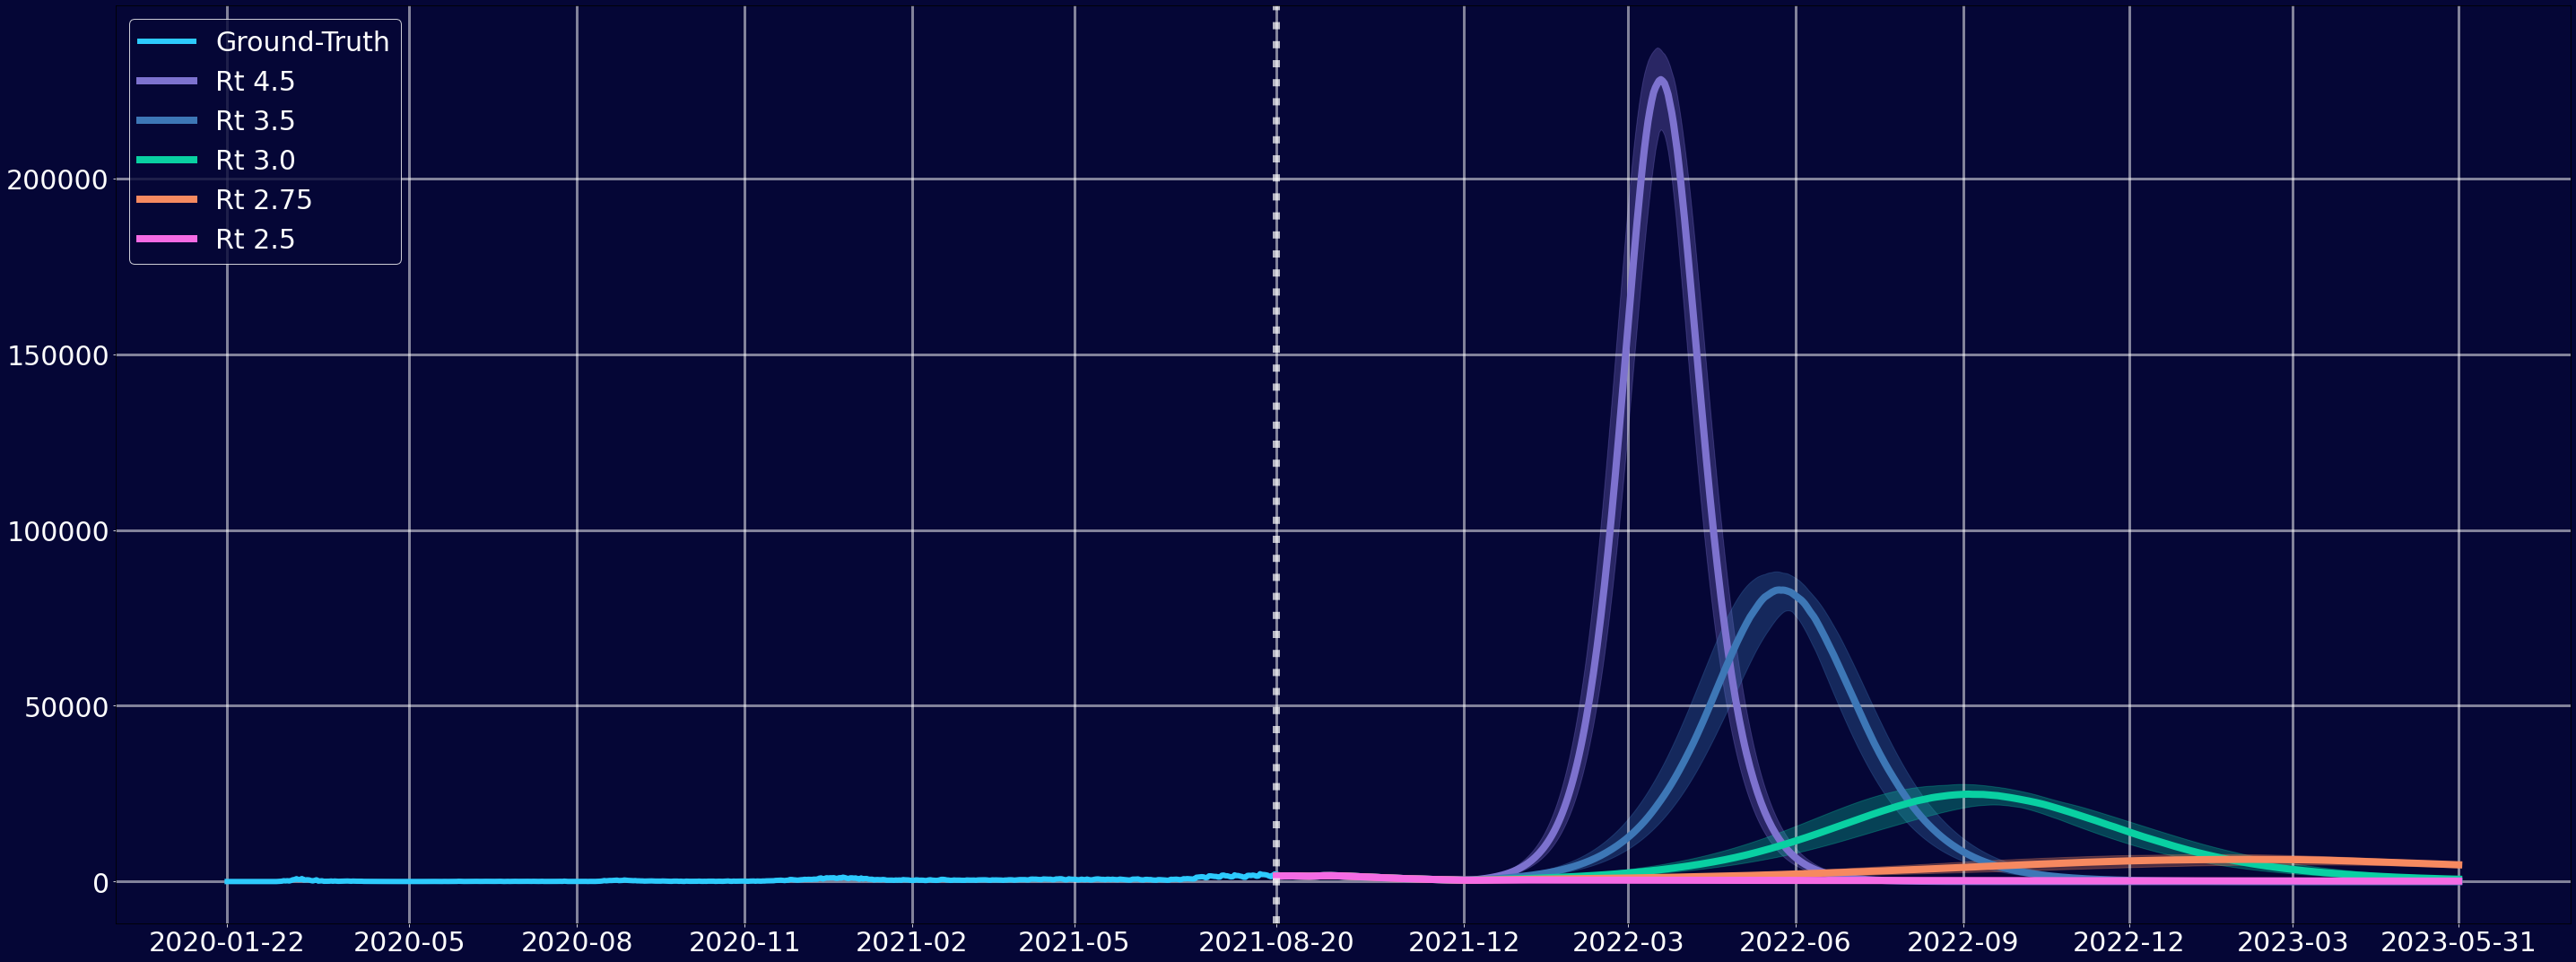

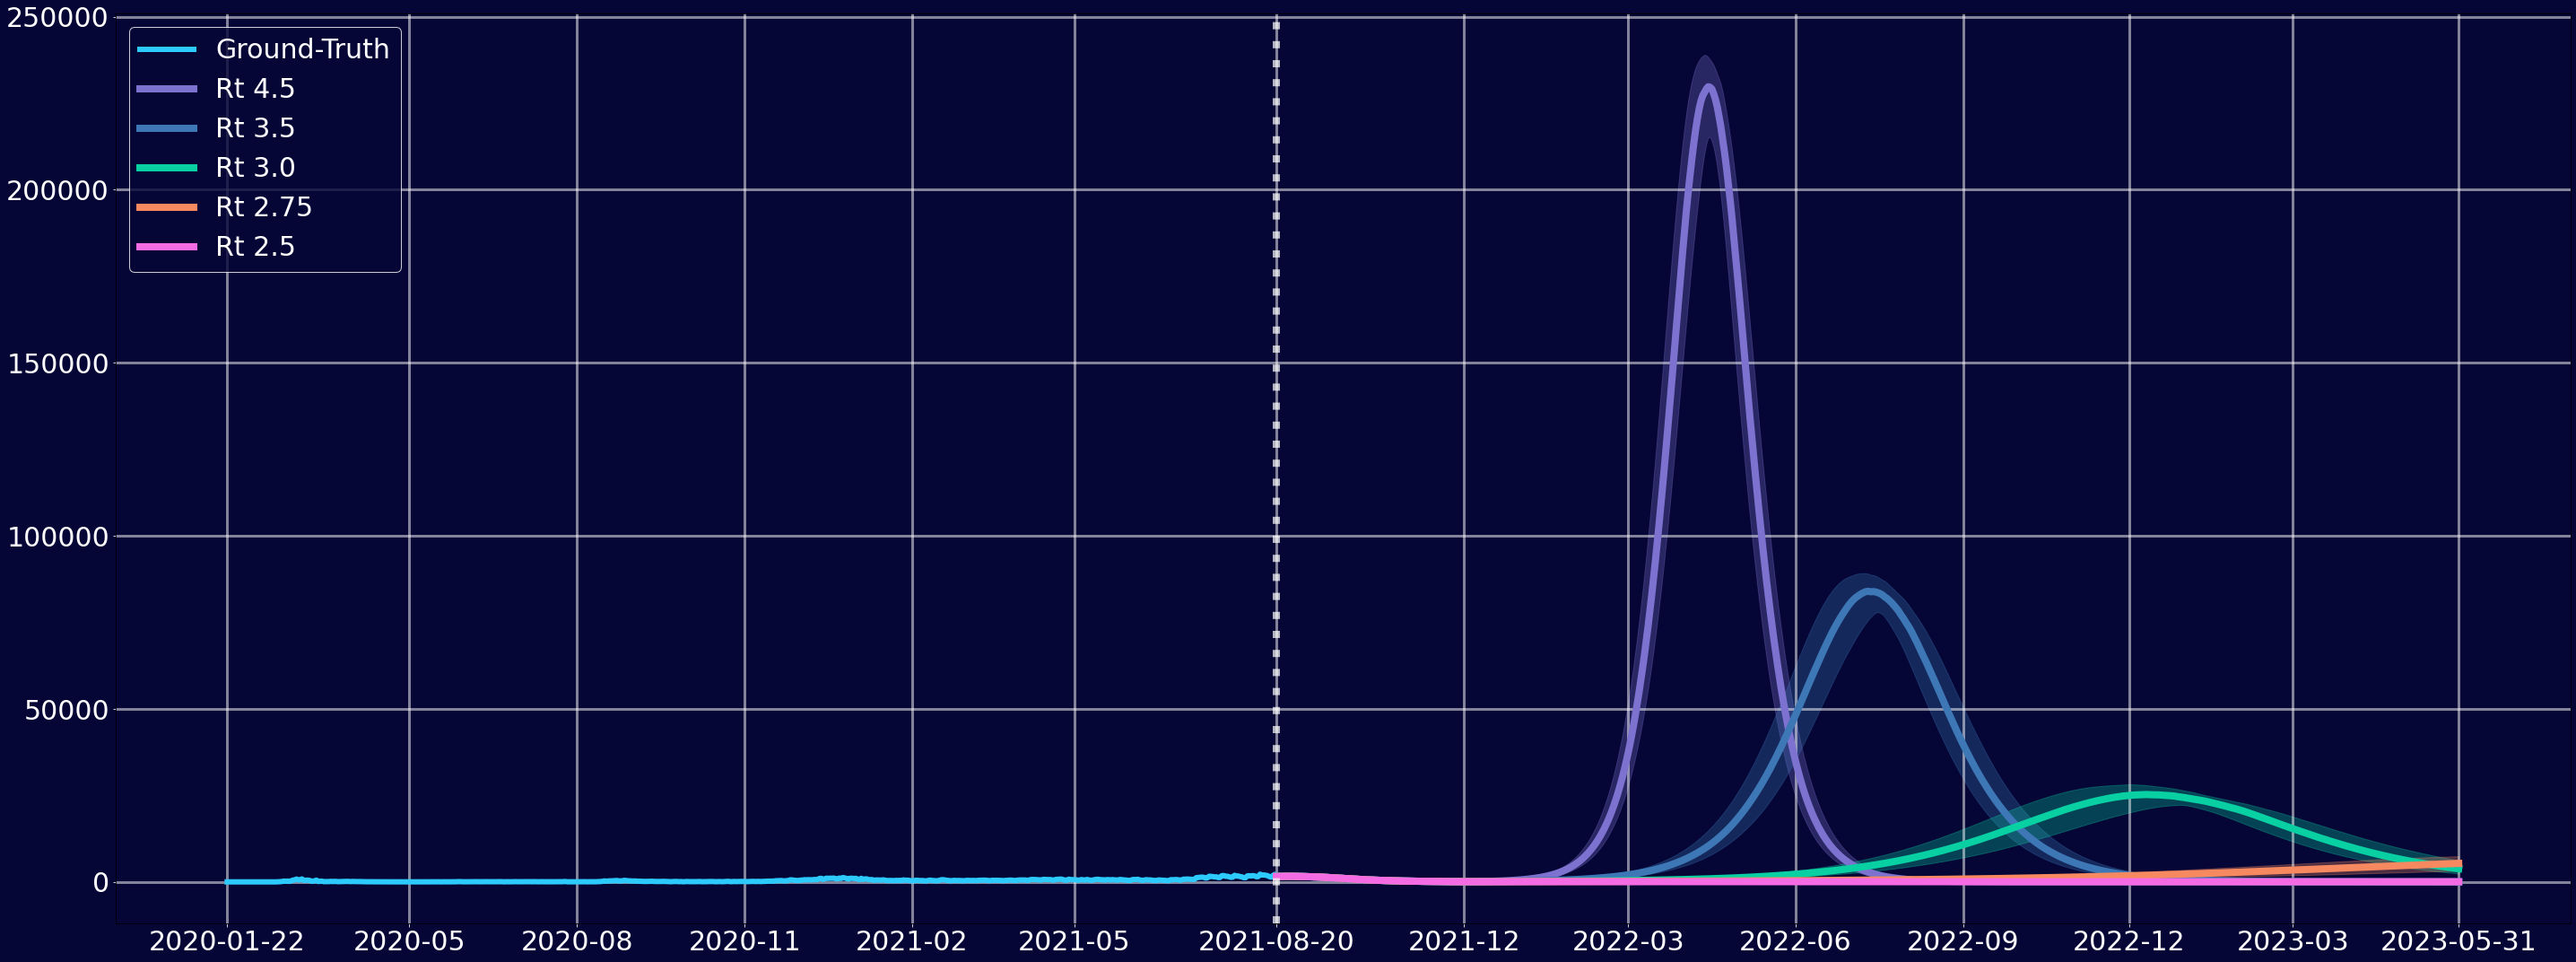

In [60]:
Rt_Plot('incidence',incidence,'Low')
Rt_Plot('incidence',incidence,'Base')
Rt_Plot('incidence',incidence,'High')

### 중증자

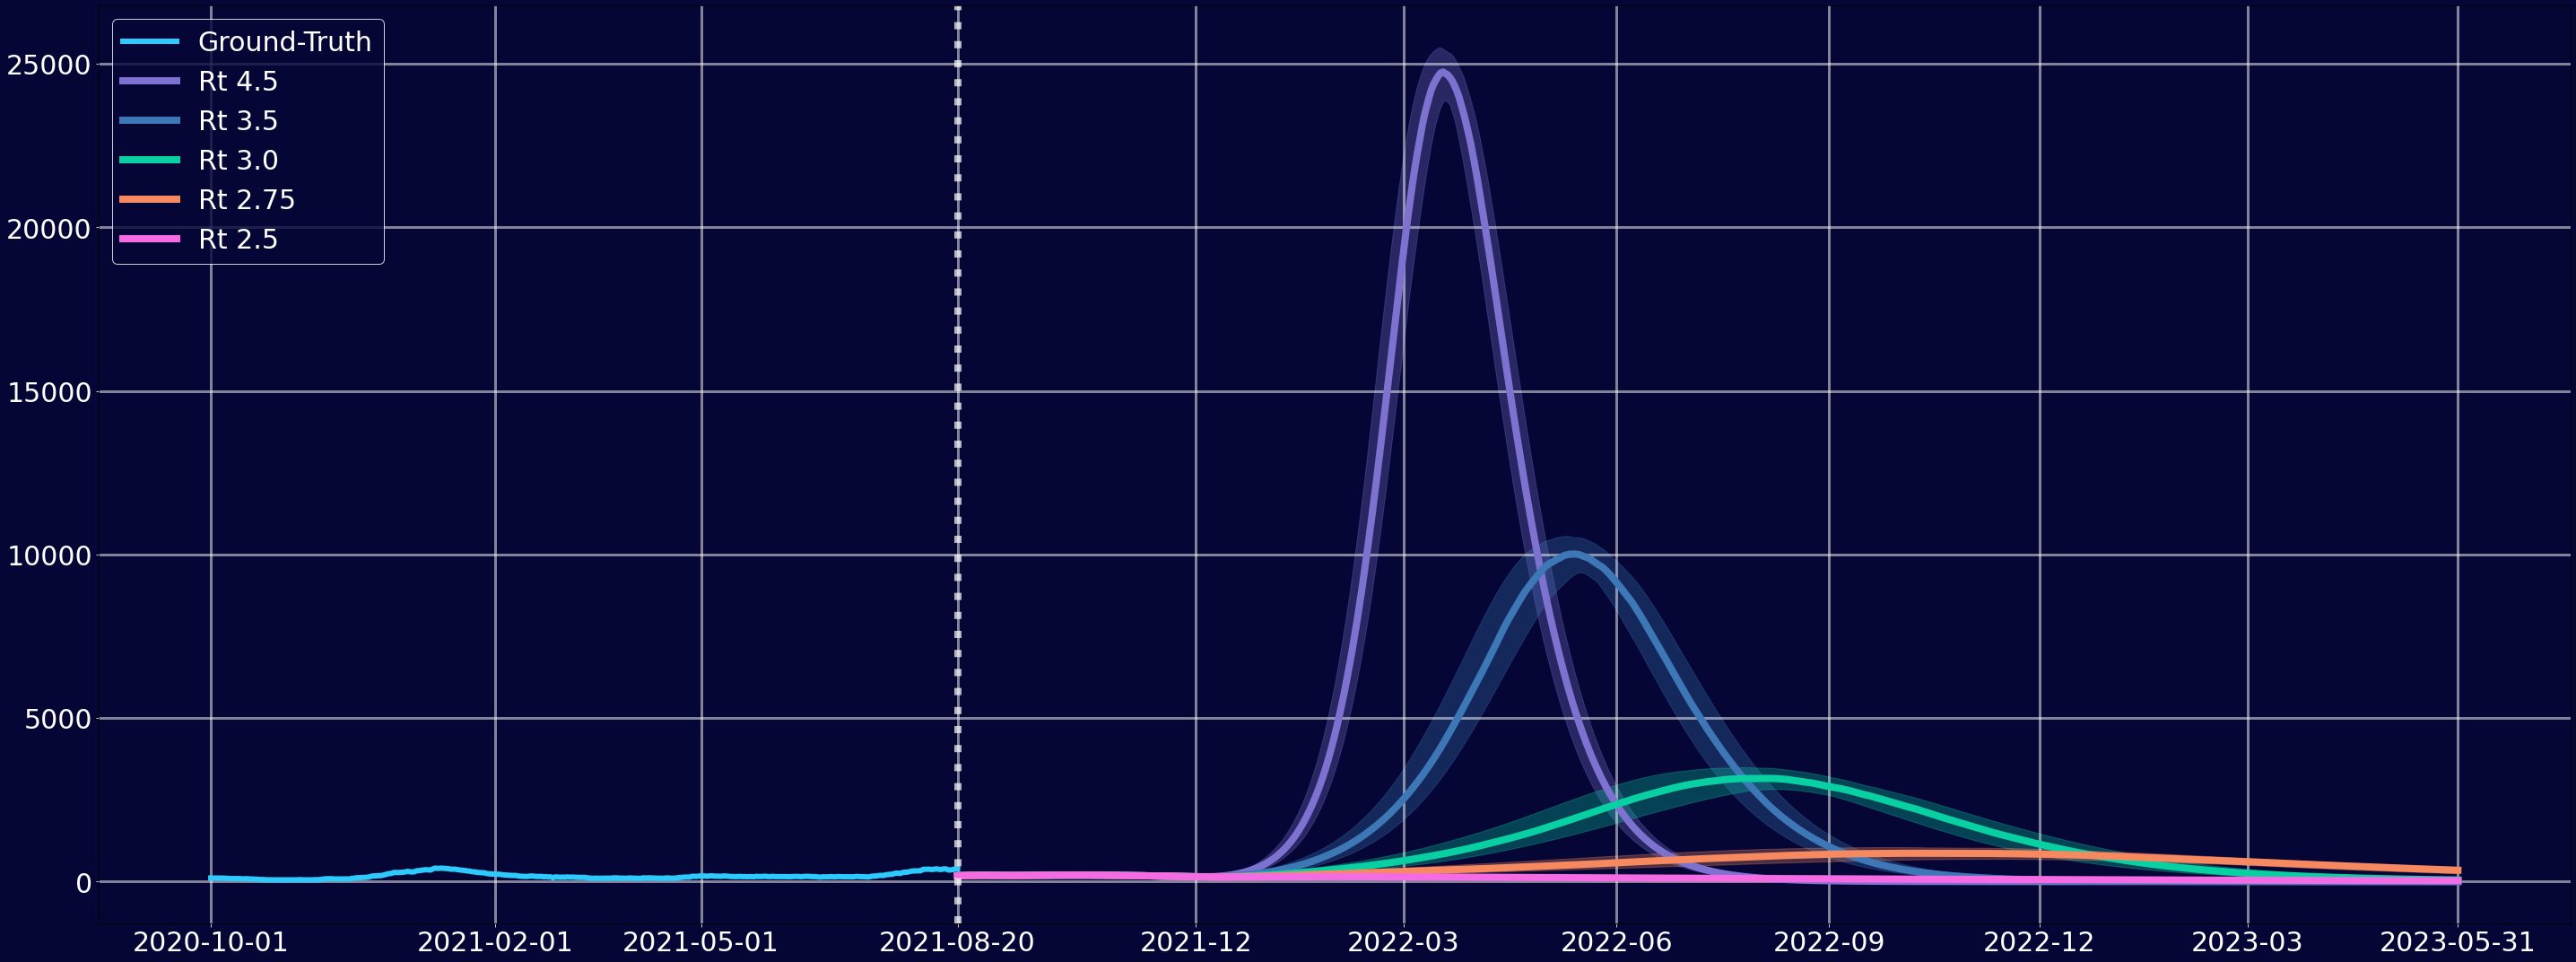

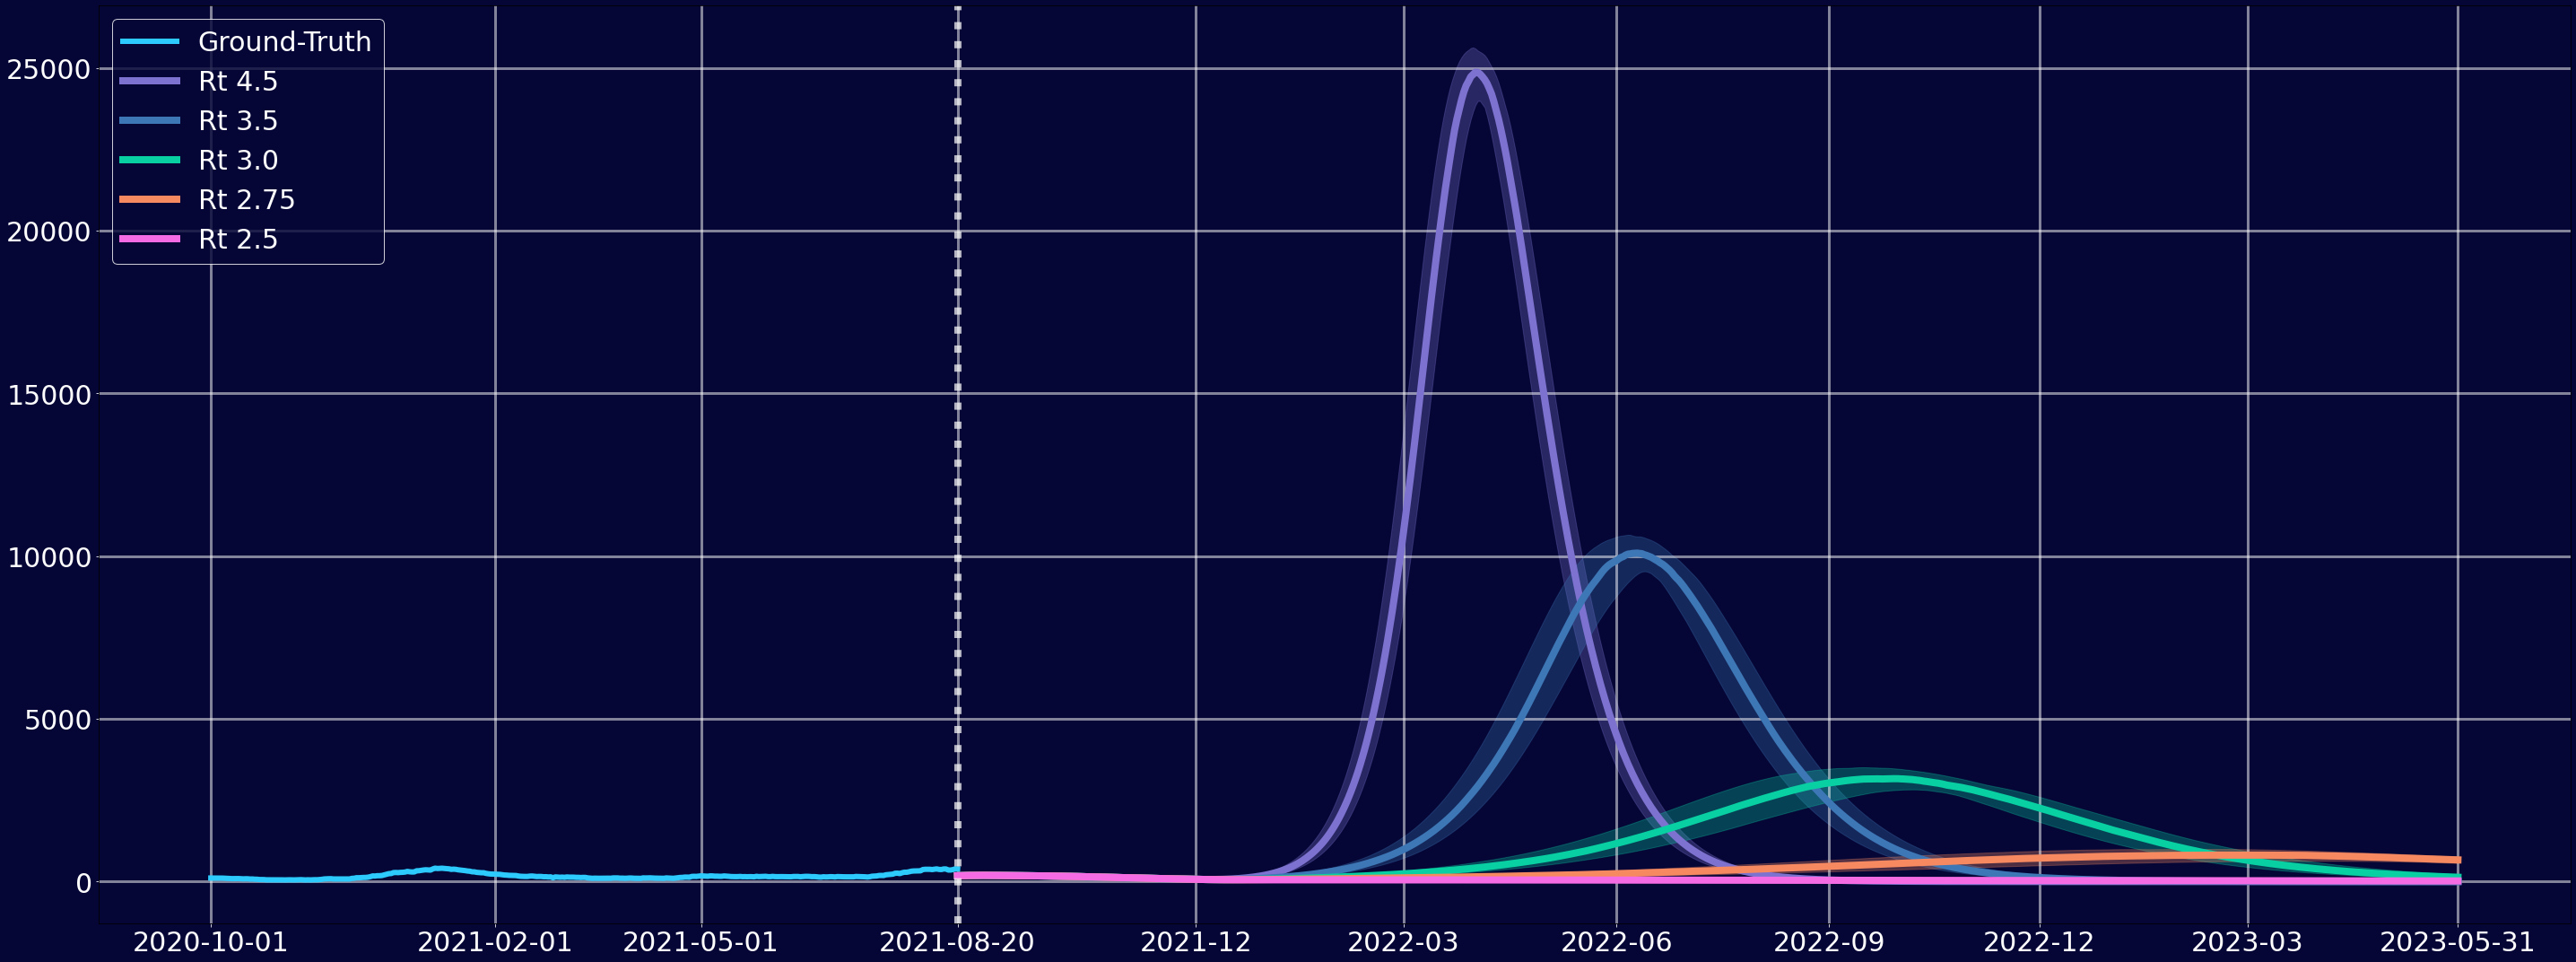

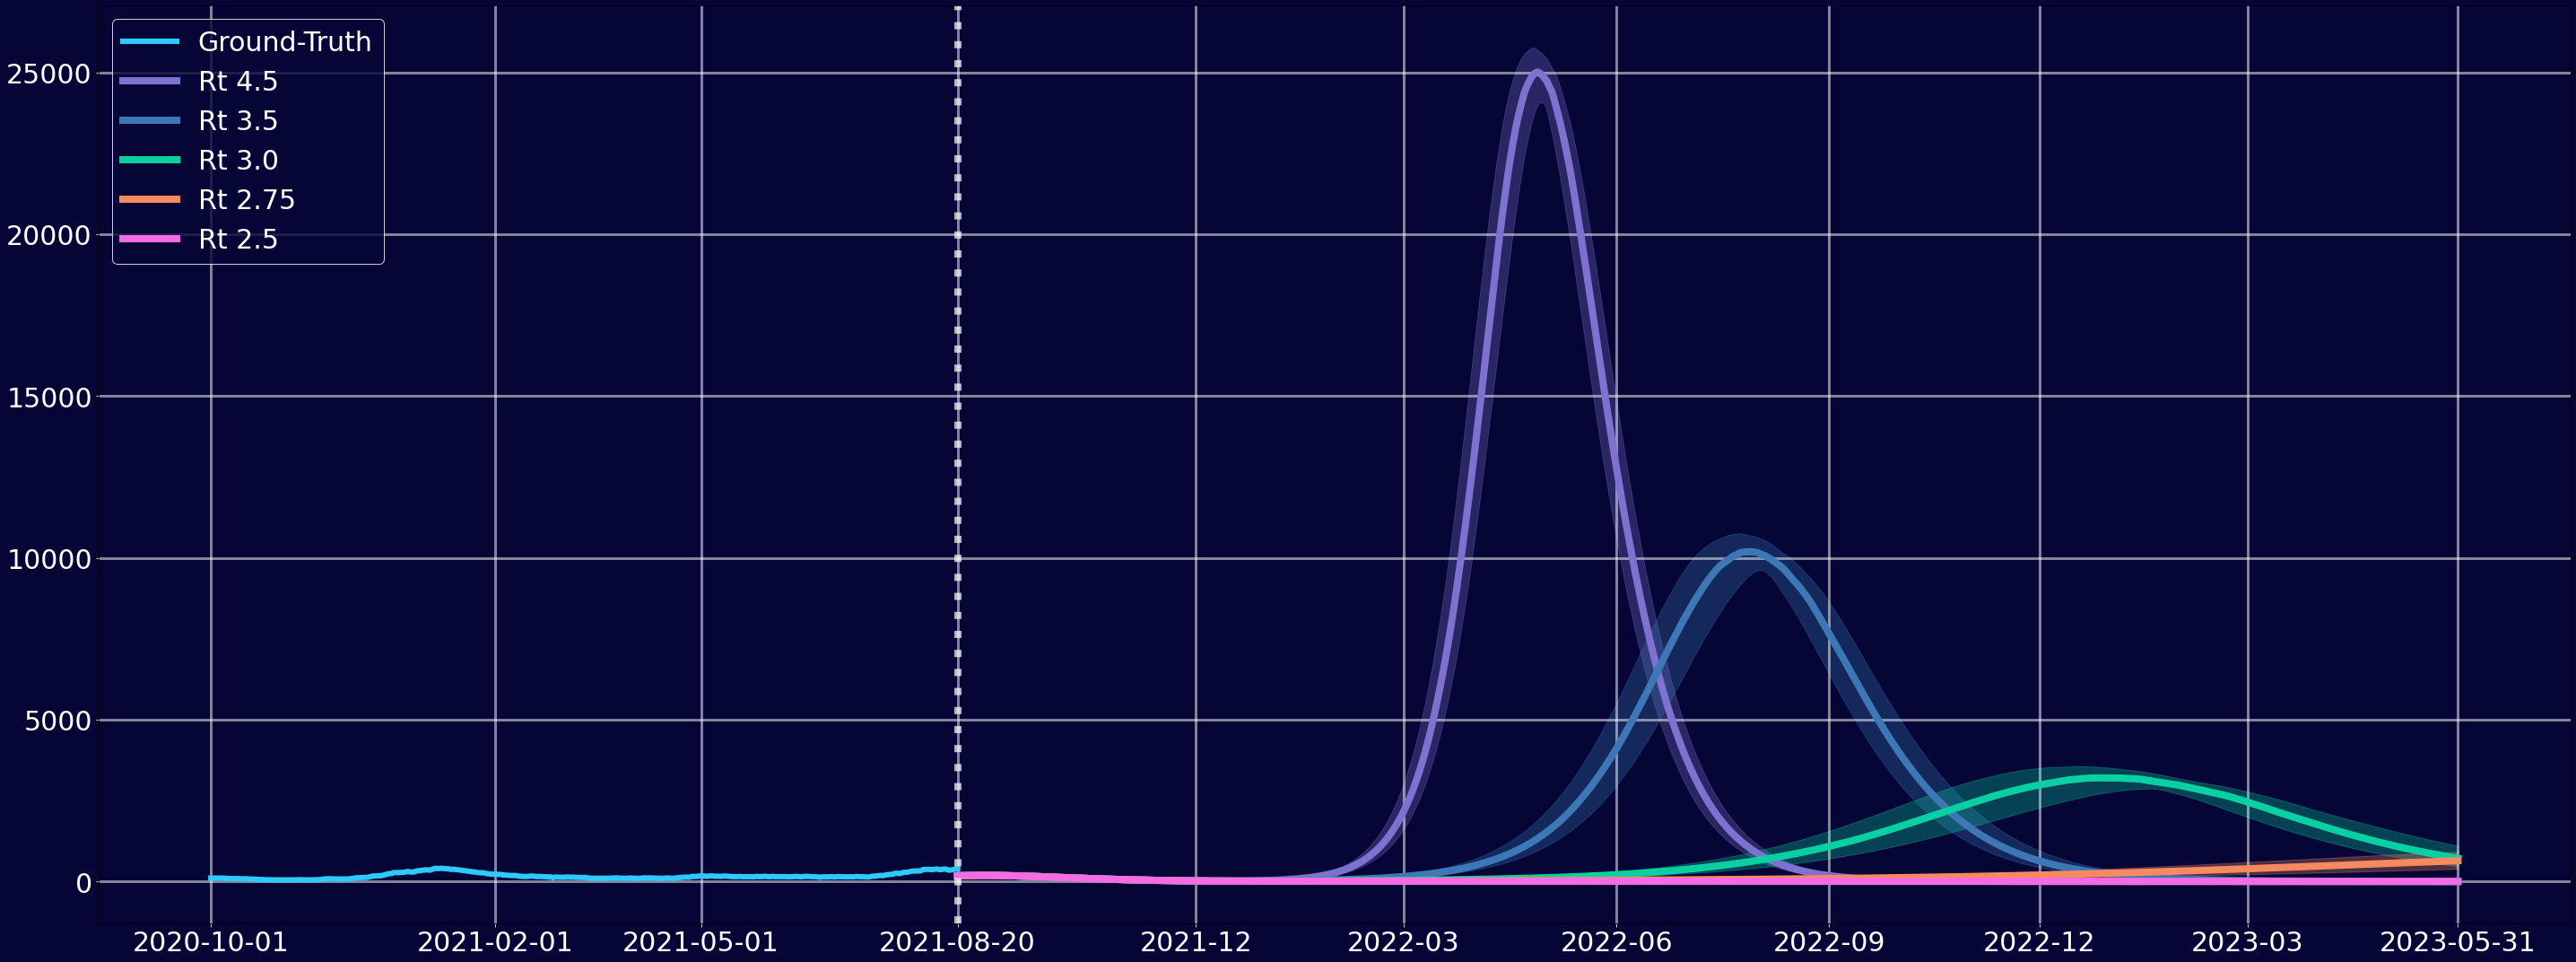

In [62]:
Rt_Plot('severity',severity,'Low')
Rt_Plot('severity',severity,'Base')
Rt_Plot('severity',severity,'High')

### 사망자

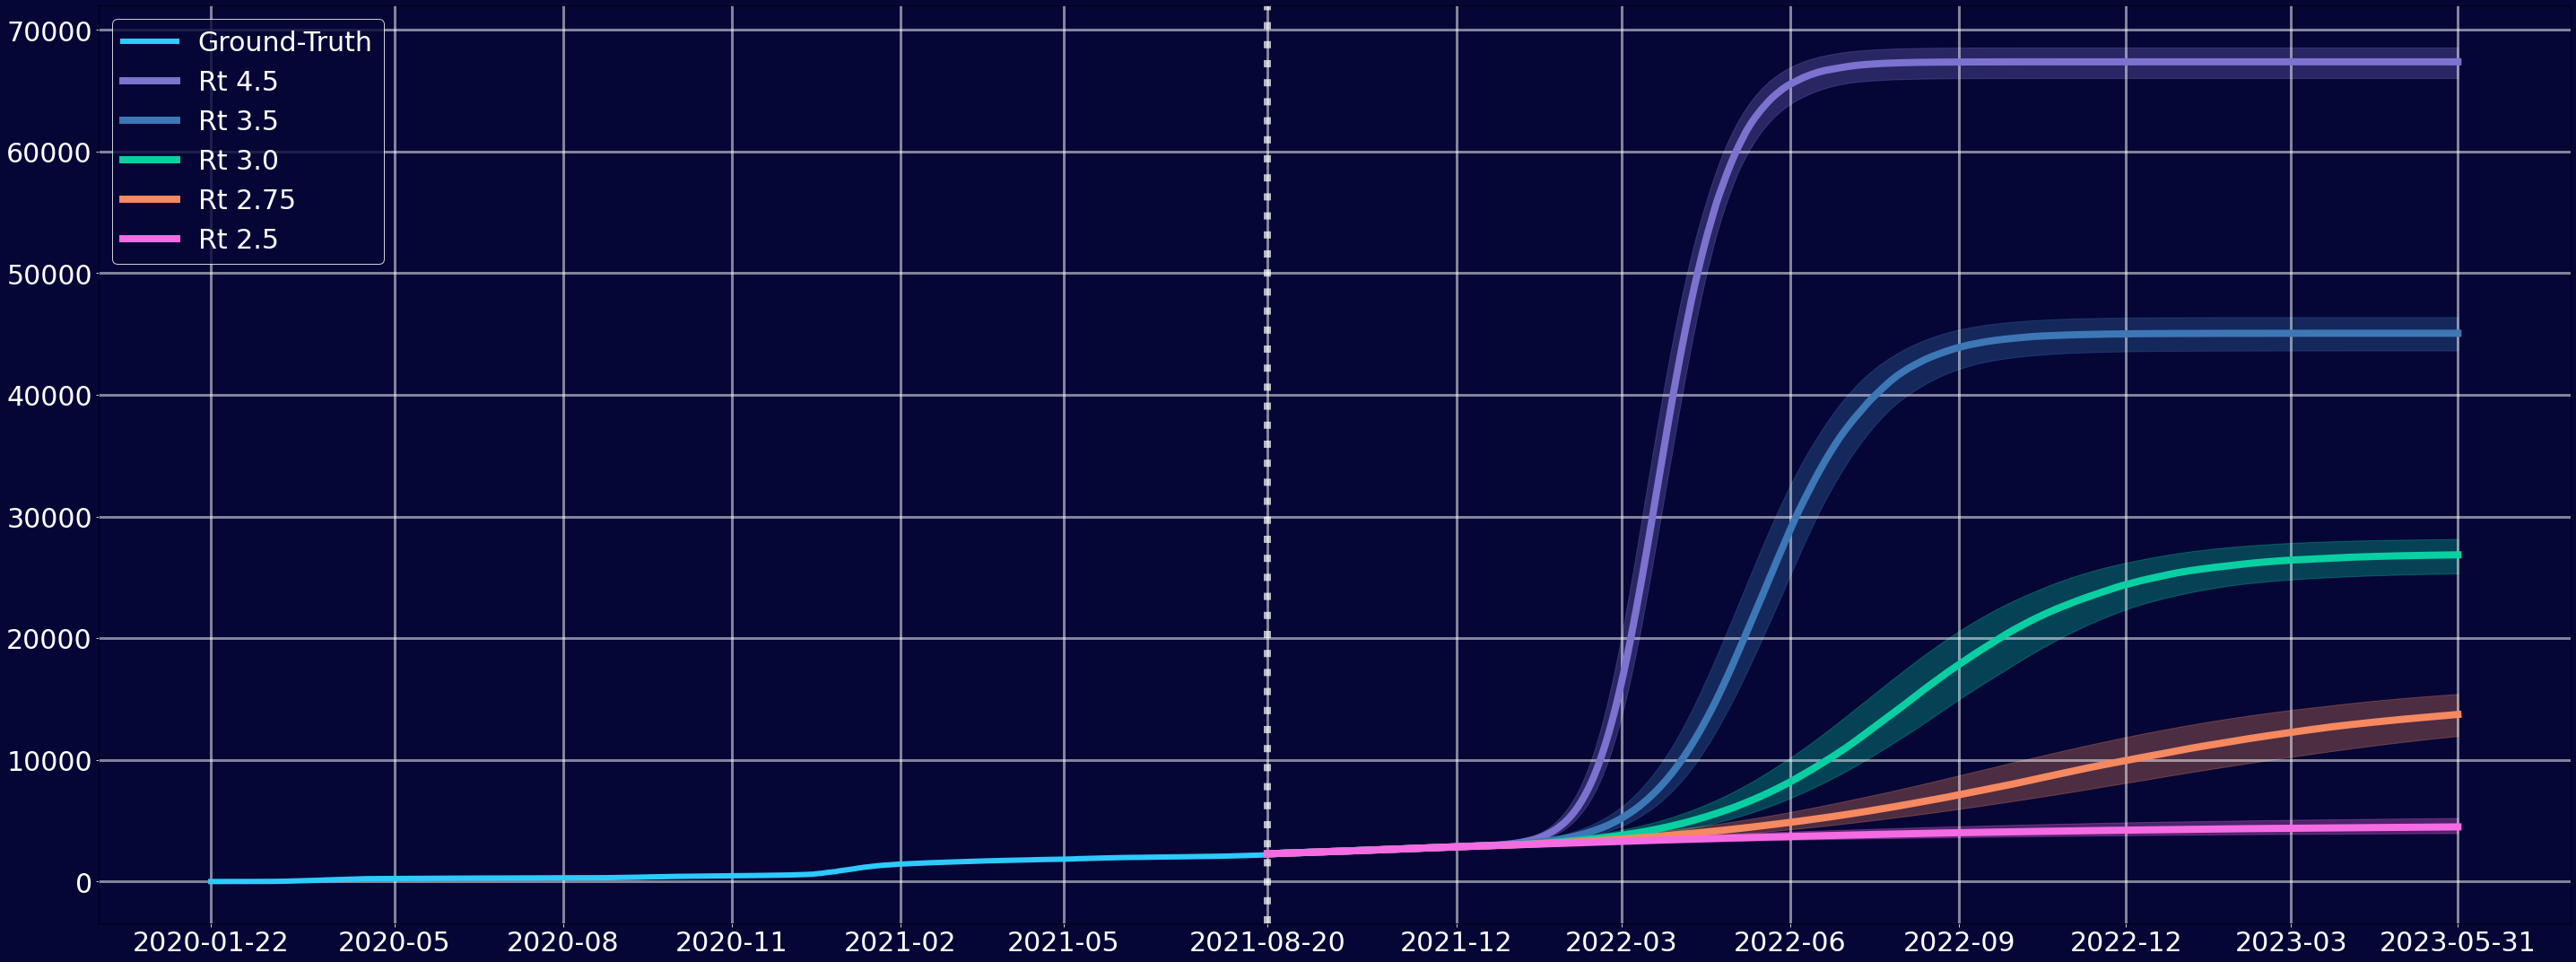

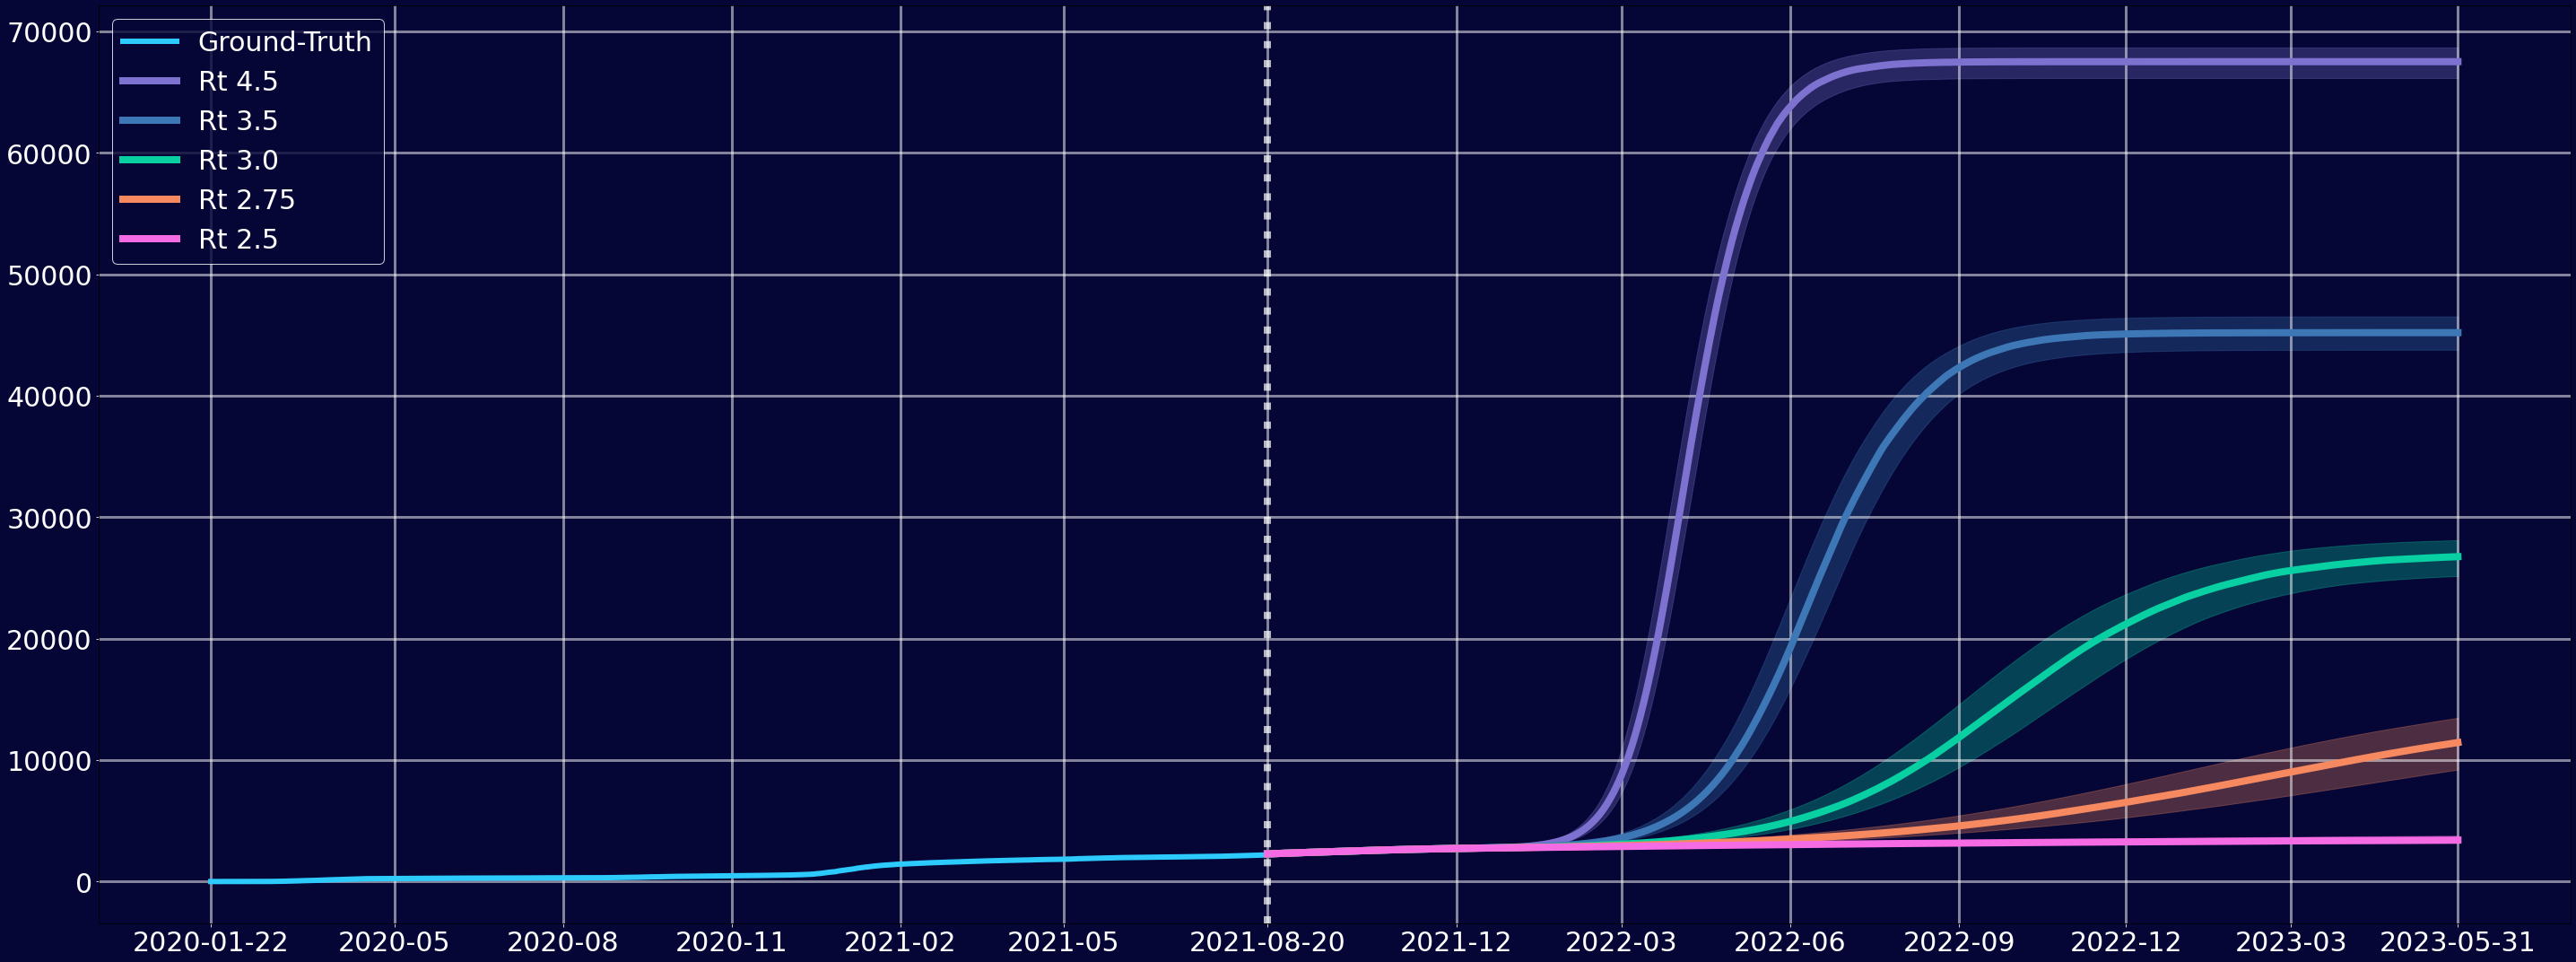

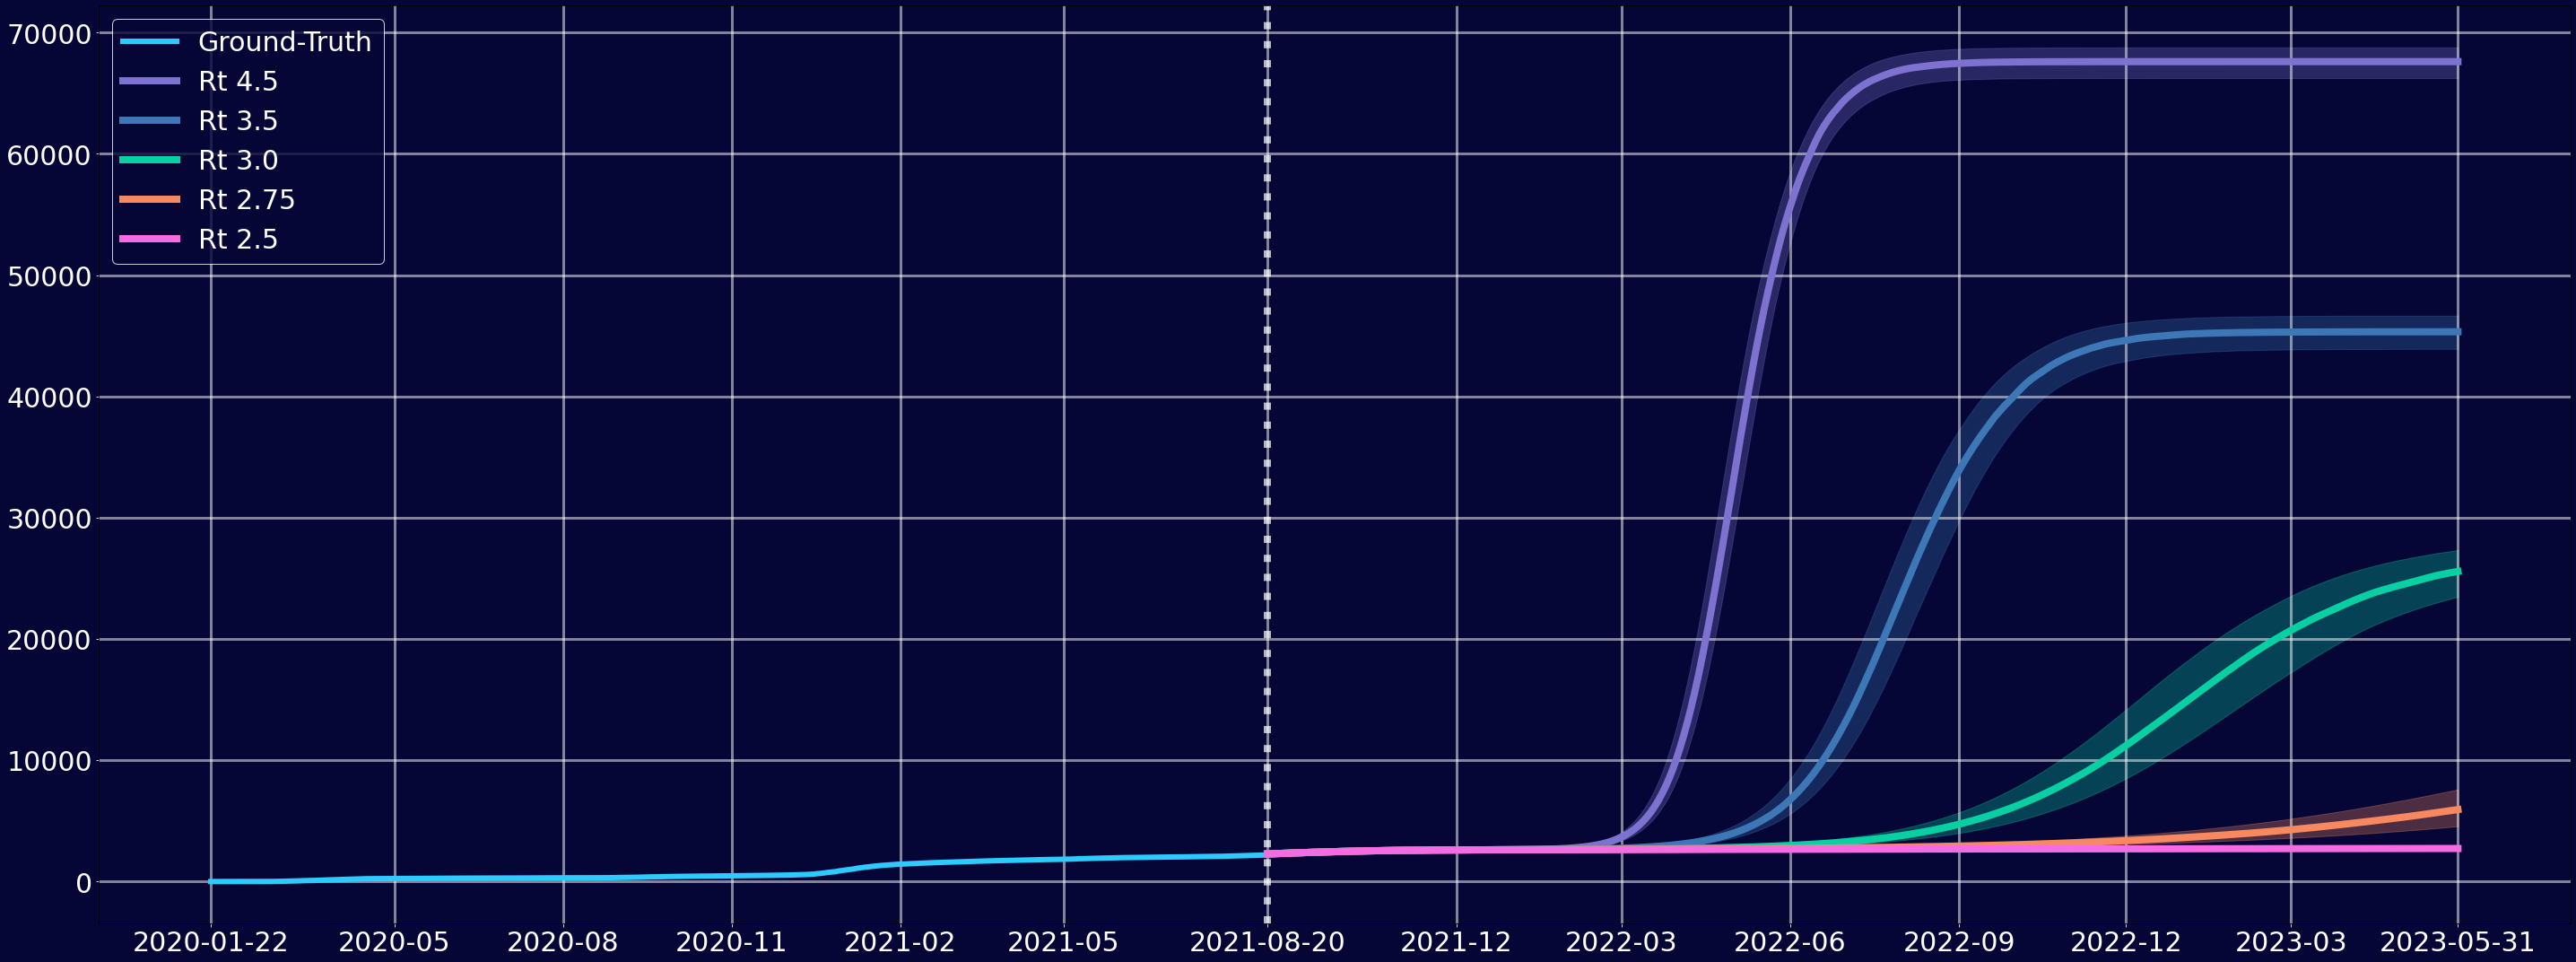

In [63]:
Rt_Plot('deaths',deaths,'Low')
Rt_Plot('deaths',deaths,'Base')
Rt_Plot('deaths',deaths,'High')